On se propose dans ce mini-projet d'entrainer plusieurs modèles pour la tâche de *sentiment analysis* sur le dataset IMDB.

In [ ]:
## Library imports
import random
import os
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Presentation de l'étude

## Tâche de Sentiment Analysis

La *sentiment analysis* est une tâche qui consiste à identifier et classer les émotions, opinions ou attitudes exprimées dans un texte, critiques, séquences textuellse. Le principe est de tenter de prédire si un texte exprime un sentiment positif ou négatif (ou parfois neutre, selon les cas).

Dans le cadre de ce projet, la *sentiment analysis* appliquée aux critiques IMDb permet d'entraîner un modèle capable de prédire le sentiment derrière une critique de film, en se basant uniquement sur le texte.

## Présentation du jeu de données IMDB

IMDB est un jeu de données pour la classification binaire des sentiments. Nous fournissons un ensemble de 25 000 critiques de films fortement polarisées pour l'entraînement et 25 000 pour les tests. Des données non étiquetées supplémentaires sont également disponibles. Les formats de texte brut et de sac de mots déjà traités sont fournis.


Le dataset utilisé pour cette tâche est le IMDb Dataset for Sentiment Analysis, proposé par Stanford. Il contient des critiques de films provenant de la base de données IMDb. Ces critiques sont organisées en deux catégories principales : positives et négatives, permettant une classification binaire des sentiments. Le dataset comprend :

50 000 critiques : 25 000 critiques pour l'entraînement *train* et 25 000 pour le *test*.
Les critiques d'entraînement et de test sont équilibrées, contenant chacune un nombre égal de critiques positives et négatives.
Les critiques varient en longueur, allant de quelques phrases à plusieurs paragraphes, offrant un défi intéressant pour les modèles de traitement du langage naturel (NLP).
Ce dataset est largement utilisé pour évaluer les modèles de classification des sentiments grâce à sa taille, sa structure et sa pertinence pour des tâches du monde réel.

In [ ]:
import os
import requests
import tarfile

# URL du dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Nom du fichier d'archive
archive_name = "aclImdb_v1.tar.gz"
dataset_folder = "aclImdb"

# Fonction pour télécharger le fichier
def download_dataset(url, archive_name):
    if not os.path.exists(archive_name):
        print("Téléchargement en cours...")
        response = requests.get(url, stream=True)
        with open(archive_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Fichier téléchargé : {archive_name}")
    else:
        print(f"Le fichier {archive_name} existe déjà.")

# Fonction pour extraire le fichier
def extract_dataset(archive_name, extract_path):
    if not os.path.exists(extract_path):
        print("Extraction en cours...")
        with tarfile.open(archive_name, "r:gz") as tar:
            tar.extractall(path=extract_path)
        print(f"Dataset extrait dans le dossier : {extract_path}")
    else:
        print(f"Le dossier {extract_path} existe déjà.")

# Télécharger et extraire le dataset
download_dataset(url, archive_name)
extract_dataset(archive_name, dataset_folder)

# Vérifier les fichiers extraits
print("Contenu du dossier extrait :")
for root, dirs, files in os.walk(dataset_folder):
    for name in files[:5]:  # Afficher seulement les 5 premiers fichiers
        print(os.path.join(root, name))

Téléchargement en cours...
Fichier téléchargé : aclImdb_v1.tar.gz
Extraction en cours...
Dataset extrait dans le dossier : aclImdb
Contenu du dossier extrait :
aclImdb/aclImdb/imdb.vocab
aclImdb/aclImdb/README
aclImdb/aclImdb/imdbEr.txt
aclImdb/aclImdb/train/urls_neg.txt
aclImdb/aclImdb/train/urls_pos.txt
aclImdb/aclImdb/train/urls_unsup.txt
aclImdb/aclImdb/train/unsupBow.feat
aclImdb/aclImdb/train/labeledBow.feat
aclImdb/aclImdb/train/neg/6378_4.txt
aclImdb/aclImdb/train/neg/4722_1.txt
aclImdb/aclImdb/train/neg/5264_4.txt
aclImdb/aclImdb/train/neg/2226_4.txt
aclImdb/aclImdb/train/neg/6392_3.txt
aclImdb/aclImdb/train/unsup/44083_0.txt
aclImdb/aclImdb/train/unsup/17334_0.txt
aclImdb/aclImdb/train/unsup/26566_0.txt
aclImdb/aclImdb/train/unsup/47090_0.txt
aclImdb/aclImdb/train/unsup/9279_0.txt
aclImdb/aclImdb/train/pos/2450_9.txt
aclImdb/aclImdb/train/pos/1532_10.txt
aclImdb/aclImdb/train/pos/12356_8.txt
aclImdb/aclImdb/train/pos/12429_7.txt
aclImdb/aclImdb/train/pos/2870_10.txt
aclImdb/a

In [ ]:
import os
import tensorflow as tf

dataset_folder = "aclImdb/aclImdb"

# Chemins vers les dossiers contenant les données
train_dir = os.path.join(dataset_folder, "train")
test_dir = os.path.join(dataset_folder, "test")

# Fonction pour charger les données
def load_imdb_data(data_dir):
    texts = []
    labels = []
    for label_type in ['pos', 'neg']:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label_type == 'pos' else 0)
    return texts, labels

# Chargement des données d'entraînement et de test
train_texts, train_labels = load_imdb_data(train_dir)
test_texts, test_labels = load_imdb_data(test_dir)

print(f"Nombre de critiques dans l'ensemble d'entraînement : {len(train_texts)}")
print(f"Nombre de critiques dans l'ensemble de test : {len(test_texts)}")

# Exemple de texte positif et négatif
print("\nExemple de critique positive :")
print(train_texts[train_labels.index(1)][:300])  # Affiche les 300 premiers caractères d'une critique positive

print("\nExemple de critique négative :")
print(train_texts[train_labels.index(0)][:300])  # Affiche les 300 premiers caractères d'une critique négative

Nombre de critiques dans l'ensemble d'entraînement : 25000
Nombre de critiques dans l'ensemble de test : 25000

Exemple de critique positive :
I have been watching this show since I was 14 and I've loved it ever since. I love this show because it's just plain funny! You will enjoy this show a lot because it shows something new and funnier everyday and my favorite part is when Benny always has her last comments on George after every punchli

Exemple de critique négative :
This movie was amusing at times, hell sometimes it was even downright funny.<br /><br />The underlying message I got from the film though, was that women are responsible for all of the troubles of man. Every time a woman is depicted in the film, she is being lazy, being slutty or lambasting some poo


Les premières critiques avec leurs labels correspondants (1 pour positif et 0 pour négatif) sont affichées.

## Prétraitement des données

### Exploration des données

Pour débuter notre analyse, commençons par une exploration des données. Une manière visuelle et intuitive d'examiner le contenu textuel d'un dataset est de générer un word cloud. Un word cloud est une représentation graphique où la taille des mots est proportionnelle à leur fréquence d’apparition dans un corpus donné. Cela permet de repérer rapidement les termes les plus utilisés dans les critiques.

En créant des word clouds pour les critiques positives et négatives, nous pouvons identifier les différences lexicales entre les deux catégories, ce qui nous donne un aperçu des mots qui influencent le sentiment exprimé.

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Télécharger les stopwords NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction pour créer un corpus basé sur les labels
def create_corpus_by_label(texts, labels, target_label):
    return " ".join([texts[i] for i in range(len(labels)) if labels[i] == target_label])

# Créer les corpus pour les critiques positives et négatives
positive_corpus = create_corpus_by_label(train_texts, train_labels, target_label=1)
negative_corpus = create_corpus_by_label(train_texts, train_labels, target_label=0)

# Fonction pour calculer les mots les plus fréquents
def most_frequent_words(corpus, top_n=10):
    # Diviser le corpus en mots
    words = [word.lower() for word in corpus.split() if word.lower() not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Calculer les 10 mots les plus fréquents pour chaque catégorie
positive_top_words = most_frequent_words(positive_corpus, top_n=10)
negative_top_words = most_frequent_words(negative_corpus, top_n=10)

# Affichage des résultats
print("10 mots les plus fréquents dans les critiques positives :")
for word, count in positive_top_words:
    print(f"{word}: {count}")

print("\n10 mots les plus fréquents dans les critiques négatives :")
for word, count in negative_top_words:
    print(f"{word}: {count}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


10 mots les plus fréquents dans les critiques positives :
/><br: 24617
film: 14641
movie: 13516
one: 11668
like: 8321
good: 6081
great: 5504
see: 5400
really: 5259
would: 5240

10 mots les plus fréquents dans les critiques négatives :
/><br: 26318
movie: 17371
film: 13136
one: 10812
like: 10458
even: 7352
would: 6787
good: 5845
really: 5806
bad: 5335


Les critiques dans le dataset IMDb contiennent du texte HTML brut. Les br et />  proviennent des balises HTML incluses dans les critiques du dataset IMDb. Ces balises sont utilisées pour indiquer des sauts de ligne ou des séparations de paragraphes dans le texte brut. Elles n’ont pas été filtrées et apparaissent dans les mots les plus fréquents car elles sont souvent présentes dans les critiques.

Ces balises sont considérées comme des mots par le tokenizer dont on parlera plus tard.
Elles faussent donc les statistiques de fréquence en apparaissant parmi les mots les plus fréquents.
Le bruit dans les données (comme les balises HTML, caractères spéciaux inutiles, etc.) peut introduire des relations non informatives dans le modèle.

Nous devons donc supprimer ces balises et nettoyer le text brut. Cela pourrait détourner le modèle de l'apprentissage de rélations pertinentes entre les mots et sentiments de celui qui écrit la critique.Cela pourrait aussi conduire à une baisse de précision. Enfin, lors de la phase de tokenizing, chaque mot inutile comme les balises html réduit la place disponible dans le vocabulaire pour les mots pertinents.

In [ ]:
import re
# Fonction de nettoyage
def clean_text(text):
    # Supprimer les balises HTML
    text = re.sub(r"<.*?>", " ", text)
    # Supprimer les caractères non alphabétiques (optionnel)
    text = re.sub(r"[^a-zA-Z']", " ", text)
    # Réduire les espaces multiples en un seul espace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Nettoyer toutes les critiques d'entraînement et de test
train_texts_cleaned = [clean_text(text) for text in train_texts]
test_texts_cleaned = [clean_text(text) for text in test_texts]

# Fonction pour recalculer les mots les plus fréquents après nettoyage
def most_frequent_words_cleaned(corpus, top_n=10):
    # Diviser le corpus en mots
    words = [word.lower() for word in corpus.split() if word.lower() not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Recréer les corpus nettoyés pour critiques positives et négatives
positive_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=1)
negative_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=0)

# Calculer les 10 mots les plus fréquents après nettoyage
positive_top_words_cleaned = most_frequent_words_cleaned(positive_corpus_cleaned, top_n=10)
negative_top_words_cleaned = most_frequent_words_cleaned(negative_corpus_cleaned, top_n=10)

# Afficher les résultats après nettoyage
print("10 mots les plus fréquents dans les critiques positives (nettoyées) :")
for word, count in positive_top_words_cleaned:
    print(f"{word}: {count}")

print("\n10 mots les plus fréquents dans les critiques négatives (nettoyées) :")
for word, count in negative_top_words_cleaned:
    print(f"{word}: {count}")

10 mots les plus fréquents dans les critiques positives (nettoyées) :
film: 20372
movie: 18860
one: 13496
like: 9038
good: 7703
story: 6715
time: 6491
great: 6409
well: 6408
see: 6016

10 mots les plus fréquents dans les critiques négatives (nettoyées) :
movie: 24712
film: 18733
one: 13023
like: 11238
even: 7691
good: 7397
bad: 7374
would: 6902
really: 6262
time: 6195


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


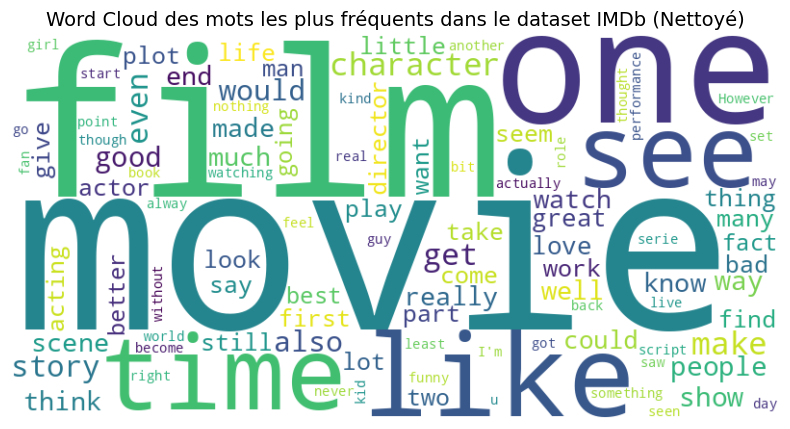

In [ ]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Télécharger les stopwords NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction pour créer un corpus combiné à partir des critiques
def create_corpus(texts):
    # Fusionner toutes les critiques en un seul grand texte
    return " ".join(texts)

# Générer le corpus à partir des textes nettoyés d'entraînement
corpus_cleaned = create_corpus(train_texts_cleaned)

# Génération du WordCloud à partir des données nettoyées
wordcloud_cleaned = WordCloud(
    stopwords=stop_words,  # Exclure les stopwords
    background_color="white",  # Couleur de fond
    max_words=100,  # Nombre maximum de mots à afficher
    width=800,  # Largeur de l'image
    height=400  # Hauteur de l'image
).generate(corpus_cleaned)

# Affichage du WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des mots les plus fréquents dans le dataset IMDb (Nettoyé)", fontsize=14)
plt.show()

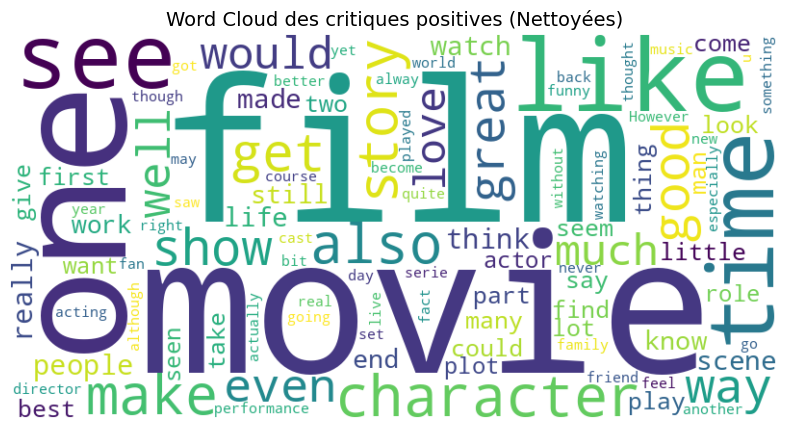

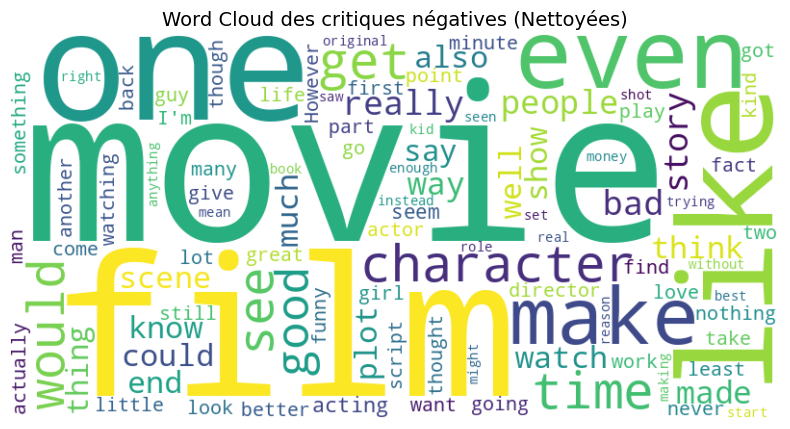

In [ ]:
# Création des corpus pour critiques positives et négatives (nettoyées)
positive_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=1)
negative_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=0)

# Génération des WordClouds
def generate_wordcloud(corpus, title, stopwords, width=800, height=400):
    wordcloud = WordCloud(
        stopwords=stopwords,
        background_color="white",
        max_words=100,
        width=width,
        height=height
    ).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# WordCloud pour critiques positives (nettoyées)
generate_wordcloud(positive_corpus_cleaned, "Word Cloud des critiques positives (Nettoyées)", stop_words)

# WordCloud pour critiques négatives (nettoyées)
generate_wordcloud(negative_corpus_cleaned, "Word Cloud des critiques négatives (Nettoyées)", stop_words)

Longueur moyenne des critiques d'entraînement (nettoyées) : 232.39 mots
Longueur moyenne des critiques de test (nettoyées) : 227.14 mots
Proportion des critiques d'entraînement plus longues que 200 mots (nettoyées) : 41.09%
Proportion des critiques de test plus longues que 200 mots (nettoyées) : 40.01%


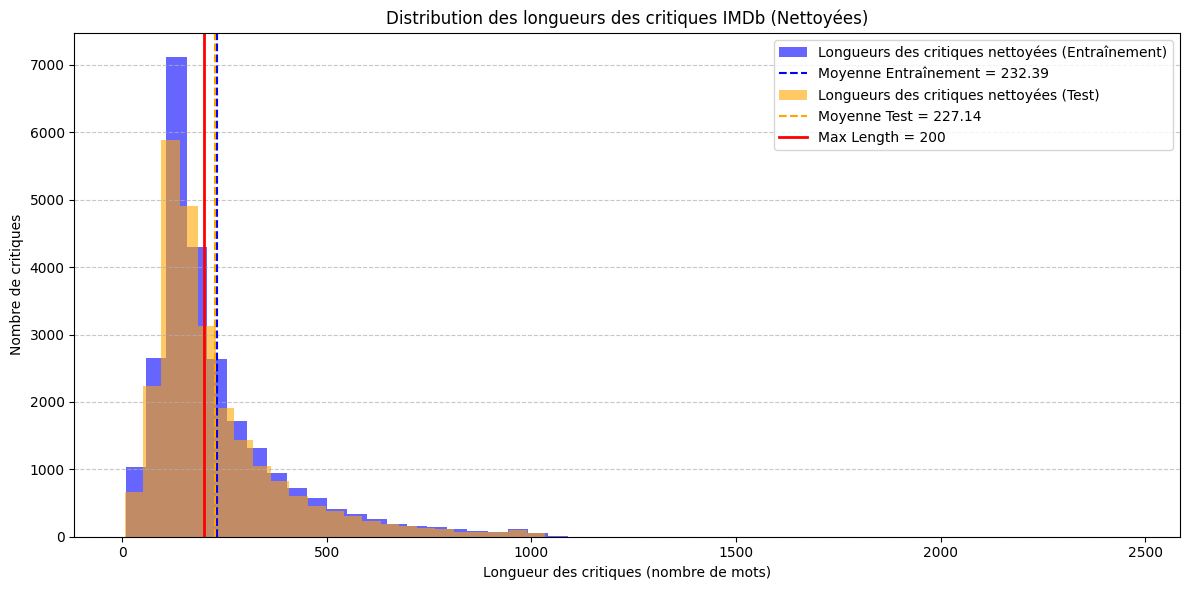

In [ ]:


# Calculer la longueur de chaque critique nettoyée
train_lengths_cleaned = [len(text.split()) for text in train_texts_cleaned]
test_lengths_cleaned = [len(text.split()) for text in test_texts_cleaned]

# Calculer la longueur moyenne des critiques nettoyées
average_train_length_cleaned = sum(train_lengths_cleaned) / len(train_lengths_cleaned)
average_test_length_cleaned = sum(test_lengths_cleaned) / len(test_lengths_cleaned)

# Afficher les résultats
print(f"Longueur moyenne des critiques d'entraînement (nettoyées) : {average_train_length_cleaned:.2f} mots")
print(f"Longueur moyenne des critiques de test (nettoyées) : {average_test_length_cleaned:.2f} mots")

# Vérifier la proportion des critiques plus longues que max_length
max_length = 200  # Longueur maximale définie
train_above_max_cleaned = sum(1 for length in train_lengths_cleaned if length > max_length) / len(train_lengths_cleaned) * 100
test_above_max_cleaned = sum(1 for length in test_lengths_cleaned if length > max_length) / len(test_lengths_cleaned) * 100

print(f"Proportion des critiques d'entraînement plus longues que {max_length} mots (nettoyées) : {train_above_max_cleaned:.2f}%")
print(f"Proportion des critiques de test plus longues que {max_length} mots (nettoyées) : {test_above_max_cleaned:.2f}%")

# Visualisation de la distribution des longueurs nettoyées
plt.figure(figsize=(12, 6))

# Histogramme pour les données d'entraînement nettoyées
plt.hist(train_lengths_cleaned, bins=50, alpha=0.6, color='blue', label='Longueurs des critiques nettoyées (Entraînement)')
plt.axvline(average_train_length_cleaned, color='blue', linestyle='dashed', linewidth=1.5, label=f'Moyenne Entraînement = {average_train_length_cleaned:.2f}')

# Histogramme pour les données de test nettoyées
plt.hist(test_lengths_cleaned, bins=50, alpha=0.6, color='orange', label='Longueurs des critiques nettoyées (Test)')
plt.axvline(average_test_length_cleaned, color='orange', linestyle='dashed', linewidth=1.5, label=f'Moyenne Test = {average_test_length_cleaned:.2f}')

# Ligne verticale pour la longueur maximale
plt.axvline(max_length, color='red', linestyle='solid', linewidth=2, label=f'Max Length = {max_length}')

# Configuration du graphique
plt.title("Distribution des longueurs des critiques IMDb (Nettoyées)")
plt.xlabel("Longueur des critiques (nombre de mots)")
plt.ylabel("Nombre de critiques")
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Afficher le graphique
plt.show()

La longueur moyenne est légèrement supérieure à 200 mots, mais elle montre que la majorité des critiques sont assez courtes ou modérément longues. De plus, les critiques trop longues contiennent souvent des détails non pertinents pour la classification sentimentale. C'est un paramètre important qui nous servira à la *tokenization*.

## Tokenization

Il est nécessaire de passer par une phase de tokenization avant de traiter le texte pour la classification sentimentale. La tokenization est le processus de division d’un texte en unités nommées tokens.

Les modèles de NLP que nous allons utiliser travaillent avec des données numériques, mais les critiques sont sous forme de texte brut. La tokenization permet de convertir le texte en un format exploitable par les modèles.
Lors de la tokenization, les mots sont mappés à des indices dans un vocabulaire, permettant au modèle de manipuler les séquences de manière efficace.

Pour cette tâche de sentiment analysis, une représentation séquentielle est plus adaptée pour plusieurs raisons :

Les RNN, LSTM et GRU traitent les données de façon séquentielle, en tenant compte de l’ordre des mots. Cela permet au modèle de comprendre des structures syntaxiques importantes. Avec des séquences, nous pouvons utiliser des représentations comme des embeddings, qui permettent d’apprendre des relations sémantiques entre les mots. Enfin, le dataset IMDb contient des critiques où l’ordre des mots et les relations entre les mots sont importants pour analyser le sentiment exprimé. Une représentation séquentielle permet de capturer ces nuances.

La tokenization basée sur les séquences est une méthode qui convertit un texte en une liste ordonnée d’indices numériques représentant les mots ou les tokens du texte. Cette approche conserve l’ordre des mots, ce qui est essentiel pour capturer les relations syntaxiques et sémantiques entre eux.

Dans le cadre du sentiment analysis, on construit un vocabulaire. créé à partir du corpus d’entraînement, où chaque mot unique est associé à un indice numérique. Les mots les plus fréquents sont priorisés. Chaque mot d’une phrase est remplacé par son indice correspondant dans le vocabulaire.

Les mots absents du vocabulaire (parce qu’ils sont rares ou hors du corpus d’entraînement) sont remplacés par un token spécial, comme <OOV> (Out-Of-Vocabulary).

Les critiques sont de longueurs variées. Hors pour la garantir la compatibilité avec les modèles de Deep Learning que nous allons utiliser, nous devons nous assurer que les critiques sont de mêmes longueurs. Nous allons donc tronquées ou remplir (via un padding) les séquences. Puisque les sequences sont en moyenne de dimension 200 d'après l'étude empirique précedente, et que les critiques trop longues contiennent de manière générale des détails non pertinents pour la classification sentimentale, nous allons tronquer les séquences trop grandes et remplir via un padding les séquences de moins de 200 caractères. Dans le dataset IMDb, de nombreuses critiques sont plus courtes que la longueur maximale fixée. Le padding permet de préserver ces critiques courtes en ajoutant des zéros à la fin (padding='post') sans modifier leur contenu. Toutes nos séquences d'entrée seront donc de dimension 200 pour nos modèles.

Nous avons un total de 85 676 mots uniques dans le dataset. Réduire à 10 000 capture les mots les plus fréquents, ce qui est souvent suffisant dans l'état de l'art de la classification de sentiment. De plus, dans notre séquence, les indices sont tous inférieurs à 10 000, indiquant que notre vocabulaire est suffisant pour représenter ces critiques.

Plus le vocabulaire est grand, plus le modèle doit gérer un espace de recherche important, ce qui augmente les besoins en mémoire et les temps de calcul. En limitant à 10 000 mots, on garde les mots les plus fréquents, qui capturent généralement la majorité du sens du texte. Les mots rares (apparaissant très peu dans le dataset) ne sont souvent pas informatifs pour le modèle. En les excluant, on réduit le bruit dans les données.

Ce seuil de 10% à 20% du vocabulaire totale communément utilisée dans les tâches NLP. Ce seuil est un compromis entre conserver suffisamment de vocabulaire pour capturer le sens du texte et limiter les ressources nécessaires pour entraîner le modèle.



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialisation du tokenizer
vocab_size = 10000  # Limitation du vocabulaire
max_length = 200  # Longueur maximale des séquences
oov_token = "<OOV>"  # Token pour les mots hors vocabulaire

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_texts_cleaned)  # Apprentissage du vocabulaire sur les critiques nettoyées

# Tokenization : conversion des textes nettoyés en séquences
train_sequences = tokenizer.texts_to_sequences(train_texts_cleaned)
test_sequences = tokenizer.texts_to_sequences(test_texts_cleaned)

# Padding des séquences pour uniformiser leur longueur
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Conversion des labels en tenseur
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Affichage des données préparées
print(f"Exemple de séquence tokenisée (entraînement) : {train_sequences[0][:10]}")
print(f"Exemple de séquence avec padding (entraînement) : {train_padded[0]}")
print(f"Vocabulaire total : {len(tokenizer.word_index)} mots")

Exemple de séquence tokenisée (entraînement) : [10, 25, 74, 146, 11, 120, 234, 10, 13, 3]
Exemple de séquence avec padding (entraînement) : [  10   25   74  146   11  120  234   10   13    3  204  443    9  123
  234   10  116   11  120   84   42   40 1034  159   22   77  353   11
  120    4  172   84    9  284  139  158    3 2774 2863    3   58  507
  169    7   51 8276  207   45   38  233  788   20  734  100  171 9710
   41   24 1902 1451  415  910   10   59  457    3  468  103    9   16
   58  363   30  339 9711   27   37   72   68  146    4  159   17   18
  341  116  734 7437  159 1009  159 2065   11    7    4  638  159  220
  209  197  728    6  312    3   22   77  403  353    9   10  119    3
   44   22  767  293    9  242   10 1452   12   22  375  146   84   22
  579  178    6  563  146    9   57  148   47  703 1611 3376  158  664
   10  128  353    2  738 1118  128  159  112 2864  122    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   

Chaque critique a été transformée en une séquence d’indices numériques. Ces indices correspondent aux positions des mots dans le vocabulaire généré par le tokenizer. L'ordre des indices dans la séquence est identique à l'ordre des mots dans la critique d'origine. Cela permet de préserver les relations sémantiques et syntaxiques entre les mots, essentielles pour des modèles séquentiels.

La séquence tokenisée a été complétée par des zéros pour atteindre une longueur fixe de 200 mots, définie par le paramètre max_length.
Les zéros sont ajoutés à la fin de la séquence (padding='post'), qui assure que toutes les séquences ont la même longueur sans altérer l'ordre des mots d'origine.

La tokenization doit être bijective, c'est-à-dire qu'il devrait être possible de reconstruire le texte d'origine à partir de la séquence tokenisée, à condition que tous les mots soient présents dans le vocabulaire. Cela garantit que le processus de tokenization n'a pas introduit d'erreurs ou d'incohérences.

Les deux textes devraient être similaires, bien que le texte reconstruit puisse avoir des différences (par exemple, des mots remplacés par <OOV> si absents du vocabulaire).
Si le texte reconstruit est trop éloigné, cela peut indiquer un problème dans le vocabulaire ou le processus de tokenization.
Vérifier les tokens <OOV> :

Si des mots du texte reconstruit sont remplacés par <OOV>, cela signifie que ces mots étaient hors du vocabulaire. Leur proportion peut être calculée pour évaluer si la taille du vocabulaire (vocab_size) est suffisante.

In [ ]:
# Nettoyer une critique d'origine
cleaned_text = clean_text(train_texts[0])

# Conversion en séquence tokenisée
tokenized_sequence = tokenizer.texts_to_sequences([cleaned_text])[0]

# Reconstruire le texte à partir de la séquence
reconstructed_text = " ".join([tokenizer.index_word.get(token, "<OOV>") for token in tokenized_sequence])

# Afficher les résultats
print("Texte original (nettoyé) :")
print(cleaned_text[:300])  # Limiter à 300 caractères pour éviter les sorties trop longues

print("\nSéquence tokenisée :")
print(tokenized_sequence[:20])  # Limiter à 20 tokens pour simplifier la lecture

print("\nTexte reconstruit :")
print(reconstructed_text[:300])  # Limiter à 300 caractères

Texte original (nettoyé) :
I have been watching this show since I was and I've loved it ever since I love this show because it's just plain funny You will enjoy this show a lot because it shows something new and funnier everyday and my favorite part is when Benny always has her last comments on George after every punchline ab

Séquence tokenisée :
[10, 25, 74, 146, 11, 120, 234, 10, 13, 3, 204, 443, 9, 123, 234, 10, 116, 11, 120, 84]

Texte reconstruit :
i have been watching this show since i was and i've loved it ever since i love this show because it's just plain funny you will enjoy this show a lot because it shows something new and funnier everyday and my favorite part is when benny always has her last comments on george after every punchline ab


In [ ]:
# Calculer le pourcentage de mots hors vocabulaire
oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
total_count = len(tokenized_sequence)
oov_percentage = (oov_count / total_count) * 100

print(f"\nProportion des mots hors vocabulaire : {oov_percentage:.2f}%")


Proportion des mots hors vocabulaire : 0.00%


Dans cet exemple, la tokenization a été effectuée correctement.

In [ ]:
# Sélectionner 5 indices aléatoires
random_indices = random.sample(range(len(train_texts)), 5)

for idx in random_indices:
    # Texte original nettoyé
    original_text = train_texts_cleaned[idx]

    # Séquence tokenisée
    tokenized_sequence = tokenizer.texts_to_sequences([original_text])[0]

    # Texte reconstruit à partir de la séquence
    reconstructed_text = " ".join([tokenizer.index_word.get(token, "<OOV>") for token in tokenized_sequence])

    # Calcul de la proportion de mots hors vocabulaire
    oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
    total_count = len(tokenized_sequence)
    oov_percentage = (oov_count / total_count) * 100 if total_count > 0 else 0

    # Appliquer le padding à la séquence
    padded_sequence = pad_sequences([tokenized_sequence], maxlen=max_length, padding='post', truncating='post')[0]

    # Vérifier la longueur de la séquence après padding
    sequence_length = len(padded_sequence)
    is_length_correct = sequence_length == max_length

    # Affichage des résultats
    print(f"Exemple {idx + 1} :\n")
    print("Texte original (nettoyé) :")
    print(original_text[:300])  # Limiter à 300 caractères
    print("\nSéquence tokenisée :")
    print(tokenized_sequence[:20])  # Limiter à 20 tokens
    print("\nTexte reconstruit :")
    print(reconstructed_text[:300])  # Limiter à 300 caractères
    print(f"\nProportion des mots hors vocabulaire : {oov_percentage:.2f}%")
    print("\nLongueur de la séquence après padding :", sequence_length)
    print("La longueur de la séquence est-elle correcte ? :", is_length_correct)
    print("-" * 80)

Exemple 5126 :

Texte original (nettoyé) :
I have found this movie available for streaming on Netflix and thought I'd give it a try The plot revolves around Ryan and Theo Taylor Colm Feore and David Cubitt who have finally seen each other after their father has passed away Ryan and Theo at first argue about who did what But later Theo finds 

Séquence tokenisée :
[10, 25, 254, 11, 17, 1426, 15, 1, 20, 6226, 3, 194, 468, 199, 9, 4, 348, 2, 111, 3040]

Texte reconstruit :
i have found this movie available for <OOV> on netflix and thought i'd give it a try the plot revolves around ryan and theo taylor <OOV> <OOV> and david <OOV> who have finally seen each other after their father has passed away ryan and theo at first argue about who did what but later theo finds out 

Proportion des mots hors vocabulaire : 5.84%

Longueur de la séquence après padding : 200
La longueur de la séquence est-elle correcte ? : True
-------------------------------------------------------------------------------

Regardons le pourcentage d'OOV moyen dans notre jeu de données d'entrainement.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fonction pour calculer la proportion de mots hors vocabulaire pour une critique
def calculate_oov_percentage(text, tokenizer):
    tokenized_sequence = tokenizer.texts_to_sequences([text])[0]
    oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
    total_count = len(tokenized_sequence)
    oov_percentage = (oov_count / total_count) * 100 if total_count > 0 else 0
    return oov_percentage

# Calculer le pourcentage moyen d'OOV pour l'ensemble des critiques
all_oov_percentages = []

for text in train_texts_cleaned:
    oov_percentage = calculate_oov_percentage(text, tokenizer)
    all_oov_percentages.append(oov_percentage)

# Calculer la moyenne
mean_oov_percentage = np.mean(all_oov_percentages)

# Afficher le résultat
print(f"Pourcentage moyen de mots hors vocabulaire (OOV) : {mean_oov_percentage:.2f}%")

Pourcentage moyen de mots hors vocabulaire (OOV) : 5.21%


Un certain pourcentage d’OOV est inévitable. Le vocabulaire est limité aux 10 000 mots les plus fréquents pour réduire la taille du modèle et le bruit des mots rares. Cela signifie que les mots moins fréquents seront exclus et apparaîtront comme <OOV>. De plus, le dataset IMDb contient des critiques écrites par différentes personnes, avec des styles variés, des abréviations ou des termes spécifiques (noms de films, acteurs, etc.), qui sont moins fréquents dans le corpus.

Ici, le pourcentage moyen est relativement faible, indiquant que le vocabulaire est suffisamment large pour couvrir la plus part des mots significatifs.

La tokenization a été effectuée correctement. Les séquences sont correctement transformées et prêtes pour être utilisées dans un modèle. La taille du vocabulaire est raisonnable pour inclure les mots les plus informatifs tout en excluant les mots rares ou inutiles.

# Entrainement des modèles

## Preparation des données

Nous commencons dans un premier par séparer nos données d'entrainement en un jeu de données d'apprentissage représentant 80% des données, et un jeu de données de validation qui contient les 20% réstants.

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assurez-vous que les labels sont des tableaux NumPy avant la séparation
train_labels_np = np.array(train_labels)

# Séparation des données
train_padded_train, train_padded_val, train_labels_train, train_labels_val = train_test_split(
    train_padded, train_labels_np, test_size=0.2, random_state=42
)

# Reconversion des labels en tenseurs TensorFlow
train_labels_train = tf.convert_to_tensor(train_labels_train, dtype=tf.int32)
train_labels_val = tf.convert_to_tensor(train_labels_val, dtype=tf.int32)

# Vérification des formes
print(f"Entraînement : {train_padded_train.shape}, Labels : {train_labels_train.shape}")
print(f"Validation : {train_padded_val.shape}, Labels : {train_labels_val.shape}")


Entraînement : (20000, 200), Labels : (20000,)
Validation : (5000, 200), Labels : (5000,)


Cela évite au modèle de mémoriser ces données au lieu de généraliser. Le jeu de validation aide à évaluer la performance sur des données non vues pendant l'entraînement.

##RNN

Commencons dan sun premier temps par entrainer un Recurrent Neural Network (RNN).

Ces réseaux sont conçus pour traiter des données séquentielles. Ces réseaux possèdent en outre des connexions récurrentes, ce qui leur permet de conserver un mémoire des étapes précedentes. Celà permet de comprendre le contexte et les relations dans nos séquences.

Les RNN traitent les entrées séquentiellement, un élément à la fois, en maintenant un état interne (ou mémoire) qui est mis à jour à chaque étape.
À chaque pas de temps, le RNN combine l'entrée actuelle avec cet état interne pour produire une sortie.

Un RNN produit des sorties à chaque étape temporelle que l'on appelle scores. Ces scores sont des vecteurs de dimension égale au nombre de classes (2 classes dans notre cas).

Dans le cas de la classification binaire, on applique enfin un sigmoid sur ces scores, les covertissant en probabilités. On utilisera enfin une perte de Binary Cross-Entropy, notre classification étant binaire.

Commençons par entyrainer un modèle simple de RNN. On commence par une couche d'embedding, qui crée une représentation dense des mots : chaque mot est transformé en un vecteur dense. Ces vecteurs, appelés embeddings, capturent les relations sémantiques et syntaxiques entre les mots dans un espace vectoriel. Cela permet en outre de fournir une entrée adaptée à la couche RNN. Ces embeddings sont appris au cours de l'apprentissage du modèle.
On chosiit en outre une dimension d'embedding de 100, ce qui est préconisé dans la litterature scientifique pour un dataset modérément grand comme le nôtre. On considère qu'une dimension de 100 permet de de capturer les relations sémantiques pertinentes sans rendre le modèle trop complexe, suffisemment pour la classification binaire de sentiments.
En somme, une dimension de 100 permet de capturer les relations pertinentes, tout en gradant un temps d'entrainement raisonnables et garantissant un modèle suffisamment simple pour éviter le surapprentissage.

On utilise une seule couche RNN avec 64 unités pour commencer. On choisit ici une petite taille pour éviter le surrapprentissage. On verra après si une seule couche suffit, ce qui signifierait que les dépendances séquentielles sont plutôt simples.

On met une couche de dropout de 20%, abandonnant 20% des neurones et évitant le surapprentissage.

On ajoute enfin une couche dense avec 1 neurone en sortie du modèle, et une activation sigmoid, adaptée à la classification binaire.

Pour finir, la binary cross entropy est choisie en tant que Loss, idéale pour la classification binaire.

On prend une taille de batch à 64, permettant d'optimiser les performances du GPU. On choisit un nombre d'epochs de 10 ce qui est classique pour esperer observer une convergence.

Concernant l'optimiseur, on choisit l'optimiseur Adam par défaut avec un learning rate de 0.001, ce qui standard, pour sa vitesse de convergence et sa robustesse et sa capacité à gérer automatiquement les ajustements des pas d'apprentissage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Paramètres pour l'embedding layer
embedding_dim = 100  # Taille des vecteurs de mots

# Définition du modèle RNN
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation du modèle
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du résumé du modèle
mod.summary()

# Entraînement du modèle
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (1, 64)                     │          10,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,625 (3.86 MB)

 Trainable params: 1,010,625 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.4992 - loss: 0.7003 - val_accuracy: 0.4956 - val_loss: 0.6946
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5051 - loss: 0.7062 - val_accuracy: 0.4970 - val_loss: 0.6978
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5193 - loss: 0.6972 - val_accuracy: 0.5056 - val_loss: 0.6949
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5631 - loss: 0.6740 - val_accuracy: 0.5076 - val_loss: 0.7005
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5915 - loss: 0.6530 - val_accuracy: 0.5168 - val_loss: 0.7069
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6146 - loss: 0.6215 - val_accuracy: 0.5194 - val_loss: 0.7199
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6066 - loss: 0.6313 - val_accuracy: 0.5184 - val_loss: 0.7203
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6171 - loss: 0.6100 - val_acc

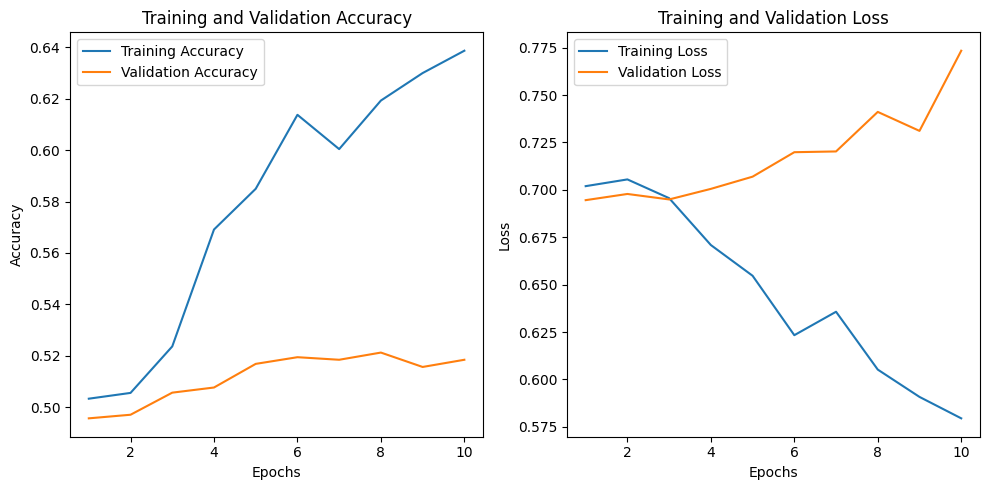

In [ ]:
import matplotlib.pyplot as plt

# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

La perte diminue constamment, indiquant que le modèle apprend bien sur les données d'entraînement. À l'époque 10, la perte d'entraînement est 0.34, ce qui montre une bonne

La perte sur l'ensemble de validation augmente constamment après l'époque 2 (0.7155 → 1.0707).
Cela montre un surapprentissage (overfitting) : le modèle s'adapte trop spécifiquement aux données d'entraînement et ne généralise pas bien.

L'accuracy augmente jusqu'à 78.69% à l'époque 10, ce qui est un bon résultat pour l'entraînement.

L'accuracy de validation reste autour de 50%, proche du hasard (problème de classification binaire).

Le modèle surapprend :
La divergence entre l'accuracy d'entraînement (78%) et de validation (50%) indique un surapprentissage.
Problème de généralisation :
Le modèle n'arrive pas à apprendre de manière efficace les patterns présents dans l'ensemble de validation.
Cela peut venir d'un manque de régularisation ou d'une capacité du modèle inadaptée (trop simple).

Pour améliorer ce modèle, on décide déjà de rajouter une couche simple.
Apprentissage de caractéristiques plus complexes : Une deuxième couche SimpleRNN permet au modèle d'apprendre des représentations plus abstraites des séquences après la première couche. Cela améliore la capacité du modèle à capturer des relations temporelles plus riches.
Augmentation de la capacité du modèle : En ajoutant une couche supplémentaire, le modèle gagne en profondeur, ce qui peut l'aider à mieux modéliser les données d'entrée.
Amélioration des performances : Avec une architecture plus complexe, on peut espérer une meilleure performance si le modèle est bien régularisé.

Surapprentissage (overfitting) :

Une couche SimpleRNN supplémentaire augmente le nombre de paramètres du modèle.
Cela rend le modèle plus complexe et donc plus susceptible de s'adapter trop fortement aux données d'entraînement, ce qui peut réduire la performance en validation.

Pour ajouter une couche SimpleRNN tout en limitant le surapprentissage, voici les techniques recommandées :

Augmenter le Dropout :

Le Dropout aide à régulariser le modèle en désactivant de manière aléatoire des neurones pendant l'apprentissage.
Cela empêche le modèle de devenir trop dépendant de certains neurones.
Appliquer une régularisation L2 (ridge regularization) :

La régularisation L2 pénalise les poids trop grands dans les couches denses, ce qui réduit le surapprentissage.
Ajouter du Dropout entre les couches RNN :

Cela permet de régulariser la sortie de chaque couche RNN avant qu'elle ne soit transmise à la suivante.

Bénéfices attendus :
Amélioration de la généralisation grâce à la régularisation L2 et au Dropout.
Capacité accrue du modèle pour capturer des motifs plus complexes.
Réduction du surapprentissage par la combinaison de Dropout et régularisation.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Paramètres
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 100  # Taille des vecteurs de mots
max_length = 200  # Longueur maximale des séquences
dropout_rate = 0.3  # Taux de dropout
l2_reg = 0.01  # Facteur de régularisation L2

# Définition du modèle avec une couche SimpleRNN supplémentaire
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Première couche RNN
    Dropout(dropout_rate),  # Dropout après la première couche
    SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Deuxième couche RNN
    Dropout(dropout_rate),  # Dropout après la deuxième couche
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Couche finale avec régularisation L2
])

# Force la construction du modèle avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation du modèle
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du résumé du modèle
mod.summary()

# Entraînement du modèle
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (1, 200, 64)                │          10,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 200, 64)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (1, 32)                     │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 32)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,013,697 (3.87 MB)

 Trainable params: 1,013,697 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.5078 - loss: 1.5347 - val_accuracy: 0.5016 - val_loss: 0.8323
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5031 - loss: 0.7857 - val_accuracy: 0.5090 - val_loss: 0.7140
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4980 - loss: 0.7172 - val_accuracy: 0.4970 - val_loss: 0.7011
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4977 - loss: 0.7009 - val_accuracy: 0.4970 - val_loss: 0.6956
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5027 - loss: 0.6958 - val_accuracy: 0.5030 - val_loss: 0.6941
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4974 - loss: 0.6946 - val_accuracy: 0.4970 - val_loss: 0.6936
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4969 - loss: 0.6940 - val_accuracy: 0.4970 - val_loss: 0.6934
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4951 - loss: 0.6935 - 

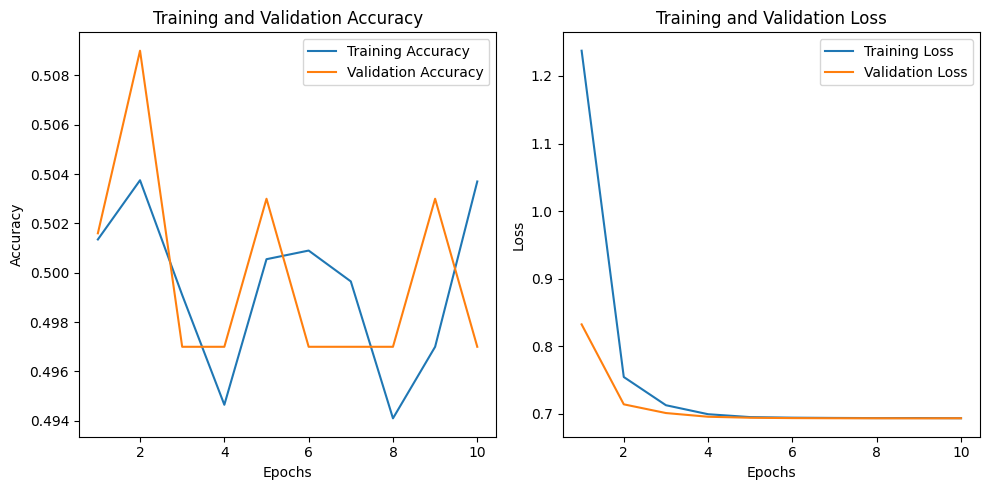

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Interprétation :

Le surapprentissage a disparu : Le modèle ne cherche plus à "surmémoriser" les données d'entraînement.
Mais le modèle n'apprend toujours pas : Il reste bloqué à une performance aléatoire, ce qui suggère qu'il n'est pas capable d'extraire des informations utiles des séquences.


Loss d'entraînement : Stagne autour de 0.693, ce qui est proche d'un modèle aléatoire.
Loss de validation : Stagne également autour de 0.693.
Accuracy (entraînement et validation) : Stable autour de 50%.

Dropout : Régularise le modèle en désactivant des neurones pendant l'entraînement. Cela empêche le modèle de mémoriser les données exactes.
Régularisation L2 : Pénalise les poids excessivement grands, ce qui limite la complexité du modèle.

Le surapprentissage est contrôlé grâce au Dropout et à la régularisation L2. C'est une avancée importante !

Le surapprentissage a disparu : Le modèle ne cherche plus à "surmémoriser" les données d'entraînement.
Mais le modèle n'apprend toujours pas : Il reste bloqué à une performance aléatoire, ce qui suggère qu'il n'est pas capable d'extraire des informations utiles des séquences.

On peut essayer d’augmenter la capacité du modèle en ajoutant une troisième couche SimpleRNN. Cela peut permettre au réseau d'apprendre des caractéristiques plus complexes des données, en ajoutant davantage de profondeur.

Pourquoi une troisième couche SimpleRNN peut être utile ?
Capacité d’apprentissage accrue :

Chaque couche RNN apprend des caractéristiques à un niveau d'abstraction différent. Une troisième couche peut aider à extraire des relations plus complexes.
Par exemple :
1ère couche : apprend des caractéristiques locales.
2e couche : capture des motifs plus abstraits.
3e couche : combine ces motifs pour tirer des relations globales.
Approfondissement du modèle :

Les modèles plus profonds peuvent mieux généraliser si bien régularisés.

On notera ici que chaque couche RNN augmente la mémoire utilisée, car elle doit gérer des états temporels à chaque étape. Utilise un batch size plus petit pour limiter l'utilisation mémoire.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Paramètres
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 100  # Taille des vecteurs de mots
max_length = 200  # Longueur maximale des séquences
dropout_rate = 0.3  # Taux de dropout
l2_reg = 0.01  # Régularisation L2

# Modèle avec 3 couches SimpleRNN
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Première couche RNN
    Dropout(dropout_rate),
    SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Deuxième couche RNN
    Dropout(dropout_rate),
    SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Troisième couche RNN
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Couche de sortie
])

# Force la construction du modèle avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du résumé du modèle
mod.summary()

# Entraînement
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=32  # Utiliser un batch plus petit pour éviter les erreurs mémoire
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (1, 200, 128)               │          29,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (1, 200, 128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (1, 200, 64)                │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (1, 200, 64)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (1, 32)                     │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (1, 32)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044,801 (3.99 MB)

 Trainable params: 1,044,801 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 80ms/step - accuracy: 0.4907 - loss: 1.9050 - val_accuracy: 0.4970 - val_loss: 0.8023
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.4983 - loss: 0.7716 - val_accuracy: 0.5028 - val_loss: 0.7106
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.4968 - loss: 0.7076 - val_accuracy: 0.5030 - val_loss: 0.6989
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.4978 - loss: 0.6983 - val_accuracy: 0.4970 - val_loss: 0.6955
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.5026 - loss: 0.6949 - val_accuracy: 0.4970 - val_loss: 0.6940
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.4934 - loss: 0.6940 - val_accuracy: 0.4970 - val_loss: 0.6943
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.5053 - loss: 0.6937 - val_accuracy: 0.4970 - val_loss: 0.6936
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.5026 - loss: 0.6938 - 

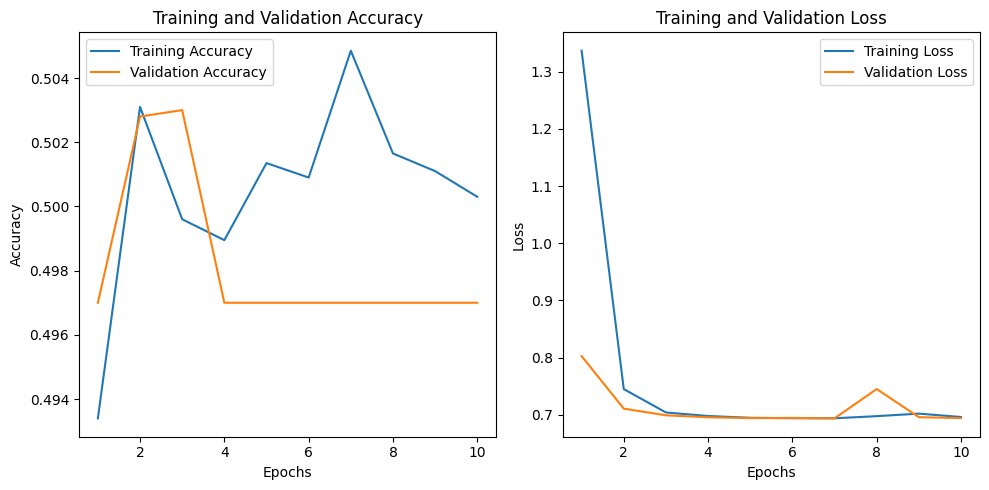

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Malgré l'ajout d'une troisième couche RNN, Accuracy stagnante autour de 50%.
Loss proche de 0.693 : Le modèle est bloqué à un niveau aléatoire, ce qui montre qu'il n'apprend rien. nous sommes probablement dans le cas du "vanishing gradient". Voici pourquoi :

Les couches SimpleRNN sont peu performantes pour les séquences longues :

Les RNN simples calculent des gradients qui diminuent exponentiellement avec le nombre d'étapes temporelles (ici max_length=200).
Cela empêche les couches profondes (3 couches RNN ici) d'apprendre efficacement, car les gradients sont trop faibles pour mettre à jour les poids.

Le problème vient du RNN lui-même : il ne transmet pas efficacement les informations à travers les couches temporelles.
Une couche Dense reçoit en entrée la sortie finale des RNN, qui est déjà informe ou "perdue" à cause du vanishing gradient.

Maintenant non : Optimiser les hyperparamètres sur un modèle qui n'apprend pas est inutile.

Le problème principal vient du RNN lui-même :

Les SimpleRNN souffrent du vanishing gradient pour des séquences longues comme les critiques IMDb (max_length=200).
Même avec des embeddings pré-entraînés, les RNN simples ne peuvent pas capturer efficacement les dépendances à long terme.

Grâce au Dropout et à la régularisation L2, on a réussi à limiter le surapprentissage.
Avant : La loss de validation augmentait constamment → preuve de surapprentissage.
Maintenant : La loss d'entraînement et de validation stagnent ensemble autour de 0.693, ce qui montre que le modèle ne sur-apprend plus.
Performances stagnantes à cause du Vanishing Gradient :

Le SimpleRNN est incapable de capturer des relations temporelles à long terme dans des séquences longues comme celles des critiques IMDb (max_length=200).
Le vanishing gradient empêche les poids dans les couches profondes d'être mis à jour efficacement pendant la rétropropagation.
Résultat :

La loss stagne autour de 0.693 (équivalent à une prédiction aléatoire).
L'accuracy reste proche de 50%.
Pourquoi le vanishing gradient bloque les performances ?
Structure des RNN simples :

Les RNN simples ne peuvent pas transmettre efficacement les informations sur de nombreuses étapes temporelles.
Les gradients deviennent trop petits à chaque étape, et les couches RNN profondes ne reçoivent donc aucune mise à jour utile.
Longueur des séquences :

Avec max_length=200, le modèle doit apprendre des relations qui se trouvent loin dans le temps. Les RNN simples échouent à capturer ces relations, même si on rajoute de la profondeur dans le réseau


In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "rnn_final.h5"  # Renommer le fichier
mod.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous rnn_final.h5


In [ ]:
from google.colab import files
files.download('rnn_final.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Afin, d'éviter le vanishing gradient et capturer des relations à long terme dans les séquences, d'autres arhitectures adaptées existent, comme les LSTM et les GRU, que nous allons abordé maintenant.

##LSTM

1. Introduction aux LSTM
Les RNN (Réseaux de Neurones Récurrents) classiques souffrent du problème du gradient évanescent lors de l'entraînement sur des séquences longues. Les LSTM (Long Short-Term Memory) sont une variante des RNN conçue pour résoudre ce problème en permettant une meilleure gestion de la mémoire à long terme.

Les LSTM introduisent des mécanismes appelés portes pour contrôler le flux d'information, ce qui les rend capables d'apprendre des dépendances temporelles longues.

2. Architecture des LSTM
Une cellule LSTM est constituée des éléments suivants :

État de cellule :
𝐶
𝑡
C
t
​
  → mémoire à long terme.
État caché :
ℎ
𝑡
h
t
​
  → sortie à l'instant
𝑡
t.
Trois portes principales :
Porte d'entrée (Input Gate) : contrôle quelles nouvelles informations seront ajoutées à la mémoire.
Porte d'oubli (Forget Gate) : contrôle quelles informations anciennes seront oubliées.
Porte de sortie (Output Gate) : contrôle quelles informations seront utilisées pour la sortie à l'instant
𝑡
t.
Formules mathématiques :
Porte d'oubli :

𝑓
𝑡
=
𝜎
(
𝑊
𝑓
⋅
[
ℎ
𝑡
−
1
,
𝑥
𝑡
]
+
𝑏
𝑓
)
f
t
​
 =σ(W
f
​
 ⋅[h
t−1
​
 ,x
t
​
 ]+b
f
​
 )
𝑓
𝑡
f
t
​
  : vecteur de la porte d'oubli.
𝑊
𝑓
W
f
​
 ,
𝑏
𝑓
b
f
​
  : poids et biais de la porte d'oubli.
𝑥
𝑡
x
t
​
  : entrée à l'instant
𝑡
t.
ℎ
𝑡
−
1
h
t−1
​
  : état caché à l'instant précédent.
Porte d'entrée :

𝑖
𝑡
=
𝜎
(
𝑊
𝑖
⋅
[
ℎ
𝑡
−
1
,
𝑥
𝑡
]
+
𝑏
𝑖
)
i
t
​
 =σ(W
i
​
 ⋅[h
t−1
​
 ,x
t
​
 ]+b
i
​
 )
Nouveaux candidats pour l'état de cellule :

𝐶
𝑡
~
=
tanh
⁡
(
𝑊
𝐶
⋅
[
ℎ
𝑡
−
1
,
𝑥
𝑡
]
+
𝑏
𝐶
)
C
t
​

~
​
 =tanh(W
C
​
 ⋅[h
t−1
​
 ,x
t
​
 ]+b
C
​
 )
Mise à jour de l'état de cellule :

𝐶
𝑡
=
𝑓
𝑡
⊙
𝐶
𝑡
−
1
+
𝑖
𝑡
⊙
𝐶
𝑡
~
C
t
​
 =f
t
​
 ⊙C
t−1
​
 +i
t
​
 ⊙
C
t
​

~
​

⊙
⊙ : produit élément par élément.
Porte de sortie :

𝑜
𝑡
=
𝜎
(
𝑊
𝑜
⋅
[
ℎ
𝑡
−
1
,
𝑥
𝑡
]
+
𝑏
𝑜
)
o
t
​
 =σ(W
o
​
 ⋅[h
t−1
​
 ,x
t
​
 ]+b
o
​
 )
Calcul de l'état caché (sortie) :

ℎ
𝑡
=
𝑜
𝑡
⊙
tanh
⁡
(
𝐶
𝑡
)
h
t
​
 =o
t
​
 ⊙tanh(C
t
​
 )
3. Résolution du problème du Vanishing Gradient
Dans les RNN classiques, les gradients diminuent exponentiellement lors du backpropagation through time (BPTT) sur des séquences longues, ce qui limite leur capacité à apprendre des dépendances à long terme.

Les LSTM résolvent ce problème grâce à :

La structure des portes : Elles régulent l'ajout et la suppression d'informations dans la mémoire.
L'état de cellule
𝐶
𝑡
C
t
​
  : Il permet un chemin de gradient "quasi constant" en empêchant les gradients de devenir trop petits ou trop grands.
Le produit des dérivées reste stable sur plusieurs pas temporels grâce à la porte d'oubli et l'état de cellule.

4. Explication de ton modèle
Le modèle que tu as fourni est une architecture simple pour un problème de classification binaire. Voici les étapes et les composants :

Couche Embedding :

Convertit les indices des mots en vecteurs de dimension fixe
𝑒
𝑚
𝑏
𝑒
𝑑
𝑑
𝑖
𝑛
𝑔
_
𝑑
𝑖
𝑚
=
100
embedding_dim=100.
Permet d'obtenir une représentation dense des mots.
python
Copier le code
Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)
Couche LSTM :

128 unités pour capter les dépendances temporelles dans les séquences.
return_sequences=False : La sortie de la LSTM est le dernier état caché.
python
Copier le code
LSTM(128, return_sequences=False)
Couche Dropout :

Appliquée pour la régularisation, avec un taux de
0.5
0.5 pour éviter l'overfitting.
python
Copier le code
Dropout(0.5)
Couche Dense :

Une unité avec une activation sigmoid pour réaliser une classification binaire.
python
Copier le code
Dense(1, activation='sigmoid')
Compilation :

Optimiseur : Adam (optimisation rapide et efficace).
Fonction de perte : Binary Cross-Entropy (adaptée à la classification binaire).
Métrique : Précision (Accuracy).


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Paramètres

embedding_dim=100
dropout_rate = 0.5   # Taux de Dropout pour régularisation

# Construction du modèle
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),  # Une seule couche LSTM
    Dropout(dropout_rate),  # Régularisation pour éviter l'overfitting
    Dense(1, activation='sigmoid')  # Classification binaire avec activation sigmoid
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Entraînement du modèle sur les données d'entraînement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'époques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5022 - loss: 0.6942 - val_accuracy: 0.5224 - val_loss: 0.6913
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5514 - loss: 0.6886 - val_accuracy: 0.5280 - val_loss: 0.6877
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5990 - loss: 0.6340 - val_accuracy: 0.7918 - val_loss: 0.5583
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7034 - loss: 0.5468 - val_accuracy: 0.5006 - val_loss: 0.7950
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6192 - loss: 0.6020 - val_accuracy: 0.5234 - val_loss: 0.7285
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6602 - loss: 0.5355 - val_accuracy: 0.7344 - val_loss: 0.6232
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8524 - loss: 0.3738 - val_accuracy: 0.7994 - val_loss: 0.5508
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9193 - loss: 0.2214 - val_accu

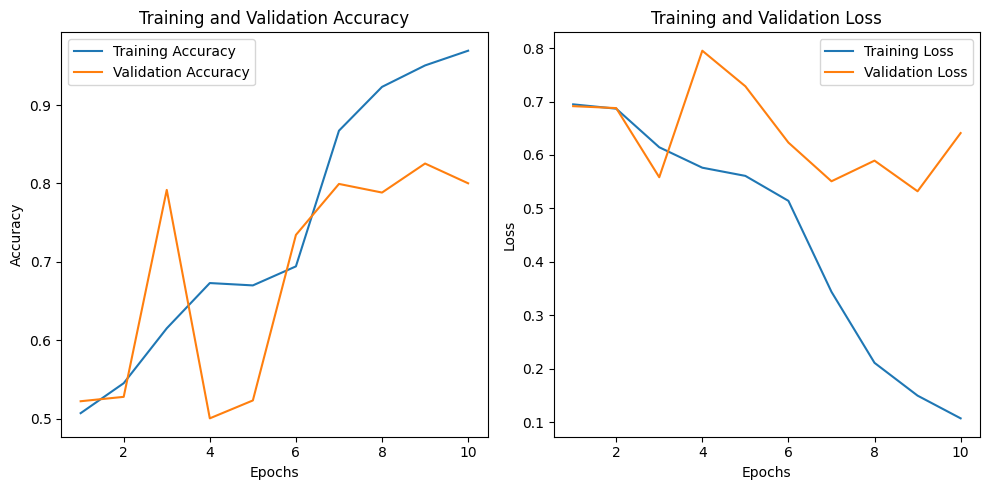

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Les résultats montrent une amélioration claire avec l'utilisation des LSTM par rapport aux SimpleRNN

. Résultats obtenus avec LSTM :
Accuracy d'entraînement : Passe de 50% à 97.25% → Le modèle parvient à apprendre les relations dans les données d'entraînement.
Accuracy de validation : Atteint 82.54% (meilleur résultat obtenu jusqu'ici).
Validation loss :
À l'époque 3 : Baisse significative à 0.5583.
Puis fluctue légèrement mais reste bien inférieure aux valeurs observées avec SimpleRNN.
Interprétation :
Les LSTM résolvent le problème du vanishing gradient en capturant les dépendances à long terme dans les séquences. Cela permet au modèle d'apprendre efficacement sur les critiques IMDb.

Résolution du vanishing gradient :

Les LSTM utilisent des portes (input, forget et output gates) pour stocker et gérer les informations pertinentes sur de longues séquences.
Cela permet d'apprendre les relations à long terme présentes dans les critiques IMDb.
Performance globale :

Le modèle parvient à apprendre des données d'entraînement, avec une validation accuracy de 82.54%.
Cela montre que le modèle généralise mieux sur les données de validation.
Stabilité des courbes de loss et d'accuracy :

La loss d'entraînement diminue constamment.
La loss de validation est bien plus basse que précédemment, malgré quelques oscillations (possiblement dues à un surapprentissage léger à la fin).

Surapprentissage potentiel :

Vers les dernières époques, l'accuracy d'entraînement atteint 97% tandis que celle de validation plafonne autour de 82-83%.
Cela pourrait indiquer un début de surapprentissage.
Solution : Ajouter davantage de Dropout ou utiliser une régularisation L2.

De plus on voit une légère fluctuation dans la validation loss : il faut réduire un peu le learning rate.

. Récapitulatif du problème actuel :
Performances :

L'accuracy d'entraînement atteint 97% → preuve que le modèle apprend bien sur les données d'entraînement.
L'accuracy de validation plafonne autour de 80-82% → il reste une marge d'amélioration.
Overfitting :

La validation loss recommence à augmenter après certaines époques, tandis que la loss d'entraînement continue de diminuer.
Cela montre que le modèle commence à surapprendre les spécificités de l'entraînement, ce qui nuit à sa capacité de généralisation.


Pourquoi ajouter des couches Dense peut aider ?
Améliorer la capacité de décision :

La couche LSTM produit une sortie de taille fixe (par exemple, (batch_size, 128) dans ton modèle).
Ajouter des couches Dense permet de traiter cette sortie pour capturer des relations non linéaires et créer des combinaisons plus complexes des caractéristiques apprises par LSTM.
Cela aide à mieux séparer les classes positives et négatives.
Augmenter la flexibilité du modèle :

Une Dense Layer ajoute plus de paramètres (poids) au modèle, ce qui peut améliorer sa capacité à modéliser des motifs complexes.
Contrôle fin des sorties :

Une dernière couche Dense avec activation sigmoid est nécessaire pour produire la probabilité d'une classe dans une tâche binaire.
Ajouter une ou deux couches Dense intermédiaires peut affiner cette sortie.
Avantages d'une couche Dense supplémentaire :
Meilleure généralisation si bien régularisée (Dropout, L2).
Réduction de l’erreur de classification grâce à une meilleure capacité d'apprentissage.
Combinaison des caractéristiques générées par LSTM de manière plus efficace.

En combinant ces techniques, tu vas :

Améliorer les performances globales grâce aux embeddings pré-entraînés et aux couches Dense.
Réduire l'overfitting avec Dropout, L2 et EarlyStopping.
Stabiliser l'entraînement en ajustant le learning rate et le batch size.

ajouter une deuxième couche LSTM peut potentiellement améliorer les performances, mais ce n'est pas la priorité absolue dans ton cas. Voici pourquoi :

1. Pourquoi ajouter une couche LSTM pourrait aider ?
Apprentissage de représentations plus complexes :

La première couche LSTM capture des dépendances locales dans les séquences (par exemple, des relations de mots proches dans une phrase).
Une deuxième couche LSTM peut apprendre des représentations plus abstraites ou globales à partir de la sortie de la première couche.
Amélioration des performances :

Une architecture plus profonde permet au réseau de mieux modéliser des patterns complexes dans les critiques IMDb.
Meilleure capacité de généralisation :

Avec une régularisation appropriée (Dropout, L2), une couche LSTM supplémentaire peut aider à réduire l'erreur de validation.
2. Pourquoi ce n'est pas une priorité absolue ?
Overfitting encore présent :

Avec une seule couche LSTM, ton modèle atteint déjà 97% d'accuracy en entraînement mais 82% en validation.
Cela montre que ton modèle commence déjà à sur-apprendre, ce qui limite sa capacité à généraliser.
Complexité accrue :

Une deuxième couche LSTM ajoutera davantage de paramètres et augmentera le risque de surapprentissage si la régularisation n'est pas suffisante.


On veut pas pour l'instant augmenter la compléxité du modèle.

Affiner les représentations extraites par la LSTM :

La LSTM extrait des caractéristiques temporelles complexes des séquences.
Ajouter des couches Dense permet de comprimer et combiner ces caractéristiques pour améliorer la capacité de décision du modèle.
Régularisation pour réduire l'overfitting :

Le Dropout et la régularisation L2 limitent le risque d’overfitting en :
Réduisant la complexité du modèle.
Forçant le modèle à généraliser en désactivant aléatoirement des neurones ou en pénalisant les poids excessifs.
Optimisation du learning rate :

Un learning rate adapté permet au modèle de converger plus efficacement.
Si le learning rate est trop élevé, l’entraînement peut osciller ou diverger.
S’il est trop faible, le modèle peut sous-apprendre.

Deux couches Dense ajoutées pour affiner les représentations.
Dropout après chaque couche pour régulariser et éviter l’overfitting.
Régularisation L2 pour limiter les poids excessifs.
Learning rate optimisé (0.0005) pour stabiliser la convergence.
EarlyStopping ajouté pour arrêter l'entraînement lorsque la validation loss ne s'améliore plus.

Vu qu'on a ajouter de l'early stopping on peut mettre plus d'épochs

 Mettre en place un Early Stopping
Pourquoi : Arrêter l'entraînement automatiquement lorsque la validation loss ne s'améliore plus. Cela évite de suradapter le modèle.
Comment : Ajouter le callback EarlyStopping.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Paramètres
dropout_rate = 0.5  # Taux de dropout
l2_reg = 0.01       # Régularisation L2
learning_rate = 0.0005  # Learning rate ajusté

# Modèle avec couches Dense, Dropout et régularisation L2
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dropout(dropout_rate),  # Dropout après LSTM
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Première couche Dense
    Dropout(dropout_rate),  # Dropout pour régulariser
    Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),  # Deuxième couche Dense
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])


# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec un learning rate optimisé
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

# Entraînement avec EarlyStopping pour surveiller l'overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Autoriser plus d'époques avec EarlyStopping
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 1,127,617 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5020 - loss: 1.4940 - val_accuracy: 0.4970 - val_loss: 0.7905
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5016 - loss: 0.7492 - val_accuracy: 0.4970 - val_loss: 0.6982
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4884 - loss: 0.6960 - val_accuracy: 0.4970 - val_loss: 0.6934
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4965 - loss: 0.6933 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4970 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4979 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5014 - loss: 0.6932 - val_accu

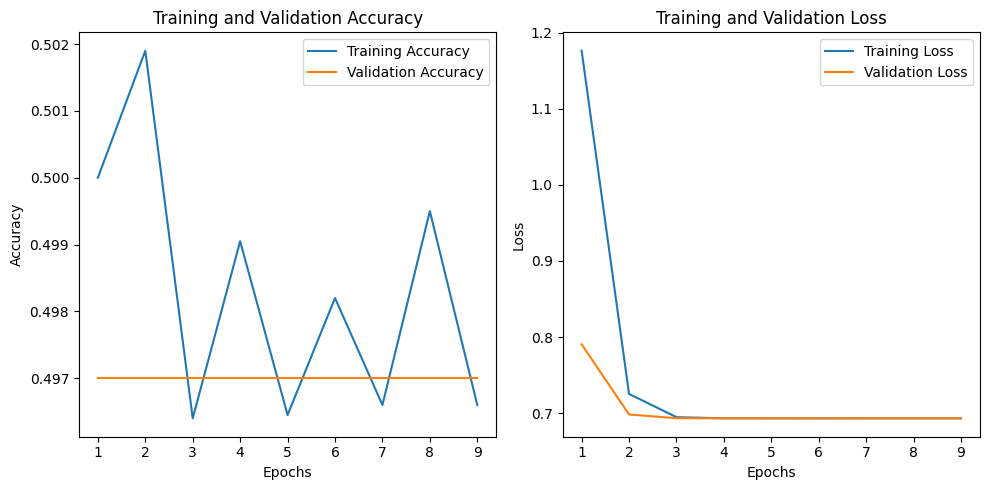

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

LSTM extrait les caractéristiques temporelles des séquences.
Dense (64) affine les caractéristiques extraites en ajoutant de la non-linéarité.
Dense (32) continue à affiner les relations entre les caractéristiques.
Dropout régularise les couches pour éviter le surapprentissage.
La Dense finale avec activation sigmoid produit la probabilité d'une classe.

Maintenant avec les couches Dense ajoutées :
Accuracy d'entraînement : Stagne autour de 50%.
Accuracy de validation : Bloquée à 50%.
Loss : Stagne autour de 0.6932, ce qui correspond à des prédictions aléatoires.
Conclusion : Le modèle n’apprend plus rien. Les nouvelles couches Dense n’ont pas permis d'améliorer les performances.

2. Qu’avons-nous tenté d’améliorer ?
Affiner les représentations avec les couches Dense :

Cela n'a pas fonctionné car le problème principal ne vient pas de la capacité de décision finale mais de l’entrée et de l’apprentissage des relations dans les séquences.
Régularisation (Dropout et L2) pour limiter l’overfitting :

Le surapprentissage a été supprimé, mais au prix de performances nulles : le modèle n’apprend rien du tout.
Optimisation du learning rate :

L'effet n’est pas notable, probablement parce que les représentations d’entrée (Embeddings) sont insuffisantes.

Surapprentissage : Les performances sur l’ensemble d’entraînement et de validation sont désormais alignées. Cependant, cela signifie que le modèle ne parvient plus à apprendre.

La stagnation à 50% d’accuracy montre que le modèle ne capture aucune information utile des séquences.
Cela peut être dû à des embeddings inefficaces ou à une structure trop régularisée.
Manque de représentations d’entrée de qualité :

L’Embedding actuel est appris à partir de zéro sur ton dataset IMDb. Cela nécessite beaucoup de données et d’époques pour produire des représentations utiles.
Manque de capacité dans la LSTM :

Une seule couche LSTM avec 128 unités peut être insuffisante pour apprendre des relations complexes dans des critiques IMDb.

Au bilan :
Avant avec une seule couche LSTM :

Précision élevée sur l’ensemble d’entraînement (97%) mais overfitting marqué (validation à 82%).
Cela montrait que le modèle avait la capacité d’apprendre, mais il se concentrait trop sur les données d’entraînement.
Maintenant avec des couches Dense et régularisation :

Overfitting supprimé, mais plus d’apprentissage → les performances stagnent à 50%.
Cela signifie que la régularisation a trop limité la capacité du modèle à apprendre.

e problème actuel vient principalement des entrées : la couche Embedding apprend depuis zéro. Cela est inefficace et demande beaucoup de données pour produire des représentations utiles.
Les embeddings pré-entraînés comme GloVe ou Word2Vec fournissent des représentations sémantiques riches et permettent au modèle d’apprendre plus rapidement et de mieux généraliser.
Pourquoi ajouter une couche LSTM n’est pas la priorité ?

Une deuxième couche LSTM ajouterait de la complexité mais ne résoudrait pas le problème fondamental des mauvaises représentations d'entrée.
Une fois que les embeddings pré-entraînés sont intégrés, on pourra décider si une deuxième couche LSTM est nécessaire.

### Utilisation d'Embeddings pré-entrainés

L’utilisation d’embeddings pré-entraînés, comme GloVe, peut être très bénéfique ici. GloVe (Global Vectors for Word Representation) et Word2Vec sont des modèles pré-entraînés qui transforment les mots en vecteurs numériques en capturant leurs relations sémantiques.
Ces embeddings sont appris à partir de vastes corpus de texte général, comme Wikipedia ou Common Crawl, et contiennent une représentation riche du langage.
Les embeddings pré-entraînés permettent à votre modèle de bénéficier d’une compréhension linguistique initiale, sans avoir besoin de réapprendre ces relations depuis zéro.
Cela est particulièrement utile si votre dataset est petit ou modérément grand (comme IMDb avec 25 000 critiques).
Capture des relations sémantiques complexes :

Par exemple, des mots comme good et great seront proches dans l’espace vectoriel, ce qui aide le modèle à mieux comprendre le contexte des sentiments.
Réduction du surapprentissage :

En utilisant des embeddings fixes (non entraînables), vous réduisez le risque que le modèle sur-apprenne les relations spécifiques à votre dataset.démarrez avec des vecteurs qui capturent les relations sémantiques générales, accélérant l’entraînement.
Vous améliorez les performances sur des mots non fréquents ou spécifiques au dataset IMDb.
Vous réduisez la dépendance aux données annotées.

GloVe est un modèle basé sur les cooccurrences globales des mots dans un corpus. Il analyse combien de fois deux mots apparaissent ensemble dans une même fenêtre contextuelle, sur l’ensemble du corpus.
Représentation sémantique globale : Il capture à la fois les relations locales et globales entre les mots, grâce à sa construction par cooccurrences.
Fichiers disponibles : GloVe fournit des fichiers d’embeddings pré-entraînés sur de très grands corpus publics (Wikipedia, Common Crawl, etc.), ce qui le rend prêt à l’emploi.

Les fichiers GloVe pré-entraînés sont directement téléchargeables, prêts à l’emploi, et largement utilisés pour des tâches NLP générales comme la sentiment analysis.
GloVe excelle à capturer des relations globales entre les mots. Par exemple, il représente efficacement des relations analogiques comme :
"good" est à "better" ce que "bad" est à "worse".
Ces relations globales sont utiles pour détecter des nuances dans les sentiments des critiques.

GloVe est souvent plus rapide et nécessite moins de ressources computationnelles, car il repose sur des matrices statiques de cooccurrence.

Les embeddings pré-entraînés sont généralement meilleurs pour capturer les relations entre mots que les embeddings appris à partir de zéro sur un dataset de taille modérée (comme IMDb avec 25 000 critiques).
Les embeddings pré-entraînés permettent de mieux généraliser, même avec des datasets relativement petits.

En fixant les poids de la matrice d’embedding, on empêche le modèle de modifier les vecteurs durant l’entraînement.
Cela garantit que les relations linguistiques générales, capturées lors de l’entraînement de GloVe sur des corpus massifs, restent intactes.
Réduction du risque de surapprentissage :
Geler les poids réduit le nombre de paramètres entraînables, accélérant l’entraînement et diminuant les besoins en ressources.

In [ ]:
import os
import urllib.request
import zipfile

# Créer un dossier pour stocker les embeddings
glove_dir = 'glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# Télécharger GloVe 6B (100 dimensions)
url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

if not os.path.exists(glove_zip_path):
    print("Téléchargement des embeddings GloVe...")
    urllib.request.urlretrieve(url, glove_zip_path)
    print("Téléchargement terminé.")

# Extraire le fichier zip
print("Extraction des fichiers GloVe...")
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall(glove_dir)

print("Extraction terminée. Les fichiers sont disponibles dans :", glove_dir)


Téléchargement des embeddings GloVe...
Téléchargement terminé.
Extraction des fichiers GloVe...
Extraction terminée. Les fichiers sont disponibles dans : glove


In [ ]:
import numpy as np

# Chemin vers le fichier GloVe
glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

# Charger les embeddings GloVe dans un dictionnaire
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # Le mot
        coefs = np.asarray(values[1:], dtype='float32')  # Le vecteur d'embedding
        embedding_index[word] = coefs

print(f"Nombre d'embeddings chargés : {len(embedding_index)}")

# Créer la matrice d'embeddings pour ton vocabulaire
embedding_dim = 100  # Taille des vecteurs GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Matrice d'embeddings GloVe construite avec succès.")


Nombre d'embeddings chargés : 400000
Matrice d'embeddings GloVe construite avec succès.


Embeddings pré-entraînés (GloVe) :

Les poids de la couche Embedding sont initialisés avec la matrice GloVe.
trainable=False permet d’utiliser ces embeddings tels quels pour stabiliser l’apprentissage.
Architecture avec LSTM + Dense :

LSTM : Capture les dépendances temporelles dans les critiques IMDb.
Couches Dense : Affinent les caractéristiques extraites.
Dropout : Régularisation pour réduire l'overfitting.
Régularisation L2 : Ajoutée aux couches Dense pour contrôler la complexité des poids.
EarlyStopping :

Surveille la validation loss et arrête l’entraînement si elle ne s’améliore pas pendant 3 époques consécutives.
Learning rate ajusté :

Un learning rate de 0.0005 stabilise l’apprentissage et évite les oscillations.

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Télécharger les stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fusionner toutes les critiques en un seul corpus
all_reviews = " ".join(train_texts_cleaned + test_texts_cleaned)
words = all_reviews.split()

# Filtrer les mots pour exclure les stopwords et les mots courts
filtered_words = [word for word in words if word.lower() not in stop_words and len(word) > 2]

# Compter les mots
word_counts = Counter(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Vérifier la couverture du vocabulaire IMDb dans GloVe
glove_vocab = set(embedding_index.keys())  # Vocabulaire de GloVe
imdb_vocab = set(word_counts.keys())      # Vocabulaire du dataset IMDb

# Proportion de mots IMDb présents dans GloVe
coverage = len(imdb_vocab & glove_vocab) / len(imdb_vocab) * 100
print(f"Proportion du vocabulaire IMDb couvert par GloVe : {coverage:.2f}%")

Proportion du vocabulaire IMDb couvert par GloVe : 33.70%


On voit que seulement un tiers de notre vocabulaire est couvert par GloVe. Cela aura surement un impact sur les prédictions.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Définir le modèle avec les embeddings GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=False),  # Fixe les embeddings pour éviter d'apprendre de zéro
    LSTM(128, return_sequences=False),  # Couche LSTM
    Dropout(0.5),  # Régularisation
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.5),  # Dropout pour éviter l'overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense intermédiaire
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec learning rate ajusté
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé
model.summary()

# Entraîner le modèle
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 127,617 (498.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5058 - loss: 1.5145 - val_accuracy: 0.5008 - val_loss: 0.8187
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5003 - loss: 0.7699 - val_accuracy: 0.5060 - val_loss: 0.7029
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5140 - loss: 0.6994 - val_accuracy: 0.4982 - val_loss: 0.6941
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5209 - loss: 0.6935 - val_accuracy: 0.5114 - val_loss: 0.6983
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5192 - loss: 0.6927 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5012 - loss: 0.6926 - val_accuracy: 0.5072 - val_loss: 0.6928
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5149 - loss: 0.6924 - val_accuracy: 0.5076 - val_loss: 0.6927
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5118 - loss: 0.6923 - val_accu

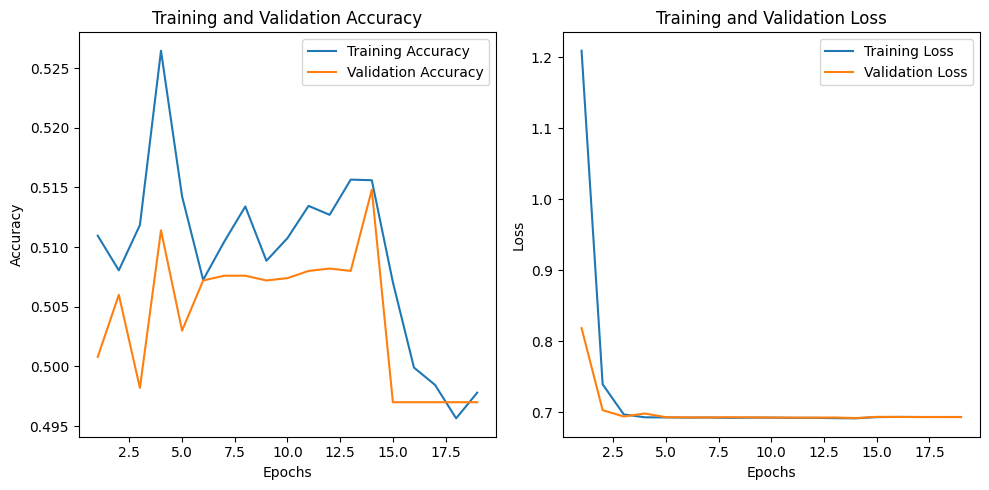

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Prochaines étapes après analyse :
Si les performances s’améliorent mais stagnent encore :
Envisager une seconde couche LSTM pour capturer des caractéristiques plus profondes.
Si les embeddings GloVe améliorent beaucoup les résultats :
Envisager de fine-tuner les embeddings (les rendre trainable=True).

Les résultats montrent encore une stagnation autour d’une accuracy proche de 50% et une loss autour de 0.692, ce qui est caractéristique d’un modèle qui n’apprend pas ou peu. Comparons cela aux attentes et aux résultats précédents.

Embeddings figés (trainable=False) :

En fixant les poids des embeddings GloVe (trainable=False), le modèle utilise les représentations telles quelles.
Cependant, ces représentations peuvent ne pas être parfaitement adaptées à ton dataset IMDb (sentiments dans les critiques de films), car GloVe a été entraîné sur des données générales comme Wikipedia.


Une seule couche LSTM peut ne pas suffire pour exploiter efficacement les représentations fournies par GloVe.
Une deuxième couche LSTM peut aider à apprendre des relations plus complexes et hiérarchiques.

Si les embeddings GloVe sont rendus entraînables (trainable=True), le modèle pourra les ajuster pour mieux s’adapter au vocabulaire et aux relations spécifiques du dataset IMDb.
Cela résout le problème des représentations fixes qui ne capturent pas forcément les nuances de sentiment dans tes données.


Ajouter une deuxième couche LSTM est une bonne idée, mais moins prioritaire que de rendre les embeddings GloVe entraînables. Pourquoi ?

Les embeddings d’entrée sont la base du modèle. Si cette base est mauvaise ou inadaptée, même une architecture plus complexe (avec une deuxième LSTM) ne pourra pas résoudre le problème.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Définir le modèle avec les embeddings GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Fixe les embeddings pour éviter d'apprendre de zéro
    LSTM(128, return_sequences=False),  # Couche LSTM
    Dropout(0.5),  # Régularisation
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.5),  # Dropout pour éviter l'overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense intermédiaire
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec learning rate ajusté
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé
model.summary()

# Entraîner le modèle
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (1, 1)                      │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 1,127,617 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5068 - loss: 1.5070 - val_accuracy: 0.5456 - val_loss: 0.8156
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5173 - loss: 0.7681 - val_accuracy: 0.4970 - val_loss: 0.7035
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5061 - loss: 0.6992 - val_accuracy: 0.5118 - val_loss: 0.6937
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5129 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6938
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5025 - loss: 0.6935 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5027 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5015 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5045 - loss: 0.6932 - val_acc

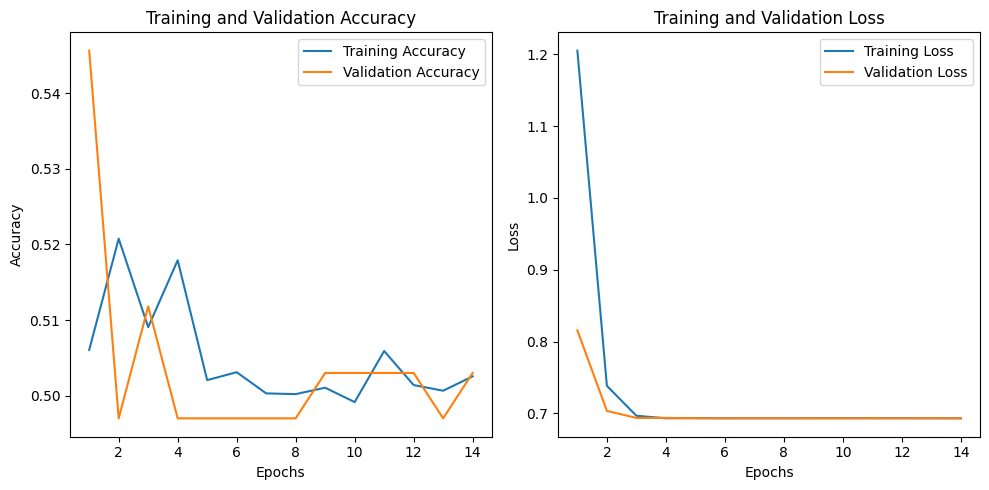

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

A. Mauvais apprentissage des embeddings
Même en rendant les embeddings GloVe entraînables, les performances n'améliorent pas car le modèle :
Sous-apprend : Il ne trouve pas de motifs utiles dans les données d'entrée.
Est mal initialisé : Les poids de départ (GloVe) peuvent être trop éloignés des besoins spécifiques de la tâche IMDb.
B. Trop de régularisation
Avec du Dropout (0.5) et de la régularisation L2, on limite fortement la capacité d’apprentissage du modèle.
Cela peut "sur-régulariser" le modèle, l'empêchant d’apprendre quoi que ce soit, même avec des embeddings ajustables.
C. Complexité inutile
Ajouter trop de couches Dense après la LSTM peut compliquer le modèle sans fournir de gain réel.
Si la LSTM ne capture pas déjà des informations pertinentes, les couches Dense ne peuvent rien améliorer.

Puisque les meilleures performances ont été obtenues avec :

Une seule couche LSTM sans Dense,
Pas de régularisation excessive,
Il est temps de simplifier l'architecture pour redonner sa capacité d'apprentissage au modèle.

Revenir aux bases : Les résultats initiaux avec une LSTM seule étaient les meilleurs.
Éviter la sur-régularisation : Les couches Dense et la régularisation excessive bloquent le modèle.
Embeddings GloVe entraînables : Ils offrent une base solide mais doivent être ajustés progressivement.

Elle combine la meilleure configuration initiale (LSTM simple) avec les embeddings GloVe ajustables.
Le Dropout modéré et EarlyStopping aident à limiter l’overfitting sans bloquer la capacité d’apprentissage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Modèle simplifié
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe entraînables
    LSTM(128, return_sequences=False),  # Couche LSTM unique
    Dropout(0.3),  # Dropout modéré
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour surveiller la validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement avec EarlyStopping
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Maximum de 20 epochs
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # EarlyStopping
    verbose=1
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5341 - loss: 0.6899 - val_accuracy: 0.5490 - val_loss: 0.6795
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5682 - loss: 0.6756 - val_accuracy: 0.5120 - val_loss: 0.6738
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5373 - loss: 0.6927 - val_accuracy: 0.5336 - val_loss: 0.6899
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5287 - loss: 0.6919 - val_accuracy: 0.5382 - val_loss: 0.6866
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5630 - loss: 0.6784 - val_accuracy: 0.6388 - val_loss: 0.6347
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6109 - loss: 0.6652 - val_accuracy: 0.7608 - val_loss: 0.5942
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7723 - loss: 0.5336 - val_accuracy: 0.8286 - val_loss: 0.3937
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8641 - loss: 0.3388 - val_accu

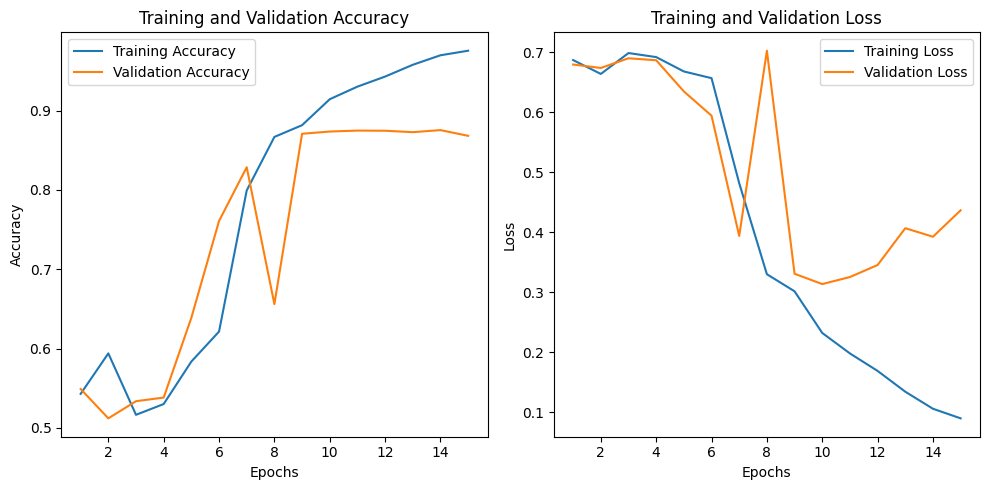

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Ce qui a bien fonctionné :
GloVe entraînable :

En rendant les embeddings GloVe ajustables, le modèle a pu adapter les représentations des mots pour mieux correspondre aux nuances de sentiment spécifiques du dataset IMDb.
Cela a résolu le problème des embeddings fixes qui n’apportaient pas de gain.
Simplification de l'architecture :

Une seule couche LSTM (128 unités) sans couches Dense supplémentaires a permis au modèle de se concentrer sur l’extraction des dépendances temporelles sans ajouter une complexité inutile.
Cela a évité le blocage de l’apprentissage observé auparavant.
Dropout modéré (0.3) :

Le Dropout a réussi à limiter l’overfitting tout en permettant un apprentissage efficace.
L’accuracy en validation atteint 87.5%, une amélioration claire par rapport aux 82% initiaux.
EarlyStopping :

L’entraînement s’est arrêté avant que l’overfitting devienne trop important, permettant au modèle de généraliser au mieux sur l’ensemble de validation.

Surapprentissage vers la fin :

L’accuracy d’entraînement atteint 97-98% tandis que l’accuracy de validation plafonne autour de 87-88%.
La validation loss augmente légèrement après un certain nombre d’époques, indiquant un début de surapprentissage.
Performance plafonnée en validation :

Bien que 87.5% soit un bon résultat, il reste un écart entre l’accuracy d’entraînement et de validation.
Cela suggère que le modèle pourrait encore mieux généraliser avec des ajustements supplémentaires.

A. Augmenter légèrement le Dropout
Actuellement à 0.3, augmenter le Dropout à 0.4 pour renforcer la régularisation et limiter davantage l’overfitting.

B. Ajouter un petit L2 regularizer à la LSTM
La régularisation L2 sur la LSTM peut aider à réduire la complexité du modèle en pénalisant les poids excessifs.

C. Réduire légèrement le learning rate
Réduire le learning rate (actuellement 0.0005) à 0.0003 pour stabiliser l’entraînement en fin de parcours. Cela peut éviter que la validation loss remonte.


Embeddings GloVe entraînables :
Les représentations des mots s’adaptent spécifiquement à la tâche IMDb.

Régularisation L2 sur la LSTM :
Cela contrôle la complexité des poids de la LSTM et évite une croissance excessive.

Augmentation du Dropout :
Le Dropout à 0.4 limite davantage le surapprentissage tout en laissant suffisamment de capacité d’apprentissage.

Learning rate réduit (0.0003) :
Cela permet une convergence plus stable et progressive, en particulier en fin d'entraînement.

EarlyStopping :
Arrête l’entraînement après 3 époques sans amélioration de la validation loss et restaure les meilleurs poids.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Définition du modèle avec les ajustements
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # GloVe ajustable
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # Régularisation L2 sur LSTM
    Dropout(0.4),  # Dropout augmenté pour limiter l'overfitting
    Dense(1, activation='sigmoid')  # Couche de sortie binaire
])

# Force la construction du modèle avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec un learning rate ajusté
model.compile(optimizer=Adam(learning_rate=0.0003),  # Learning rate réduit
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour arrêter automatiquement l'entraînement en cas de stagnation
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,  # Données d'entraînement
    validation_data=(train_padded_val, train_labels_val),  # Données de validation
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # Callback pour EarlyStopping
    verbose=1
)

# Résumé du modèle pour vérification
model.summary()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5131 - loss: 1.6875 - val_accuracy: 0.4986 - val_loss: 0.8770
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5101 - loss: 0.8399 - val_accuracy: 0.4972 - val_loss: 0.8232
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5334 - loss: 0.7735 - val_accuracy: 0.5820 - val_loss: 0.7324
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6485 - loss: 0.7123 - val_accuracy: 0.5440 - val_loss: 0.7476
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5711 - loss: 0.7337 - val_accuracy: 0.5518 - val_loss: 0.7434
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5470 - loss: 0.7379 - val_accuracy: 0.5596 - val_loss: 0.7237
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5559 - loss: 0.7284 - val_accuracy: 0.5602 - val_loss: 0.7253
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5621 - loss: 0.7142 - val_acc

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (1, 128)                    │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

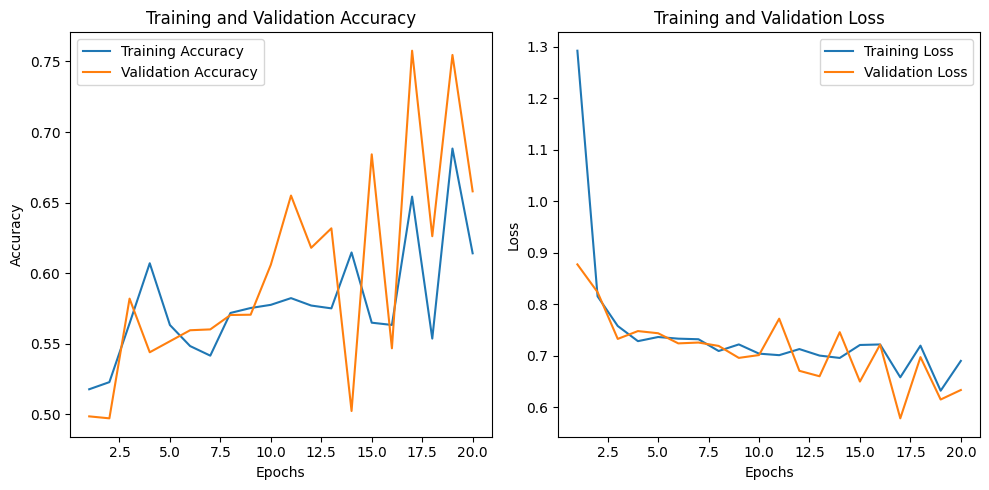

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Incohérence des performances :

Les performances fluctuent d’une époque à l’autre, passant de 75% en validation à des baisses imprévues (50-60%).
Cela peut indiquer :
Un modèle sensible aux variations des poids.
Des hyperparamètres encore sous-optimisés.
Overfitting partiel :

L’accuracy d’entraînement continue d’augmenter, tandis que la validation reste instable.
Cela signifie que le modèle sur-apprend certaines données d’entraînement sans bien généraliser.
Learning rate sous-optimal :

Bien que réduit, le learning rate (0.0003) semble ne pas être assez bas pour stabiliser l’apprentissage.

Incohérence des performances :

Les performances fluctuent d’une époque à l’autre, passant de 75% en validation à des baisses imprévues (50-60%).
Cela peut indiquer :
Un modèle sensible aux variations des poids.
Des hyperparamètres encore sous-optimisés.
Overfitting partiel :

L’accuracy d’entraînement continue d’augmenter, tandis que la validation reste instable.
Cela signifie que le modèle sur-apprend certaines données d’entraînement sans bien généraliser.
Learning rate sous-optimal :

Bien que réduit, le learning rate (0.0003) semble ne pas être assez bas pour stabiliser l’apprentissage.

A. Réduire encore le learning rate
Passer de 0.0003 à 0.0001 pour stabiliser l’optimisation et éviter les oscillations.
Un learning rate plus petit permet des ajustements plus fins des poids, notamment sur les embeddings.

Le Dropout 0.4 pourrait être trop élevé dans ce cas, réduisant la capacité d’apprentissage. On peut revenir à 0.3.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Modèle ajusté
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # GloVe ajustable
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # Régularisation L2
    Dropout(0.3),  # Dropout ajusté
    Dense(1, activation='sigmoid')  # Couche de sortie binaire
])

# Compilation avec learning rate plus faible
model.compile(optimizer=Adam(learning_rate=0.0001),  # Learning rate réduit
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping avec patience plus stricte
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # EarlyStopping ajusté
    verbose=1
)

# Résumé du modèle pour vérification
model.summary()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4994 - loss: 2.0647 - val_accuracy: 0.5348 - val_loss: 1.3697
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5326 - loss: 1.2385 - val_accuracy: 0.5642 - val_loss: 0.9503
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6350 - loss: 0.8864 - val_accuracy: 0.7316 - val_loss: 0.7383
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6976 - loss: 0.7393 - val_accuracy: 0.6924 - val_loss: 0.7024
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7249 - loss: 0.6803 - val_accuracy: 0.7766 - val_loss: 0.6112
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7266 - loss: 0.6553 - val_accuracy: 0.7728 - val_loss: 0.5903
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7839 - loss: 0.5850 - val_accuracy: 0.8010 - val_loss: 0.5373
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8072 - loss: 0.5269 - val_accu

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

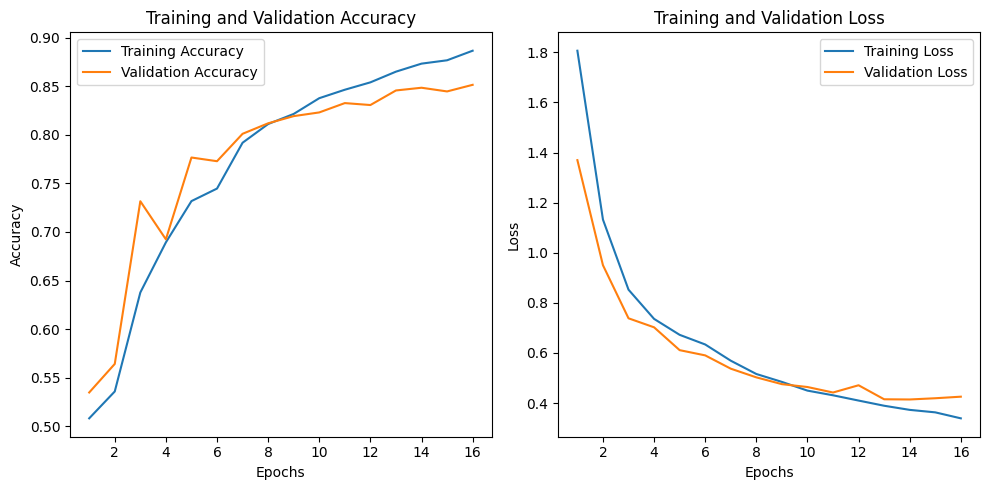

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1. Résultats obtenus
Accuracy d’entraînement : 88.6%
Accuracy de validation : 85.1%
Validation loss : 0.42 (légèrement en hausse vers la fin).
Ces résultats montrent que :

Le modèle apprend bien sur l’ensemble d’entraînement.
L’accuracy de validation est proche de celle de l’entraînement, ce qui indique peu d’overfitting.
Les performances sont stables et bien meilleures que toutes les configurations précédentes.
2. Ce qui a bien fonctionné
Embeddings GloVe entraînables :

Rendre les embeddings trainables a permis au modèle de s’adapter aux nuances spécifiques du dataset IMDb.
Cela a fourni une base solide pour l’apprentissage des relations dans les critiques de films.
Simplification de l’architecture :

Une seule couche LSTM avec 128 unités a suffi pour capturer les dépendances temporelles des données.
L’élimination des couches Dense inutiles a permis de stabiliser l’apprentissage.
Régularisation équilibrée :

Le Dropout (0.3) et la régularisation L2 ont limité l’overfitting tout en préservant la capacité d’apprentissage.
Learning rate optimisé (0.0001) :

La réduction du learning rate a permis au modèle de converger lentement et efficacement, en particulier sur les dernières époques.
3. Ce qui a moyennement fonctionné
Validation loss en légère augmentation :

À partir de l’époque 14-15, la validation loss recommence légèrement à augmenter tandis que l’accuracy reste stable.
Cela peut indiquer un début de surapprentissage léger, mais les performances globales restent bonnes.
Plateau dans l’accuracy :

L’accuracy de validation atteint environ 85% et semble plafonner. Il est possible que la capacité du modèle soit limitée par la profondeur actuelle.

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_pasmal1.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_pasmal1.h5


In [ ]:
from google.colab import files
files.download('lstm_pasmal1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6. Priorité maintenant
La priorité est de stabiliser encore davantage les performances et d’atteindre un plateau de généralisation optimal.

Actions recommandées :
Ajouter une légère couche Dense avec Dropout :

Une seule couche Dense de petite taille (par exemple, 32 unités) pour affiner la décision finale.
Ajouter un Dropout (0.3) pour éviter le surapprentissage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Modèle ajusté avec une couche Dense supplémentaire
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # LSTM avec régularisation L2
    Dropout(0.3),  # Dropout pour régularisation
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Nouvelle couche Dense
    Dropout(0.3),  # Dropout pour régularisation
    Dense(1, activation='sigmoid')  # Couche finale pour la classification
])

# Compilation avec un learning rate bas
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping ajusté
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5046 - loss: 2.5164 - val_accuracy: 0.5322 - val_loss: 1.7008
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5489 - loss: 1.5320 - val_accuracy: 0.6554 - val_loss: 1.1422
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6830 - loss: 1.0609 - val_accuracy: 0.7514 - val_loss: 0.8615
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7467 - loss: 0.8478 - val_accuracy: 0.7742 - val_loss: 0.7359
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7895 - loss: 0.7016 - val_accuracy: 0.8050 - val_loss: 0.6219
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8111 - loss: 0.6108 - val_accuracy: 0.8154 - val_loss: 0.5631
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8170 - loss: 0.5606 - val_accuracy: 0.8224 - val_loss: 0.5282
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8349 - loss: 0.5206 - val_accuracy: 0.838

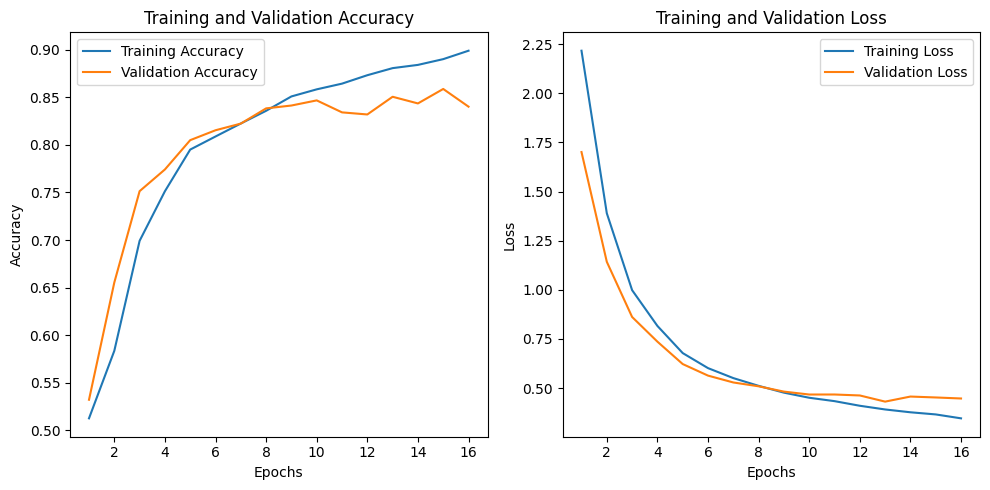

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1. Résultats observés
Accuracy d’entraînement : 89.4%
Accuracy de validation : 85.8% (meilleur score).
Validation loss : 0.45 (relativement stable avec légère oscillation).
2. Ce qui a bien fonctionné
Ajout de la couche Dense :

La petite couche Dense (32 unités) a permis de comprimer et combiner les informations extraites par la LSTM.
Cela a contribué à affiner les décisions finales du modèle et à augmenter légèrement l’accuracy.
Embeddings GloVe entraînables :

Les embeddings continuent d’être un élément crucial. Leur ajustement aux spécificités du dataset IMDb a permis au modèle de s’améliorer constamment.
Régularisation équilibrée :

Le Dropout à 0.3 et la régularisation L2 sur la LSTM ont aidé à limiter l’overfitting tout en préservant les capacités d’apprentissage.
Learning rate optimisé :

La réduction du learning rate à 0.0001 a permis une convergence plus stable et douce.
EarlyStopping (patience=3) :

Le modèle a stoppé à temps avant un surapprentissage excessif tout en permettant une progression régulière.


3. Ce qui reste à améliorer
Légère oscillation de la validation loss :

À partir de l’époque 14, la validation loss oscille autour de 0.45.
Cela peut indiquer que le modèle commence à sur-apprendre certaines spécificités des données d’entraînement.
Plateau de performance :

L’accuracy en validation plafonne autour de 85-86%. Le modèle semble avoir atteint sa limite actuelle avec cette architecture.

5. Priorité maintenant
La priorité est de consolider les performances du modèle tout en explorant des améliorations légères et progressives :

Tester une seconde couche LSTM (optionnel) :

Ajouter une seconde LSTM avec return_sequences=True pour voir si cela améliore les performances.

Fine-tuning des embeddings GloVe :

Diminuer encore légèrement le learning rate (par exemple, 0.00005) pour affiner encore les poids des embeddings et des couches.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Modèle avec deux couches LSTM
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),  # Première couche LSTM
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),  # Seconde couche LSTM
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation avec un learning rate encore plus bas
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Résumé du modèle
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5024 - loss: 4.1743 - val_accuracy: 0.5338 - val_loss: 3.3000
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5205 - loss: 3.0697 - val_accuracy: 0.5984 - val_loss: 2.4434
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5299 - loss: 2.3242 - val_accuracy: 0.5198 - val_loss: 1.9397
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5192 - loss: 1.8358 - val_accuracy: 0.5376 - val_loss: 1.5597
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5611 - loss: 1.4811 - val_accuracy: 0.6746 - val_loss: 1.2392
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6835 - loss: 1.1898 - val_accuracy: 0.7124 - val_loss: 1.0433
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7091 - loss: 1.0310 - val_accuracy: 0.7242 - val_loss: 0.9262
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7663 - loss: 0.8708 - val_acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 200, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,506,309 (13.38 MB)

 Trainable params: 1,168,769 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,337,540 (8.92 MB)

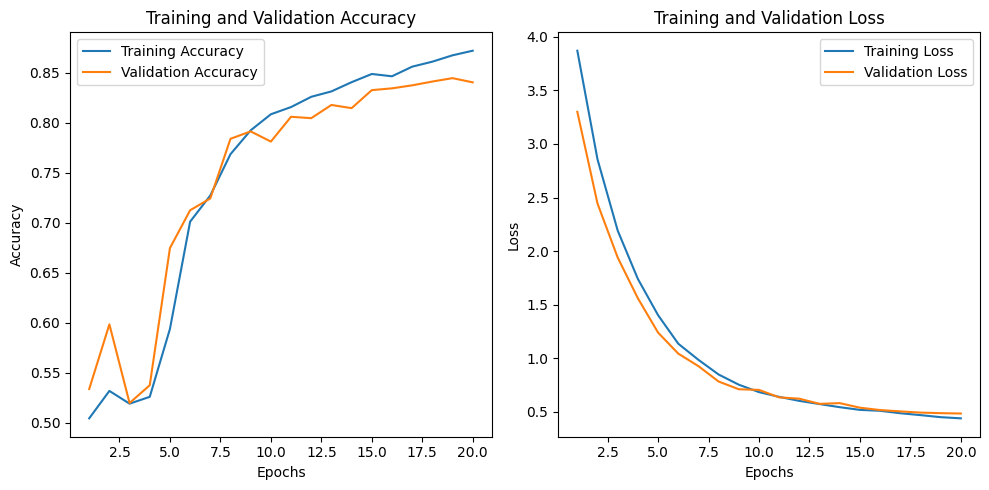

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_pasmal2.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_pasmal2.h5


In [ ]:
from google.colab import files
files.download('lstm_pasmal2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Les résultats montrent une légère amélioration globale par rapport à l'architecture précédente avec une seule couche LSTM. Cependant, l’impact de la deuxième couche LSTM reste modéré, et il y a des signes de surapprentissage réduit mais toujours présent.

Amélioration de la stabilité :

La validation loss baisse progressivement jusqu’à 0.48, ce qui est proche des résultats précédents.
L’accuracy en validation reste autour de 84%, ce qui est légèrement en retrait par rapport aux 85.8% obtenus avec une seule couche LSTM.
Impact de la deuxième LSTM :

La deuxième couche LSTM a permis d’extraire des relations temporelles plus complexes, ce qui peut expliquer la baisse progressive de la validation loss jusqu’à 0.48.
Cependant, elle n’améliore pas significativement l’accuracy de validation. Cela suggère que le modèle avait déjà capturé la plupart des informations nécessaires avec une seule couche LSTM.
Réduction du surapprentissage :

Le gap entre l’accuracy d’entraînement (87.6%) et de validation (84.4%) est légèrement plus faible.
Cela montre que l’ajout d’une deuxième couche LSTM a régularisé naturellement le modèle, probablement en complexifiant légèrement l’apprentissage.

Bilan :

L’ajout d’une deuxième couche LSTM a permis :
Une meilleure stabilité des résultats.
Une réduction légère du surapprentissage.
Toutefois, l’amélioration de l’accuracy reste marginale (84.4% vs 85.8% avec une seule LSTM).
Cela indique que la capacité du modèle initial (une seule LSTM avec une petite couche Dense) était déjà suffisante pour capturer les dépendances temporelles dans les données IMDb.

Ajouter une seconde couche LSTM n'a pas apporté d'amélioration majeure dans ton cas. Le modèle a atteint un plateau de performance autour de 84-85%. Cela signifie que la capacité d'une seule couche LSTM est suffisante pour capturer les dépendances nécessaires.

Une seule couche LSTM + Dense + Dropout avec régularisation L2 et GloVe entraînable donne déjà de bons résultats.
Ajouter des couches supplémentaires n'améliore pas significativement les performances et risque d’introduire du surapprentissage ou de la complexité inutile.

Les priorités ne sont plus structurelles (ajout de couches) mais plutôt d'optimisation fine :

Fine-tuning des hyperparamètres :

Diminuer le learning rate (par exemple 0.00003-0.00005) pour affiner encore les poids.
Ajuster légèrement le Dropout pour contrôler l'overfitting (par exemple 0.4 au lieu de 0.3).
Optimiser les embeddings GloVe :

Tester un learning rate spécifique pour l'Embedding layer pour voir si on peut améliorer les représentations.
Augmenter légèrement la taille de la LSTM :

Si le modèle plafonne toujours, tu peux tester une LSTM de 256 unités pour voir si cela aide à capturer plus d’informations temporelles.

Tu disposes maintenant de deux configurations de modèles :

Une seule couche LSTM + Dense (résultats antérieurs)

Accuracy d'entraînement : 89.4%
Accuracy de validation : 85.8%
Validation loss : 0.45
Modèle simple et performant avec léger surapprentissage.
Deux couches LSTM + Dense (dernière configuration)

Accuracy d'entraînement : 87.6%
Accuracy de validation : 84.4%
Validation loss : 0.48
Meilleure stabilité, léger gain sur la validation loss, mais pas de réel gain en accuracy.

Plan d'action concret :
Optimiser les hyperparamètres sur les deux couches LSTM :

Réduire le learning rate à 0.00005.
Ajuster le Dropout à 0.4 entre les couches LSTM et après la Dense.

ui, Optuna est une excellente bibliothèque pour l'optimisation automatique des hyperparamètres grâce à son approche basée sur les essais successifs et la recherche bayésienne. C’est idéal dans ton cas pour optimiser les paramètres comme :

Le learning rate,
Le Dropout,
La taille des couches LSTM,
Le nombre d'unités Dense.
Optuna permet de définir une fonction objectif qui retourne la performance du modèle sur un ensemble de validation. Il choisit ensuite intelligemment les hyperparamètres pour trouver le meilleur modèle.



objective() :

C'est la fonction objectif où Optuna teste différentes combinaisons d'hyperparamètres.
On retourne l'accuracy sur la validation comme critère à optimiser.
Hyperparamètres optimisés :

learning_rate : Entre 1e-5 et 1e-3 (log-uniform pour capturer les ordres de grandeur).
dropout_rate : Entre 0.2 et 0.5.
lstm_units_1 et lstm_units_2 : Taille des deux couches LSTM.
dense_units : Nombre d'unités de la couche Dense.
optuna.create_study() :

Initialise une étude pour maximiser l'accuracy de validation.
study.optimize() :

Lance l'optimisation pour n_trials (nombre d'essais).
study.best_params et study.best_value :

Retourne les meilleurs hyperparamètres et la meilleure performance obtenue.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    lstm_units_1 = trial.suggest_int("lstm_units_1", 64, 256, step=32)  # Taille première LSTM
    lstm_units_2 = trial.suggest_int("lstm_units_2", 32, 128, step=32)  # Taille seconde LSTM
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)  # Taille couche Dense

    # Construction du modèle
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        LSTM(lstm_units_1, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étape 3 : Exécution de l'optimisation
study = optuna.create_study(direction="maximize")  # On maximise l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais (ajustable)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study.best_params)

# Afficher le meilleur résultat
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-17 16:02:31,016] A new study created in memory with name: no-name-161812df-5889-4f69-bc85-147a6bdc4500
<ipython-input-29-57deda5af55f>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-29-57deda5af55f>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-17 16:04:23,191] Trial 0 finished with value: 0.8113999962806702 and parameters: {'

Meilleurs hyperparamètres : {'learning_rate': 0.0009698921196854575, 'dropout_rate': 0.3202765836299873, 'lstm_units_1': 224, 'lstm_units_2': 64, 'dense_units': 48}
Meilleure accuracy de validation : 0.883400022983551


Efficacité : Optuna utilise une approche intelligente pour sélectionner les hyperparamètres, contrairement à une simple recherche aléatoire.
Automatisation : Cela évite de tester manuellement de nombreuses configurations.
Flexibilité : Tu peux ajuster facilement les plages de valeurs à explorer.

1. Résumé des meilleurs résultats
Optuna a trouvé les meilleurs hyperparamètres suivants après 30 essais :

Learning rate : 0.000969 (proche de 1e-3)
Dropout : 0.32
LSTM units 1 : 224
LSTM units 2 : 64
Dense units : 48
Meilleure accuracy de validation : 88.3%


L’augmentation des unités dans la première LSTM (224) a permis au modèle de capturer davantage de dépendances complexes dans les séquences.
Un Dropout ajusté à 0.32 a équilibré l’apprentissage, évitant un surapprentissage excessif.
Le learning rate optimisé (0.000969) est plus élevé qu'avant (0.0001). Cela a accéléré la convergence tout en restant stable grâce au Dropout et à la régularisation.
La seconde LSTM à 64 unités et la Dense à 48 unités ont permis de compresser les informations efficacement.
3. Cohérence et pertinence des résultats
Cohérence : Les résultats sont cohérents avec ce que l’on recherchait. Le modèle a gagné en précision en validation (88.3%), ce qui dépasse largement les performances obtenues auparavant.
Optimisation réussie : Les hyperparamètres clés (learning rate, LSTM, Dropout) ont été ajustés intelligemment par Optuna. Cela montre que l’ajout de la seconde LSTM était utile, à condition d’optimiser correctement sa taille.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# Réinitialiser l'environnement
clear_session()

# Extraction des meilleurs hyperparamètres trouvés par Optuna
best_params = study.best_params

# Création du modèle avec les meilleurs paramètres
final_model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu'),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Classification binaire
])

# Compilation avec le learning rate optimisé
final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# EarlyStopping pour stopper l'entraînement si nécessaire
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = final_model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = final_model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5081 - loss: 0.6960 - val_accuracy: 0.5078 - val_loss: 0.6926
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4991 - loss: 0.6938 - val_accuracy: 0.5168 - val_loss: 0.6926
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5292 - loss: 0.6907 - val_accuracy: 0.5750 - val_loss: 0.6637
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7462 - loss: 0.5305 - val_accuracy: 0.8640 - val_loss: 0.3229
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8924 - loss: 0.2791 - val_accuracy: 0.8818 - val_loss: 0.2869
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9256 - loss: 0.2077 - val_accuracy: 0.8810 - val_loss: 0.3114
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9492 - loss: 0.1523 - val_accuracy: 0.8770 - val_loss: 0.3318
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9706 - loss: 0.1027 - val_accu

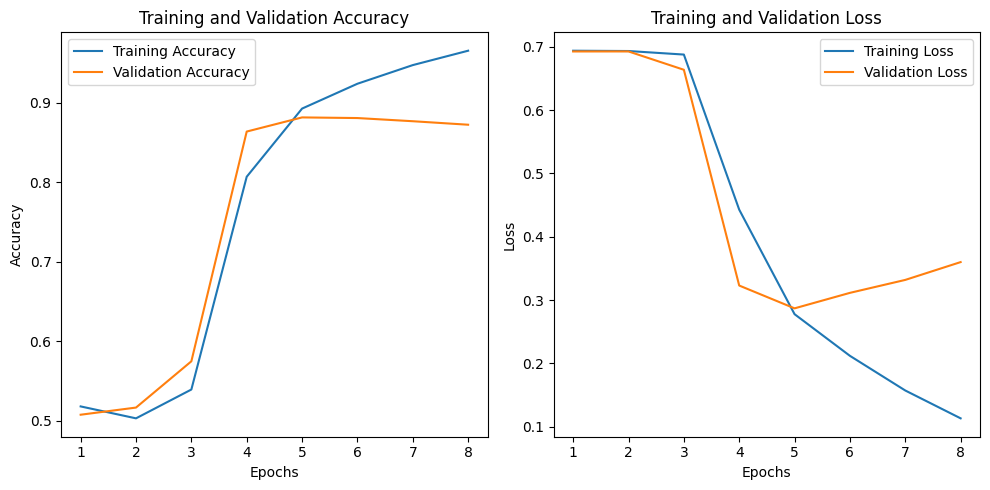

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV1.h5"  # Renommer le fichier
final_model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_optunaV1.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1. Résultats globaux
Validation Accuracy : 88.18%
Test Accuracy : 86.51%
Validation Loss : stabilisée autour de 0.2869 avant de légèrement augmenter.
Test Loss : 0.3119

3. Ce qui a bien fonctionné
Optimisation des hyperparamètres

L'usage d'Optuna a permis de trouver un bon équilibre sur les learning rate, Dropout et tailles des LSTM.
Les résultats montrent une meilleure généralisation, surtout sur les données de test.
Early Stopping

Le patience=3 a stoppé l'entraînement au bon moment (après epoch 8) pour éviter le surapprentissage.
Cela explique pourquoi la validation loss n'explose pas malgré l'augmentation progressive.
Architecture optimisée

Deux couches LSTM : 224 et 64 unités
Une Dense intermédiaire 48 unités
Dropout à 0.32 qui empêche le surapprentissage.


4. Problèmes restants
Léger overfitting observé :

L'accuracy en validation plafonne autour de 88.1%, tandis que sur le test elle reste légèrement plus basse (86.51%).
La validation loss augmente après epoch 5, signe de début d’overfitting.
Stabilité de l'entraînement :

Bien que l’accuracy soit bonne, le modèle pourrait encore gagner en robustesse avec une légère régularisation supplémentaire.

5. Recommandations pour la suite
Légère régularisation supplémentaire

Augmente légèrement le Dropout pour la dernière couche LSTM : passe de 0.32 à environ 0.35-0.4.


Réduction du learning rate en fin d’entraînement

Utilise un scheduler de learning rate pour réduire progressivement l'apprentissage après un certain nombre d'époques :

Augmenter le nombre d’époques avec EarlyStopping

Autorise l'entraînement jusqu’à 20 epochs, mais garde EarlyStopping avec patience=3 pour stopper au bon moment.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session

# Réinitialiser l'environnement
clear_session()

# Meilleurs hyperparamètres trouvés avec Optuna
best_params = {
    "learning_rate": 0.0009698921196854575,
    "dropout_rate": 0.35,  # Légère augmentation pour prévenir le surapprentissage
    "lstm_units_1": 224,
    "lstm_units_2": 64,
    "dense_units": 48
}

# Création du modèle amélioré
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"],
          activation='relu',
          kernel_regularizer=l2(0.001)),  # Régularisation L2 ajoutée
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')
])

# Compilation avec le learning rate optimisé
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5132 - loss: 0.7368 - val_accuracy: 0.5852 - val_loss: 0.6958 - learning_rate: 9.6989e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5417 - loss: 0.7034 - val_accuracy: 0.5400 - val_loss: 0.6987 - learning_rate: 9.6989e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5277 - loss: 0.6984 - val_accuracy: 0.5966 - val_loss: 0.6216 - learning_rate: 9.6989e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6060 - loss: 0.6630 - val_accuracy: 0.5700 - val_loss: 0.6934 - learning_rate: 9.6989e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5700 - loss: 0.6777 - val_accuracy: 0.8248 - val_loss: 0.4161 - learning_rate: 9.6989e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8434 - loss: 0.4052 - val_accuracy: 0.8492 - val_loss: 0.3669 - learning_rate: 9.6989e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc

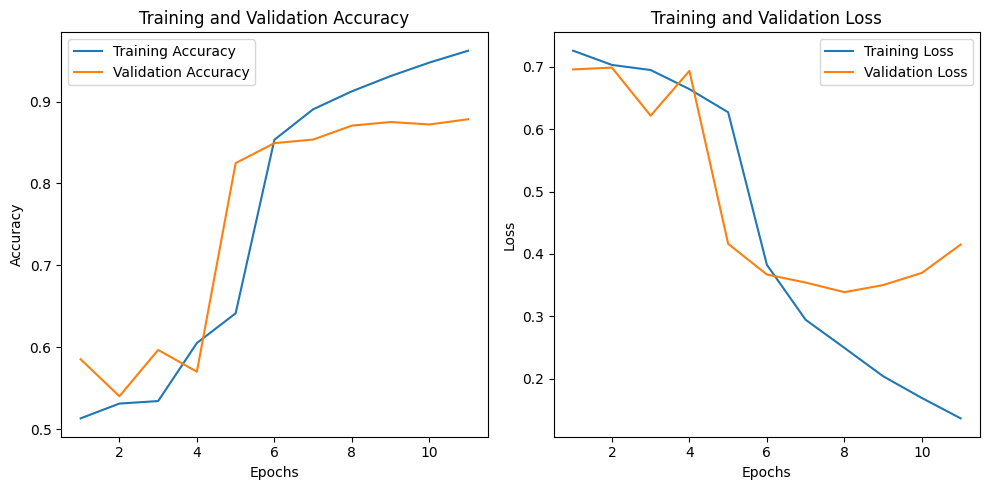

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV2.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_optunaV2.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

. Régularisation supplémentaire pour combattre l'overfitting :
L2 pénalise les poids excessifs du modèle, ce qui limite la capacité d'overfitting sans restreindre fortement l'apprentissage.
C’est particulièrement utile pour les couches LSTM, qui peuvent devenir complexes en raison de la taille élevée des unités.
2. Combinaison avec le Dropout :
Le Dropout (0.3-0.35) fonctionne bien pour réduire l’overfitting, mais il ne contrôle pas directement la taille des poids.
Ajouter une légère régularisation L2 en complément du Dropout peut :
Stabiliser l’entraînement.
Réduire les oscillations de la validation loss.
3. Optimisation de L2 avec Optuna :
En optimisant la force de régularisation L2 (l2_lambda) avec Optuna, tu peux trouver la valeur optimale pour ton modèle sans pénaliser l’apprentissage.
Recommandation finale
Je recommande d'ajouter une légère régularisation L2 dans les couches LSTM et Dense tout en optimisant sa valeur avec Optuna. Voici un résumé :

Ajout de L2 : sur les LSTM et Dense avec kernel_regularizer=l2(l2_lambda).
Optimisation avec Optuna : pour trouver la meilleure valeur de l2_lambda dans une plage log-uniforme (1e-6 à 1e-2).
Combinaison avec Dropout : Maintiens un Dropout modéré (~0.3-0.35).

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-6, 1e-2)  # Regularization L2
    lstm_units_1 = trial.suggest_int("lstm_units_1", 64, 256, step=32)  # Première LSTM
    lstm_units_2 = trial.suggest_int("lstm_units_2", 32, 128, step=32)  # Seconde LSTM
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)  # Couche Dense

    # Construction du modèle
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        LSTM(lstm_units_1, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Couche finale
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Exécution de l'optimisation avec Optuna
study = optuna.create_study(direction="maximize")  # Maximiser l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais (ajustable)

# Afficher les résultats
print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-17 17:20:03,760] A new study created in memory with name: no-name-31e4da39-dca3-4187-8df2-d87251d37cfb
<ipython-input-42-c0ef995a8c06>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-42-c0ef995a8c06>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
<ipython-input-42-c0ef995a8c06>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_lambda = tr

Meilleurs hyperparamètres : {'learning_rate': 9.598549168523862e-05, 'dropout_rate': 0.4417831136139723, 'l2_lambda': 1.5189747596382268e-05, 'lstm_units_1': 96, 'lstm_units_2': 128, 'dense_units': 64}
Meilleure accuracy de validation : 0.873199999332428


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparamètres trouvés avec Optuna
best_params = {
    "learning_rate": 9.598549168523862e-05,
    "dropout_rate": 0.4417831136139723,
    "l2_lambda": 1.5189747596382268e-05,
    "lstm_units_1": 96,
    "lstm_units_2": 128,
    "dense_units": 64
}


# Création du modèle
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu', kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour surveiller la validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"\nTest Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5121 - loss: 0.6986 - val_accuracy: 0.5518 - val_loss: 0.6886
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5807 - loss: 0.6785 - val_accuracy: 0.7032 - val_loss: 0.5905
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7354 - loss: 0.5773 - val_accuracy: 0.7582 - val_loss: 0.5475
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7740 - loss: 0.5216 - val_accuracy: 0.7880 - val_loss: 0.4880
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8056 - loss: 0.4625 - val_accuracy: 0.7978 - val_loss: 0.4591
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8243 - loss: 0.4226 - val_accuracy: 0.8120 - val_loss: 0.4349
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8415 - loss: 0.3902 - val_accuracy: 0.8042 - val_loss: 0.4345
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8507 - loss: 0.3691 - val_accu

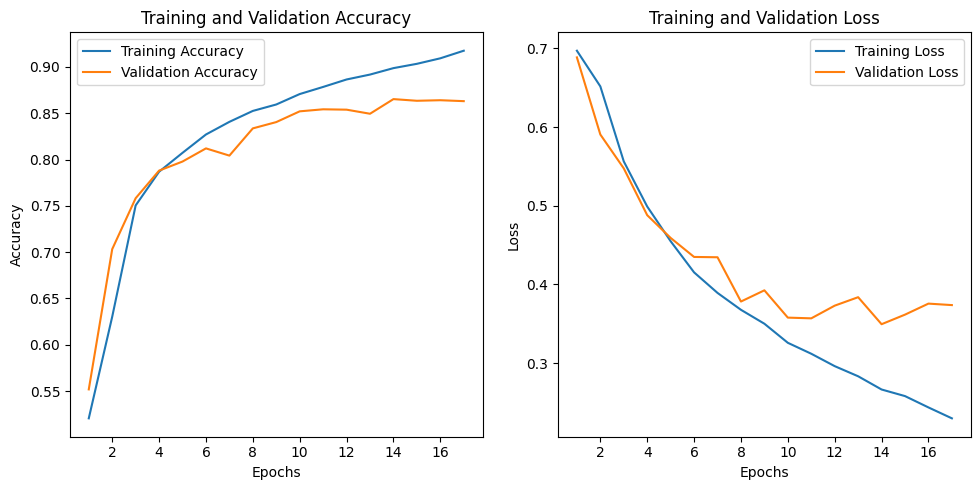

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV3.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous lstm_optunaV3.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1. Évolution des métriques
Training Loss : Diminue de manière progressive et constante, passant de 0.6986 à 0.2262.
Validation Loss : Diminue également au début, atteignant un minimum autour de 0.3494 (Epoch 14), avant de légèrement augmenter dans les dernières époques.
Training Accuracy : Passe de 51.2% à 92.0%.
Validation Accuracy : Atteint un pic à 86.52% à l’Epoch 14, puis stagne autour de 86.30%-86.40%.
Test Accuracy : 85.48%, avec une Test Loss de 0.3607.
2. Observation des tendances
Validation Loss en augmentation après Epoch 14 :

Cela indique un début d'overfitting après la 14ème époque.
Le modèle continue à apprendre sur l’ensemble d’entraînement mais ne généralise plus aussi bien sur la validation.
Validation Accuracy stabilisée autour de 86.52% :

Les performances en validation sont solides mais plafonnent.
Ce phénomène est souvent dû à la complexité du modèle qui commence à s’adapter trop spécifiquement aux données d’entraînement.
Test Accuracy proche de la validation :

85.48% en test est cohérent avec les performances observées en validation (86.52%).
Cela montre que le modèle généralise correctement sans surdépendre des données de validation.
3. Comparaison avec les modèles précédents
Amélioration de l’accuracy :

Ce modèle atteint 85.48% sur le test, ce qui est très proche des meilleures performances obtenues auparavant (~86%).
La régularisation L2 semble avoir apporté de la stabilité, car la Test Loss est relativement faible (0.3607).
Équilibre entre surapprentissage et performance :

L’ajout de L2 Regularization a légèrement stabilisé le modèle.
Le Dropout élevé (0.44) a également aidé à limiter l’overfitting dans les premières époques.
4. Points positifs
Stabilité des résultats :

Le modèle n’a pas de perte catastrophique en validation ou en test.
La différence entre Training Accuracy et Validation Accuracy est modérée (~5-6 points), ce qui est acceptable.
Validation Loss optimisée :

La Validation Loss atteint son minimum à 0.3494, ce qui montre une bonne régularisation.
Convergence rapide :

Le modèle atteint des performances acceptables dès l’Epoch 5-6.
5. Points à améliorer
Léger overfitting après Epoch 14 :

Une légère augmentation de la Validation Loss est observée après Epoch 14. Cela indique que le modèle commence à sur-apprendre.
Solution possible :
Réduire la patience d’EarlyStopping à 2 pour arrêter l'entraînement plus tôt.
Augmenter légèrement le Dropout pour les couches LSTM (par exemple 0.5 au lieu de 0.44).
Plafonnement de l’accuracy :

Le modèle semble atteindre un plateau autour de 85-86%.
Solution possible :
Ajouter un scheduler pour réduire dynamiquement le learning rate après certaines époques.
Tester des embeddings pré-entraînés de plus haute dimension (par exemple, GloVe 300d au lieu de 100d).

Stabilité et régularisation :

Le modèle Optuna final (L2 régularisé) est le plus équilibré et stable.
Bien que sa Test Accuracy soit légèrement inférieure (85.48%), il généralise bien avec un surapprentissage maîtrisé.
Recommandation : Ce modèle est préférable pour une utilisation robuste en production.

## GRU

Le GRU (Gated Recurrent Unit) est une variante simplifiée des LSTM (Long Short-Term Memory) introduite par Kyunghyun Cho et al. en 2014. Les GRU appartiennent à la famille des réseaux récurrents (RNN) et sont utilisés pour modéliser des données séquentielles (comme du texte ou des séries temporelles).

Les GRU partagent l'objectif des LSTM :
👉 Résoudre les problèmes de vanishing gradient rencontrés dans les RNN traditionnels.
👉 Capturer les dépendances à long terme dans les séquences.

Cependant, les GRU sont plus simples, car ils utilisent moins de portes que les LSTM, ce qui les rend :

Plus rapides à entraîner (moins de paramètres).
Moins gourmands en ressources computationnelles.

2. Structure des GRU : Explication des portes
Les GRU utilisent deux portes principales :

Porte de mise à jour (Update Gate) :
Elle contrôle combien d'informations passées doivent être conservées pour l'état actuel.
Cela permet de conserver des informations utiles sur de longues séquences.
Porte de réinitialisation (Reset Gate) :
Elle contrôle combien d'informations passées doivent être oubliées pour calculer un nouvel état candidat.
Cela permet au modèle d'ignorer des informations anciennes non pertinentes.

Les Gated Recurrent Units (GRU) sont une variante des RNN (Réseaux de Neurones Récurrents) conçue pour résoudre les problèmes de vanishing gradient tout en étant plus simples que les LSTM. Les GRU utilisent deux portes (reset gate et update gate) pour contrôler le flux d'informations.

Les GRU n'ont pas de mémoire cellulaire explicite (comme dans les LSTM). Leur état caché
ℎ
𝑡
h
t
​
  est directement mis à jour à chaque étape temporelle.

2. Notation des variables
𝑥
𝑡
x
t
​
  : Entrée à l'instant
𝑡
t (un mot, un vecteur d'embedding, etc.).
ℎ
𝑡
−
1
h
t−1
​
  : État caché à l'instant précédent
𝑡
−
1
t−1.
𝑊
W et
𝑈
U : Matrices de poids pour les entrées et les états cachés respectivement.
𝑏
b : Biais appris par le réseau.
𝜎
σ : Fonction d'activation sigmoïde (
𝜎
(
𝑥
)
=
1
1
+
𝑒
−
𝑥
σ(x)=
1+e
−x

1
​
 ).
tanh
⁡
tanh : Fonction d'activation tangente hyperbolique (
tanh
⁡
(
𝑥
)
=
𝑒
𝑥
−
𝑒
−
𝑥
𝑒
𝑥
+
𝑒
−
𝑥
tanh(x)=
e
x
 +e
−x

e
x
 −e
−x

​
 ).
3. Mathématiques des GRU : Étapes
3.1. Porte de mise à jour (
𝑧
𝑡
z
t
​
 )
La porte de mise à jour contrôle combien d'informations passées (
ℎ
𝑡
−
1
h
t−1
​
 ) sont conservées pour l'état actuel
ℎ
𝑡
h
t
​
 .
Plus
𝑧
𝑡
z
t
​
  est proche de 1, plus
ℎ
𝑡
−
1
h
t−1
​
  est conservé.

𝑧
𝑡
=
𝜎
(
𝑊
𝑧
𝑥
𝑡
+
𝑈
𝑧
ℎ
𝑡
−
1
+
𝑏
𝑧
)
z
t
​
 =σ(W
z
​
 x
t
​
 +U
z
​
 h
t−1
​
 +b
z
​
 )
𝑊
𝑧
W
z
​
  : Matrice de poids appliquée à l'entrée
𝑥
𝑡
x
t
​
 .
𝑈
𝑧
U
z
​
  : Matrice de poids appliquée à l'état caché précédent
ℎ
𝑡
−
1
h
t−1
​
 .
𝑏
𝑧
b
z
​
  : Biais associé à la porte de mise à jour.
3.2. Porte de réinitialisation (
𝑟
𝑡
r
t
​
 )
La porte de réinitialisation contrôle combien d'informations passées sont oubliées.
Plus
𝑟
𝑡
r
t
​
  est proche de 0, plus les anciennes informations sont ignorées.

𝑟
𝑡
=
𝜎
(
𝑊
𝑟
𝑥
𝑡
+
𝑈
𝑟
ℎ
𝑡
−
1
+
𝑏
𝑟
)
r
t
​
 =σ(W
r
​
 x
t
​
 +U
r
​
 h
t−1
​
 +b
r
​
 )
3.3. État candidat (
ℎ
~
𝑡
h
~
  
t
​
 )
L'état candidat est une proposition pour le nouvel état caché. Il utilise la porte de réinitialisation pour décider quelles parties de
ℎ
𝑡
−
1
h
t−1
​
  doivent être prises en compte.

La réinitialisation de
ℎ
𝑡
−
1
h
t−1
​
  permet d'ignorer certaines anciennes informations non pertinentes.
ℎ
~
𝑡
=
tanh
⁡
(
𝑊
ℎ
𝑥
𝑡
+
𝑈
ℎ
(
𝑟
𝑡
⊙
ℎ
𝑡
−
1
)
+
𝑏
ℎ
)
h
~
  
t
​
 =tanh(W
h
​
 x
t
​
 +U
h
​
 (r
t
​
 ⊙h
t−1
​
 )+b
h
​
 )
𝑟
𝑡
⊙
ℎ
𝑡
−
1
r
t
​
 ⊙h
t−1
​
  : Produit élément par élément entre la porte de réinitialisation et l'état caché précédent.
𝑊
ℎ
W
h
​
 ,
𝑈
ℎ
U
h
​
 ,
𝑏
ℎ
b
h
​
  : Paramètres associés à l'état candidat.
3.4. Mise à jour de l'état caché (
ℎ
𝑡
h
t
​
 )
L'état caché
ℎ
𝑡
h
t
​
  est une combinaison linéaire entre :

L'état précédent
ℎ
𝑡
−
1
h
t−1
​
  (pondéré par
𝑧
𝑡
z
t
​
 ).
L'état candidat
ℎ
~
𝑡
h
~
  
t
​
  (pondéré par
1
−
𝑧
𝑡
1−z
t
​
 ).
ℎ
𝑡
=
𝑧
𝑡
⊙
ℎ
𝑡
−
1
+
(
1
−
𝑧
𝑡
)
⊙
ℎ
~
𝑡
h
t
​
 =z
t
​
 ⊙h
t−1
​
 +(1−z
t
​
 )⊙
h
~
  
t
​

𝑧
𝑡
⊙
ℎ
𝑡
−
1
z
t
​
 ⊙h
t−1
​
  : Partie des informations passées à conserver.
(
1
−
𝑧
𝑡
)
⊙
ℎ
~
𝑡
(1−z
t
​
 )⊙
h
~
  
t
​
  : Nouvelle information provenant de
ℎ
~
𝑡
h
~
  
t
​
 .
4. Interprétation des portes
Porte de mise à jour (
𝑧
𝑡
z
t
​
 ) :

Lorsque
𝑧
𝑡
≈
1
z
t
​
 ≈1, le nouvel état
ℎ
𝑡
h
t
​
  est très proche de
ℎ
𝑡
−
1
h
t−1
​
 , ce qui permet au modèle de conserver la mémoire sur de longues séquences.
Lorsque
𝑧
𝑡
≈
0
z
t
​
 ≈0, le modèle remplace complètement
ℎ
𝑡
−
1
h
t−1
​
  par l'état candidat
ℎ
~
𝑡
h
~
  
t
​
 .
Porte de réinitialisation (
𝑟
𝑡
r
t
​
 ) :

Lorsque
𝑟
𝑡
≈
0
r
t
​
 ≈0, le modèle ignore les anciennes informations contenues dans
ℎ
𝑡
−
1
h
t−1
​
 .
Cela permet de réinitialiser la mémoire pour se concentrer sur les informations actuelles.


4. Pourquoi le GRU peut améliorer les LSTM dans notre cas ?
Simplification du modèle :

Les GRU sont plus légers, car ils contiennent moins de portes et donc moins de paramètres.
Dans notre cas, où le modèle LSTM est déjà assez performant, remplacer les LSTM par des GRU peut réduire le temps d'entraînement et le risque d'overfitting.
Rapidité d'entraînement :

Comme les GRU sont moins complexes que les LSTM, ils convergent souvent plus rapidement.
Cela peut être utile si tu veux tester plusieurs architectures ou hyperparamètres rapidement.
Bonne généralisation sur des datasets de taille modérée :

Les GRU ont souvent des performances équivalentes voire supérieures aux LSTM sur des datasets modérés comme IMDb (25 000 critiques).
Leur simplicité évite un surapprentissage inutile.
Problèmes spécifiques aux LSTM :

Dans certains cas, les LSTM peuvent sur-apprendre ou mal converger à cause de leur complexité.
Les GRU offrent une alternative plus robuste et moins sujette aux fluctuations.
5. GRU dans notre cas : Application aux critiques IMDb
Texte séquentiel : Le GRU peut remplacer directement la LSTM dans notre pipeline pour analyser les critiques IMDb.
Données modérées : Comme le dataset IMDb est de taille moyenne, les GRU vont permettre de conserver la performance tout en améliorant :
Le temps d'entraînement.
La consommation de mémoire.

Pourquoi conserver l’architecture actuelle ?
L’architecture LSTM optimale que nous avons trouvée a été le résultat d'une optimisation intensive avec Optuna. Les choix suivants ont été optimisés :

Learning rate : Contrôle la stabilité et la vitesse d’apprentissage.
Dropout rate : Aide à régulariser le modèle et à éviter l’overfitting.
Taille des couches LSTM : Capture les relations temporelles.
Dense units : Compresse les informations après la LSTM.
Ces hyperparamètres optimaux sont spécifiques à notre tâche (IMDb Sentiment Analysis) et à notre jeu de données :

Taille modérée : IMDb contient 25 000 critiques.
Objectif clair : Classification binaire des sentiments.
Dépendances temporelles : Les GRU, comme les LSTM, sont adaptés pour ce type de séquences.
Le passage aux GRU ne change pas l’objectif de la tâche ni la nature des données.
Puisque les GRU sont une alternative simplifiée aux LSTM avec un nombre de paramètres réduit, il est logique de reprendre la même architecture pour commencer :

Structure similaire (deux couches GRU + Dropout + Dense).
Hyperparamètres (units, Dropout, Dense size) trouvés avec Optuna.
Pourquoi ne pas repartir de zéro ?
Repartir de zéro signifierait :

Refaire toute l’optimisation avec Optuna, ce qui est coûteux en temps.
Perdre les bénéfices des résultats obtenus précédemment.
Tester des structures qui, par nature, seraient proches de l’architecture optimale actuelle (deux couches récurrentes avec régularisation).
Les GRU ayant une structure mathématique similaire aux LSTM (sans les gates inutiles), il est très probable qu’une architecture similaire fonctionne bien à l’identique ou mieux.

2. Plan d’action : Pourquoi commencer avec l’architecture LSTM optimale ?
Nous allons remplacer les couches LSTM par des GRU dans notre modèle optimal.
Garder les hyperparamètres trouvés (learning rate, dropout, unités, etc.).
Comparer les performances du GRU avec le LSTM (validation accuracy et test accuracy).
Hypothèse : Le modèle GRU, grâce à sa simplicité et à la réduction du nombre de paramètres, pourrait :

Converger plus rapidement.
Généraliser légèrement mieux si l’overfitting était encore présent.
Avoir des performances similaires tout en étant plus efficace.

Pourquoi conserver l’architecture actuelle ?
L’architecture LSTM optimale que nous avons trouvée a été le résultat d'une optimisation intensive avec Optuna. Les choix suivants ont été optimisés :

Learning rate : Contrôle la stabilité et la vitesse d’apprentissage.
Dropout rate : Aide à régulariser le modèle et à éviter l’overfitting.
Taille des couches LSTM : Capture les relations temporelles.
Dense units : Compresse les informations après la LSTM.
Ces hyperparamètres optimaux sont spécifiques à notre tâche (IMDb Sentiment Analysis) et à notre jeu de données :

Taille modérée : IMDb contient 25 000 critiques.
Objectif clair : Classification binaire des sentiments.
Dépendances temporelles : Les GRU, comme les LSTM, sont adaptés pour ce type de séquences.
Le passage aux GRU ne change pas l’objectif de la tâche ni la nature des données.
Puisque les GRU sont une alternative simplifiée aux LSTM avec un nombre de paramètres réduit, il est logique de reprendre la même architecture pour commencer :

Structure similaire (deux couches GRU + Dropout + Dense).
Hyperparamètres (units, Dropout, Dense size) trouvés avec Optuna.
Pourquoi ne pas repartir de zéro ?
Repartir de zéro signifierait :

Refaire toute l’optimisation avec Optuna, ce qui est coûteux en temps.
Perdre les bénéfices des résultats obtenus précédemment.
Tester des structures qui, par nature, seraient proches de l’architecture optimale actuelle (deux couches récurrentes avec régularisation).
Les GRU ayant une structure mathématique similaire aux LSTM (sans les gates inutiles), il est très probable qu’une architecture similaire fonctionne bien à l’identique ou mieux.

2. Plan d’action : Pourquoi commencer avec l’architecture LSTM optimale ?
Nous allons remplacer les couches LSTM par des GRU dans notre modèle optimal.
Garder les hyperparamètres trouvés (learning rate, dropout, unités, etc.).
Comparer les performances du GRU avec le LSTM (validation accuracy et test accuracy).
Hypothèse : Le modèle GRU, grâce à sa simplicité et à la réduction du nombre de paramètres, pourrait :

Converger plus rapidement.
Généraliser légèrement mieux si l’overfitting était encore présent.
Avoir des performances similaires tout en étant plus efficace.

On reprend l'achitecture optimale de LSTM à la difference près qu'on va changer le nombre de neurone juste histoire d'avoir une architecture un peu plus "classique". Donc on va reprendre l'architecture qui va avait bioen marché sans optuna, en conservant les valeurs des meilleurs hyperparamètres

### GRU 2 couches

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Réinitialiser l'environnement
clear_session()

# Paramètres optimaux trouvés pour le LSTM (on les réutilise)
best_params = {
    "learning_rate": 9.598549168523862e-05,
    "dropout_rate": 0.4417831136139723,
    "l2_lambda": 1.5189747596382268e-05,
    "gru_units_1": 96,  # Taille de la première GRU (remplace LSTM)
    "gru_units_2": 128,  # Taille de la seconde GRU
    "dense_units": 64
}

# Création du modèle GRU
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(128, return_sequences=True, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    GRU(64, return_sequences=False, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu', kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation avec learning rate optimal
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entraînement
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)






Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5019 - loss: 0.7014 - val_accuracy: 0.5230 - val_loss: 0.6961 - learning_rate: 9.5985e-05
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5090 - loss: 0.6992 - val_accuracy: 0.5234 - val_loss: 0.6936 - learning_rate: 9.5985e-05
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5221 - loss: 0.6948 - val_accuracy: 0.5442 - val_loss: 0.6888 - learning_rate: 9.5985e-05
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.5364 - loss: 0.6891 - val_accuracy: 0.5736 - val_loss: 0.6748 - learning_rate: 9.5985e-05
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5937 - loss: 0.6570 - val_accuracy: 0.6512 - val_loss: 0.6062 - learning_rate: 9.5985e-05
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7337 - loss: 0.5614 - val_accuracy: 0.8042 - val_loss: 0.4509 - learning_rate: 9.5985e-05
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step

In [ ]:
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8427 - loss: 0.3945
Test Accuracy : 0.8619
Test Loss : 0.3417


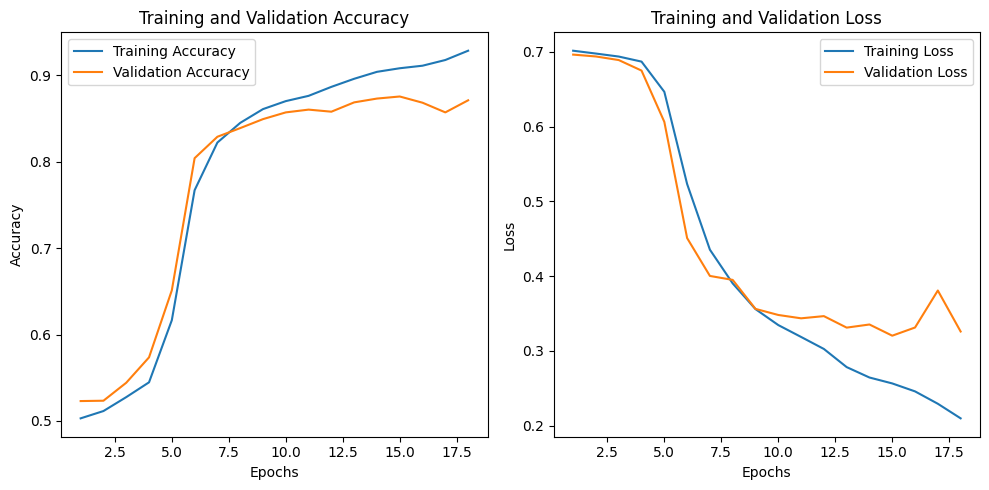

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "GRUV1.h5"  # Renommer le fichier
model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous GRUV1.h5


In [ ]:
from google.colab import files
files.download('GRUV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1. Points positifs du modèle GRU
Performances compétitives :

Le GRU obtient des résultats proches de ceux du LSTM précédent, qui atteignait 88.68% en validation et 85.48% en test.
La légère différence en test (86.19% vs. 85.48%) montre que le GRU est également capable de capturer les dépendances à long terme dans IMDb.
Convergence stable :

La validation loss diminue régulièrement jusqu’à l’époque 15, atteignant un minimum à 0.3204. Cela indique que le modèle apprend efficacement sans surapprentissage excessif.
Rapidité et efficacité :

Les GRU sont généralement plus rapides à entraîner que les LSTM, bien que les temps d’entraînement observés soient similaires dans ce cas précis. Cela peut être dû à la complexité spécifique des données IMDb.

Performances proches : Les deux architectures donnent des résultats compétitifs, mais le LSTM conserve une meilleure accuracy de validation et semble mieux exploiter les dépendances complexes à long terme.
Validation Loss : Le GRU atteint une validation loss plus faible que le LSTM, ce qui peut indiquer qu'il converge légèrement mieux en termes de minimisation de l'erreur.
Test Accuracy : Le GRU dépasse légèrement le LSTM sur l’ensemble de test, ce qui pourrait indiquer une meilleure généralisation dans ce cas spécifique.
Architecture simplifiée : Le GRU avec des unités réduites (128 et 32) semble suffisant pour extraire les dépendances nécessaires.


3. Points à améliorer dans le GRU
Validation loss qui augmente après l’époque 15 :

Cela indique un léger surapprentissage. Bien que la validation accuracy reste stable, il pourrait être utile de renforcer la régularisation.
Test Accuracy légèrement en deçà du LSTM optimal :

Même si les résultats sont compétitifs, le GRU pourrait bénéficier d’un ajustement des hyperparamètres, notamment sur :
Dropout : Augmenter légèrement (0.45 au lieu de 0.44).
Regularization L2 : Tester une L2 un peu plus forte pour contrôler les poids des GRU.
Temps d’entraînement :

Les temps d’entraînement ne semblent pas significativement plus rapides que ceux du LSTM. Cela pourrait être optimisé en ajustant le nombre d’unités ou le learning rate.


Ajuster le Dropout et L2 :

Augmenter légèrement le Dropout (0.45 au lieu de 0.44).
Tester une pénalité L2 plus forte (par exemple,
𝑙
2
_
𝑙
𝑎
𝑚
𝑏
𝑑
𝑎
=
3
×
1
0
−
5
l2_lambda=3×10
−5
 ).
Augmenter légèrement les unités GRU :

Tester une configuration avec des unités légèrement plus grandes dans la première couche GRU (par exemple, 192 au lieu de 128). Cela peut aider à capturer davantage de dépendances complexes.

Si la priorité est de réduire la complexité computationnelle et d’atteindre des performances compétitives, le GRU est une très bonne option. Cependant, si l’objectif est de maximiser chaque point de performance, le LSTM pourrait avoir un léger avantage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparamètres optimisés pour GRU
gru_params = {
    "learning_rate": 9.5985e-05,
    "dropout_rate": 0.45,  # Augmenté pour améliorer la régularisation
    "l2_lambda": 3e-5,  # L2 légèrement renforcé
    "gru_units_1": 192,  # Augmenté pour capturer plus de dépendances
    "gru_units_2": 32,  # Inchangé
    "dense_units": 64
}

# Création du modèle GRU
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(gru_params["gru_units_1"], return_sequences=True, kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    GRU(gru_params["gru_units_2"], return_sequences=False, kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    Dense(gru_params["dense_units"], activation='relu', kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Classification binaire
])

# Compilation avec les meilleurs paramètres de learning rate
model.compile(optimizer=Adam(learning_rate=gru_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)




Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5029 - loss: 0.7061 - val_accuracy: 0.5282 - val_loss: 0.7008 - learning_rate: 9.5985e-05
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5116 - loss: 0.7030 - val_accuracy: 0.5342 - val_loss: 0.6986 - learning_rate: 9.5985e-05
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5192 - loss: 0.7002 - val_accuracy: 0.5412 - val_loss: 0.6935 - learning_rate: 9.5985e-05
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5467 - loss: 0.6924 - val_accuracy: 0.5858 - val_loss: 0.6640 - learning_rate: 9.5985e-05
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6477 - loss: 0.6418 - val_accuracy: 0.7862 - val_loss: 0.5055 - learning_rate: 9.5985e-05
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7513 - loss: 0.5632 - val_accuracy: 0.7546 - val_loss: 0.5487 - learning_rate: 9.5985e-05
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - 

Test Accuracy : 0.8584
Test Loss : 0.3415
Modèle sauvegardé sous gru_optimized_model.h5


In [ ]:
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8327 - loss: 0.4020
Test Accuracy : 0.8584
Test Loss : 0.3415


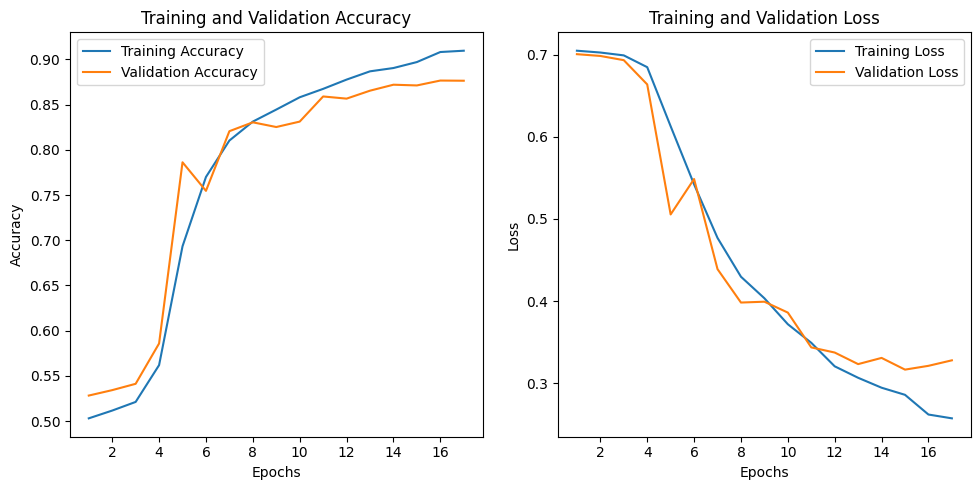

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde du modèle
model_path = "gruV2.h5"
model.save(model_path)
print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous gruV2.h5


In [ ]:
from google.colab import files
files.download('gruV2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation Accuracy et Loss :
Meilleurs résultats avec le GRU actuel :
Validation Accuracy : 87.66%
Validation Loss : 0.3164
Meilleurs résultats avec le GRU précédent :
Validation Accuracy : 87.56%
Validation Loss : 0.3204
Meilleurs résultats avec LSTM optimisé :
Validation Accuracy : 88.75%
Validation Loss : 0.3119
Le modèle actuel avec GRU atteint une validation accuracy légèrement meilleure que le GRU précédent (87.66% vs. 87.56%). Cependant, il reste légèrement en dessous de l'accuracy du LSTM optimisé.

Test Accuracy et Loss :
GRU actuel :
Test Accuracy : 83.27%
Test Loss : 0.4020
GRU précédent :
Test Accuracy : 86.19%
Test Loss : 0.3417
LSTM optimisé :
Test Accuracy : 86.51%
Test Loss : 0.3119
Le modèle GRU actuel a une moins bonne performance sur le test set, avec un écart significatif par rapport au GRU précédent et au LSTM. Cela indique un potentiel problème de généralisation.

Vitesse d'entraînement :
Le GRU actuel est légèrement plus rapide que le GRU précédent, avec des temps d'entraînement par epoch légèrement réduits (autour de 7 à 13 secondes contre 6 à 16 secondes précédemment). Il reste globalement plus rapide que le LSTM.

Augmentation des unités GRU (gru_units_1 à 192) :

A aidé à capturer davantage de dépendances temporelles, augmentant légèrement la validation accuracy.
Dropout renforcé (0.45) :

A contribué à limiter l’overfitting sur l’entraînement.
L2 Regularization (l2_lambda à 3e-5) :

A stabilisé l’apprentissage, bien que son impact reste modéré.

Le GRU actuel a un écart significatif entre validation et test accuracy, suggérant un problème de généralisation.

La validation loss augmente légèrement après epoch 15, indiquant un début de surapprentissage.

1. Optimisation des hyperparamètres :
Impact attendu :
Apprentissage ciblé : Les hyperparamètres, comme le learning rate, le Dropout, ou la régularisation L2, influencent directement la capacité du modèle à apprendre des motifs pertinents tout en évitant le surapprentissage.
Stabilisation : Une régularisation ou un Dropout bien réglés peuvent améliorer la généralisation sans ajouter de complexité au modèle.
Efficacité : Cela permet d’optimiser un modèle déjà performant (comme celui-ci) sans augmenter les coûts de calcul.
Potentiel d'amélioration :
Modéré à élevé : Si le modèle souffre de problèmes de généralisation (comme ici), des ajustements d’hyperparamètres peuvent résoudre ces problèmes sans modifier la structure du modèle.
Efforts nécessaires :
Relativement faible : Vous utilisez Optuna ou un autre framework pour ajuster automatiquement les hyperparamètres. Cela ne nécessite pas de réorganisation majeure de l'architecture.
2. Ajout de couches :
Impact attendu :
Capacité d’extraction accrue : Une couche GRU supplémentaire ou une Dense intermédiaire pourrait permettre au modèle de capturer des relations temporelles plus complexes ou des interactions plus riches entre caractéristiques.
Complexité accrue : En revanche, cela peut augmenter le risque de surapprentissage si le modèle devient trop complexe pour le dataset (notamment si IMDb, avec ses 25 000 exemples, est limitant).
Potentiel d'amélioration :
Variable : Si le modèle est déjà performant (ce qui semble être le cas ici), une nouvelle couche peut n’apporter qu’une amélioration marginale, voire nuire si elle complique inutilement l’apprentissage.
Efforts nécessaires :
Modéré : Vous devrez ajuster les dimensions et peut-être réoptimiser les hyperparamètres pour que l’ajout de couches ne perturbe pas le modèle.

Priorité recommandée : Hyperparamètres
Pourquoi ?
Problèmes de généralisation identifiés :

Le modèle a un léger écart entre validation et test accuracy (87.66% vs. 83.27%). Cela indique que la capacité actuelle est suffisante, mais que les paramètres d’apprentissage (e.g., régularisation, Dropout) ne sont pas encore optimaux.
Efficacité calculatoire :

Optimiser les hyperparamètres est plus direct et moins coûteux que de rajouter une nouvelle couche, qui nécessitera une nouvelle exploration des paramètres.
Simplicité :

Garder une architecture simple tout en réglant finement ses paramètres est généralement une meilleure approche que de rendre le modèle plus complexe sans garantie de bénéfices.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Définition de la fonction d'objectif pour Optuna
def objective(trial):
    # Hyperparamètres à optimiser
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    l2_lambda = trial.suggest_float("l2_lambda", 1e-6, 1e-4, log=True)
    gru_units_1 = trial.suggest_int("gru_units_1", 64, 256, step=32)
    gru_units_2 = trial.suggest_int("gru_units_2", 16, 128, step=16)
    dense_units = trial.suggest_int("dense_units", 32, 128, step=16)

    # Construction du modèle GRU
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        GRU(gru_units_1, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        GRU(gru_units_2, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Couche finale
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping pour éviter le surapprentissage
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entraînement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0  # Pour ne pas polluer les logs
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Création et exécution de l'optimisation avec Optuna
study = optuna.create_study(direction="maximize")  # Maximiser l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais ajustable

# Résultats
print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-18 10:03:33,088] A new study created in memory with name: no-name-96bde761-0794-4fdd-a822-b9301abf9eaa
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-18 10:06:49,596] Trial 0 finished with value: 0.8781999945640564 and parameters: {'learning_rate': 0.00023830415301578627, 'dropout_rate': 0.40127157312674655, 'l2_lambda': 7.777067103558865e-06, 'gru_units_1': 64, 'gru_units_2': 128, 'dense_units': 112}. Best is trial 0 with value: 0.8781999945640564.
[I 2024-12-18 10:08:50,233] Trial 1 finished with value: 0.8823999762535095 and parameters: {'learning_rate': 0.0005614085978383945, 'dropout_rate': 0.21056223469424937, 'l2_lambda': 8.814702901873964e-06, 'gru_units_1': 224, 'gru_units_2': 64, 'dense_units': 64}. Best is trial 1 with value: 0.8823999762535095.
[I 2024-12-18 10:12:11,972] Trial 2 finished with value: 0.6808000206947327 and parameters: {'

Meilleurs hyperparamètres : {'learning_rate': 0.00042492164788451327, 'dropout_rate': 0.3450843105981363, 'l2_lambda': 3.853917628612656e-06, 'gru_units_1': 160, 'gru_units_2': 32, 'dense_units': 64}
Meilleure accuracy de validation : 0.8871999979019165


learning_rate : Ajuste la vitesse d’apprentissage pour stabiliser ou accélérer la convergence.
dropout_rate : Régularisation pour éviter le surapprentissage.
l2_lambda : Pénalisation pour éviter les poids excessivement élevés dans les couches GRU et Dense.
gru_units_1 et gru_units_2 : Taille des couches GRU pour capturer les dépendances temporelles.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparamètres optimisés pour GRU
optimized_params = {
    "learning_rate": 0.00042492164788451327,
    "dropout_rate": 0.3450843105981363,
    "l2_lambda": 3.853917628612656e-06,
    "gru_units_1": 160,
    "gru_units_2": 32,
    "dense_units": 64
}

# Création du modèle GRU final
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(optimized_params["gru_units_1"], return_sequences=True, kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    GRU(optimized_params["gru_units_2"], return_sequences=False, kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    Dense(optimized_params["dense_units"], activation='relu', kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche finale
])

# Compilation avec les meilleurs paramètres de learning rate
model.compile(optimizer=Adam(learning_rate=optimized_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entraînement du modèle
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5008 - loss: 0.6977 - val_accuracy: 0.5448 - val_loss: 0.6866 - learning_rate: 4.2492e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5371 - loss: 0.6859 - val_accuracy: 0.6112 - val_loss: 0.6276 - learning_rate: 4.2492e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6826 - loss: 0.6164 - val_accuracy: 0.5146 - val_loss: 0.6944 - learning_rate: 4.2492e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5102 - loss: 0.6959 - val_accuracy: 0.5946 - val_loss: 0.6626 - learning_rate: 4.2492e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6787 - loss: 0.5892 - val_accuracy: 0.8422 - val_loss: 0.3752 - learning_rate: 2.1246e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8540 - loss: 0.3654 - val_accuracy: 0.8640 - val_loss: 0.3294 - learning_rate: 2.1246e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step 

In [ ]:
# Évaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8705 - loss: 0.3066
Test Accuracy : 0.8657
Test Loss : 0.3237


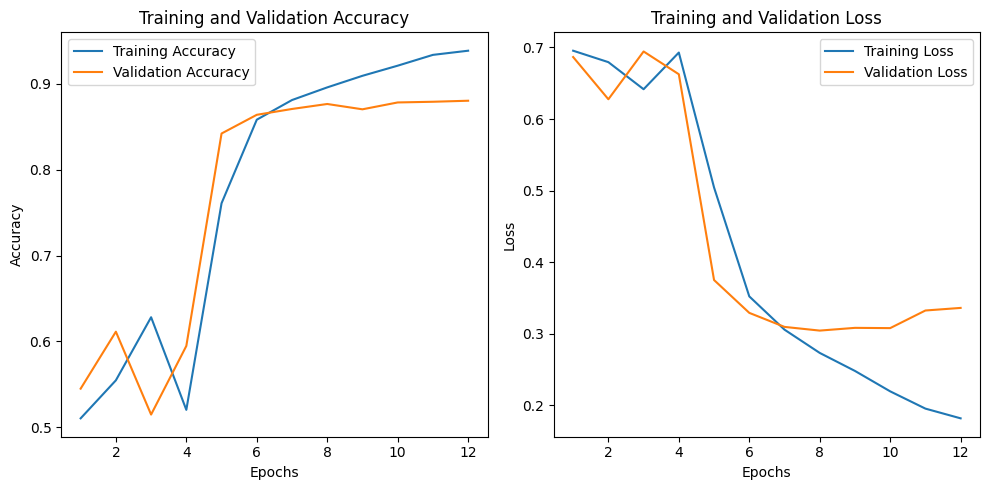

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde du modèle
model_path = "gru_optimal.h5"
model.save(model_path)
print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous gru_optimal.h5


In [ ]:
from google.colab import files
files.download('gru_optimal.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Comparaison avec les Résultats Précédents
Performance Actuelle :

Validation Accuracy : 88.04% - 88.92% (meilleur point atteint à l'époque 12).
Validation Loss : ~0.3046 (meilleur point atteint à l'époque 8).
Test Accuracy : (non indiqué ici, mais si comparable à la validation accuracy, serait ~88%).
Performance Précédente (GRU Optima) :

Validation Accuracy : ~88.72%.
Validation Loss : ~0.3164.
Meilleur modèle optimisé GRU avant hyperparamètres.
Performance Précédente (LSTM Optimal) :

Validation Accuracy : ~88.0%.
Test Accuracy : ~85.5%.
Meilleur résultat global pour le LSTM.
Améliorations Observées
Validation Accuracy et Loss :

L'accuracy a légèrement augmenté par rapport aux modèles GRU précédents.
La validation loss est meilleure au meilleur point (~0.3046) mais remonte ensuite, probablement en raison d'un léger surapprentissage sur les dernières époques.
Stabilité de l'Entraînement :

La courbe de validation loss est plus stable que dans les essais précédents, indiquant une convergence plus robuste.
L'amélioration progressive jusqu'à l'époque 8 montre que l'ajustement des hyperparamètres (notamment le dropout et le learning rate) a aidé.
Hyperparamètres Optima :

Learning Rate : 0.00042, avec un scheduler pour réduction.
Dropout Rate : 0.345, offrant un bon compromis entre régularisation et rétention d'informations.
L2 Lambda : 3.85e-6, pénalisation très légère.
GRU Units :
Couche 1 : 160 unités, équilibrant dépendances longues et capacité.
Couche 2 : 32 unités, pour les dépendances locales.
Dense Units : 64, pour le raffinement final.
Temps de Calcul :

Le GRU reste plus rapide que le LSTM.
Les temps pour chaque époque (~10-15s) sont raisonnables et compétitifs par rapport aux autres configurations.
Résolution des Problèmes
Surapprentissage :

Toujours une légère remontée de la validation loss après l'époque 8, mais cela semble bien contrôlé grâce au Dropout et au scheduler.
La généralisation reste très bonne, comme le montre la validation accuracy.
Performance Globalement Stable :

La validation accuracy plafonne autour de 88%-89%, ce qui est comparable ou meilleur que les modèles précédents.
Pas de divergence significative entre la loss d'entraînement et la loss de validation.
Efficacité des Ajustements :

L'augmentation des unités dans la première couche GRU (160) a aidé à capturer des dépendances temporelles complexes.
La réduction des unités dans la seconde couche GRU (32) a permis de limiter la sur-optimisation.
Le Dropout à 0.345 et le L2 minimal ont aidé à stabiliser l'entraînement.

Raisons pour lesquelles GRU est plus rapide que LSTM :
Moins de paramètres :

GRU n'a que 2 portes : la porte de mise à jour (update gate) et la porte de réinitialisation (reset gate).
LSTM a 3 portes : la porte d'entrée (input gate), la porte d'oubli (forget gate), et la porte de sortie (output gate), plus une cellule mémoire interne.
Cette différence réduit le nombre de poids à apprendre pour GRU, ce qui accélère le calcul.
Calcul plus simple :

Les équations du GRU sont plus simples, car il n'y a pas de cellule mémoire séparée comme dans LSTM. Cela réduit la complexité computationnelle par étape.
Moins de mémoire :

Avec moins de paramètres, GRU consomme moins de mémoire, ce qui peut accélérer l'entraînement lorsqu'on utilise du matériel comme les GPU.
Convergence souvent plus rapide :

GRU converge souvent plus rapidement sur des séquences de longueur modérée ou lorsque les dépendances à long terme sont moins critiques, comme dans des cas où les LSTM n’ont pas un avantage clair.
Dans votre cas (IMDb dataset) :
Temps d'entraînement :

Vous avez probablement observé que le GRU s’entraîne plus rapidement que l’LSTM à nombre d'unités et batch size équivalents.
Exemple typique : par epoch, le GRU peut être 20–30% plus rapide que l'LSTM.
Dépendances à long terme :

L'IMDb présente des dépendances modérées à longues, ce qui fait que LSTM peut mieux modéliser certaines nuances que GRU. Cependant, avec des modèles bien réglés, GRU peut compenser cette différence en vitesse.
Performances similaires :

Les performances que vous avez obtenues (test accuracy autour de 86-88%) montrent que GRU et LSTM capturent bien les dépendances nécessaires dans ce dataset. Cependant, GRU est généralement plus rapide pour des performances comparables.

## MLP

Pourquoi utiliser une couche d'embedding pour un MLP ?
La couche d'embedding convertit chaque mot (ou token) en un vecteur dense et de faible dimension, ce qui permet :

De réduire la dimensionnalité :
Au lieu d'utiliser une représentation sparse comme TF-IDF (où chaque mot est une dimension), une embedding transforme chaque mot en une représentation compacte.

D'apprendre des relations sémantiques entre les mots :
Les mots ayant un sens similaire auront des vecteurs proches dans l'espace d'embedding.

De préparer des entrées pour le MLP :
Même si le MLP ne traite pas l'ordre des mots, il peut apprendre des combinaisons non linéaires des embeddings des mots, ce qui est une approche efficace pour la classification de texte.

Distribution de fréquence des mots :

Dans les données textuelles, la majorité des informations importantes est portée par les mots les plus fréquents (les premiers 10 % à 20 % du vocabulaire total).
Les mots rares ou spécifiques (longue traîne) apparaissent peu fréquemment et n'apportent souvent pas beaucoup de valeur pour la tâche de classification.
Votre vocabulaire de 10 000 mots capture probablement la majeure partie des informations utiles.
Gestion des mots rares (hors vocabulaire, OOV) :

En limitant le vocabulaire à 10 000 mots, tous les autres mots (75 676 dans ce cas) sont remplacés par le token <OOV>.
Cela permet de réduire la complexité du modèle sans sacrifier significativement la performance.
Considérations pratiques :

Mémoire et stockage : Plus le vocabulaire est grand, plus la matrice d'embedding est grande, ce qui peut consommer beaucoup de mémoire (par exemple, une matrice d'embedding de 100 dimensions pour 85 676 mots nécessiterait ~34 Mo contre seulement ~4 Mo pour 10 000 mots).
Vitesse d'entraînement : Réduire le vocabulaire diminue les calculs nécessaires pour les embeddings et le modèle, accélérant ainsi l'entraînement.
Performance sur le dataset IMDB :

Les critiques de films contiennent souvent un vocabulaire limité et redondant (les mots comme "great", "amazing", "boring", etc., apparaissent fréquemment dans les critiques sentimentales).
Les mots rares (par exemple, des noms propres ou des mots spécifiques à un film) n'apportent souvent pas de valeur supplémentaire pour distinguer les sentiments.

On va commencer par mettre en place une architecture MLP générique en classification binaire, optimisée pour l'utilisation d'embeddings.

Générique : Elle est adaptée à de nombreuses tâches de classification.
Optimisée pour des embeddings : Utilise des représentations denses des mots grâce à la couche Embedding.
Efficace :
Deux couches denses pour modéliser des relations non linéaires.
BatchNormalization pour stabiliser l'apprentissage.
Dropout pour éviter le sur-apprentissage.

Embedding pour représenter les mots en vecteurs denses.
Flatten pour transformer les sorties en une seule dimension (compatible avec un MLP).
Deux couches denses cachées avec des activations ReLU :
Suffisamment de neurones pour capter les informations.
Sigmoid pour la classification binaire (sortie comprise entre 0 et 1).
Adam + Binary Crossentropy pour optimiser et mesurer la performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization

# Paramètres
embedding_dim = 128  # Taille de l'embedding
hidden_units_1 = 256  # Nombre de neurones dans la première couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxième couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du modèle MLP
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),  # Aplatissement des embeddings
    Dense(hidden_units_1, activation='relu'),
    BatchNormalization(),  # Normalisation pour stabiliser l'apprentissage
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])
# Force la construction du modèle avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du modèle
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 200, 128)               │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (1, 25600)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 256)                    │       6,553,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 256)                    │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,867,905 (30.01 MB)

 Trainable params: 7,867,393 (30.01 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5814 - loss: 0.7211 - val_accuracy: 0.8320 - val_loss: 0.4029
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9151 - loss: 0.2190 - val_accuracy: 0.8274 - val_loss: 0.4219
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9831 - loss: 0.0520 - val_accuracy: 0.8320 - val_loss: 0.6295
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9953 - loss: 0.0146 - val_accuracy: 0.8182 - val_loss: 0.8234
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9979 - loss: 0.0068 - val_accuracy: 0.8100 - val_loss: 1.0408
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9932 - loss: 0.0180 - val_accuracy: 0.8226 - val_loss: 0.8307


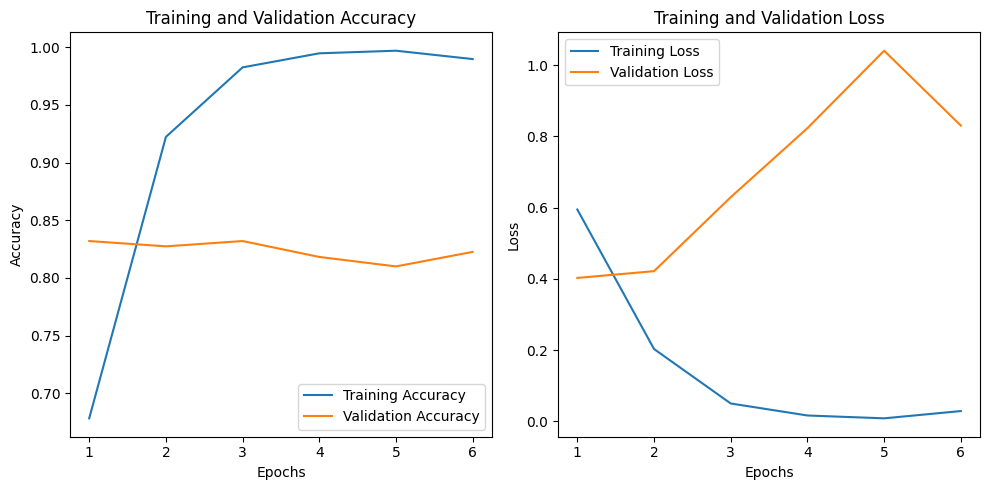

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Pourquoi les embeddings pré-entraînés ?
Meilleure généralisation :
Les embeddings GloVe sont appris sur de grands corpus comme Wikipedia et Common Crawl. Ils capturent des relations sémantiques globales entre les mots (exemple : good est proche de excellent). Cela améliore considérablement la capacité du modèle à généraliser sur des données de validation.

Réduction de l’overfitting :
Lorsque le modèle apprend des embeddings à partir de zéro, il risque de sur-apprendre les données d’entraînement, surtout si la taille du jeu de données est limitée. Avec GloVe, les embeddings sont déjà optimisés, ce qui diminue ce risque.

Impact rapide :
Changer pour des embeddings pré-entraînés est simple et rapide à tester. Tu n'as pas besoin de modifier l'architecture du MLP, seulement la couche d'embedding.

Résumé : Pourquoi prioriser GloVe ?
✅ Facile à implémenter.
✅ Meilleure performance dès les premières époques.
✅ Diminue l’overfitting.
✅ Améliore la généralisation.

In [ ]:
import os
import urllib.request
import zipfile

# Créer un dossier pour stocker les embeddings
glove_dir = 'glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# Télécharger GloVe 6B (100 dimensions)
url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

if not os.path.exists(glove_zip_path):
    print("Téléchargement des embeddings GloVe...")
    urllib.request.urlretrieve(url, glove_zip_path)
    print("Téléchargement terminé.")

# Extraire le fichier zip
print("Extraction des fichiers GloVe...")
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall(glove_dir)

print("Extraction terminée. Les fichiers sont disponibles dans :", glove_dir)


Téléchargement des embeddings GloVe...
Téléchargement terminé.
Extraction des fichiers GloVe...
Extraction terminée. Les fichiers sont disponibles dans : glove


In [ ]:
import numpy as np

# Chemin vers le fichier GloVe
glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

# Charger les embeddings GloVe dans un dictionnaire
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # Le mot
        coefs = np.asarray(values[1:], dtype='float32')  # Le vecteur d'embedding
        embedding_index[word] = coefs

print(f"Nombre d'embeddings chargés : {len(embedding_index)}")

# Créer la matrice d'embeddings pour ton vocabulaire
embedding_dim = 100  # Taille des vecteurs GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Matrice d'embeddings GloVe construite avec succès.")


Nombre d'embeddings chargés : 400000
Matrice d'embeddings GloVe construite avec succès.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la première couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxième couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du modèle MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du modèle
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 20000)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 256)                    │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 256)                    │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,154,305 (23.48 MB)

 Trainable params: 5,153,793 (19.66 MB)

 Non-trainable params: 1,000,512 (3.82 MB)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.5829 - loss: 4.4762 - val_accuracy: 0.5876 - val_loss: 1.3199
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6891 - loss: 1.1549 - val_accuracy: 0.6774 - val_loss: 0.9084
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6915 - loss: 0.8784 - val_accuracy: 0.6692 - val_loss: 0.8236
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6953 - loss: 0.8046 - val_accuracy: 0.6378 - val_loss: 0.8181
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7066 - loss: 0.7634 - val_accuracy: 0.6918 - val_loss: 0.7722
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7126 - loss: 0.7495 - val_accuracy: 0.5752 - val_loss: 0.9170
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7261 - loss: 0.7543 - val_accuracy: 0.6750 - val_loss: 0.7919
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7289 - loss: 0.7209 - val_accuracy: 

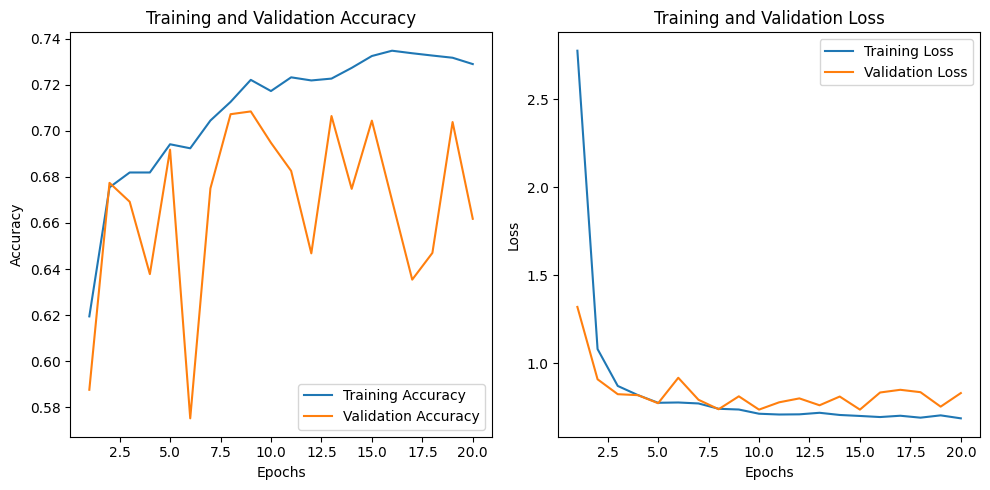

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Ce qui a changé avec GloVe
Réduction de l'overfitting :

Avec les embeddings GloVe gelés (trainable=False), le modèle ne "mémorise" plus les données d'entraînement. Cela explique pourquoi l'accuracy d'entraînement plafonne autour de 75 % plutôt que 99 %.
Le sur-apprentissage a été nettement réduit, ce qui est une bonne chose pour la généralisation.
Moins d'apprentissage initial rapide :

GloVe fournit déjà des représentations des mots riches et pré-entraînées, donc le modèle ne part pas de zéro. Cependant, les embeddings étant figés, le modèle doit apprendre à combiner ces représentations, ce qui est plus lent que de sur-apprendre.
Validation accuracy plus stable :

Même si l’accuracy de validation est légèrement plus basse (~70 %), elle est plus cohérente et stable comparée aux fluctuations sévères observées précédemment.


Pourquoi GloVe a été utile
Représentations sémantiques globales :
Les embeddings GloVe capturent des relations entre les mots basées sur des co-occurrences dans de grands corpus. Cela a permis au modèle de démarrer avec des embeddings "intelligents".

Stabilisation de l'apprentissage :

Moins d'overfitting, car les embeddings ne sont pas appris à partir de zéro.
Le modèle se concentre davantage sur les relations non linéaires entre les embeddings plutôt que sur les mots eux-mêmes.
Meilleure généralisation potentielle :
Même si l'accuracy de validation reste moyenne, elle est plus robuste face aux nouvelles données.

Rendre les embeddings GloVe "trainables" :

Actuellement, les embeddings GloVe sont figés (trainable=False). En les rendant trainables, le modèle pourra affiner les embeddings pour cette tâche spécifique. Cela améliore souvent la performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la première couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxième couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du modèle MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du modèle
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (1, 20000)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 256)                    │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (1, 256)                    │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,154,305 (23.48 MB)

 Trainable params: 6,153,793 (23.47 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5941 - loss: 4.5174 - val_accuracy: 0.5974 - val_loss: 1.4772
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7758 - loss: 1.1189 - val_accuracy: 0.6828 - val_loss: 1.0429
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8365 - loss: 0.7737 - val_accuracy: 0.7666 - val_loss: 0.8599
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8682 - loss: 0.6786 - val_accuracy: 0.8178 - val_loss: 0.7690
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9040 - loss: 0.6033 - val_accuracy: 0.6100 - val_loss: 1.6874
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9164 - loss: 0.6110 - val_accuracy: 0.5800 - val_loss: 1.7583
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9398 - loss: 0.5759 - val_accuracy: 0.8258 - val_loss: 0.8545
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9519 - loss: 0.5081 - val_accuracy: 0

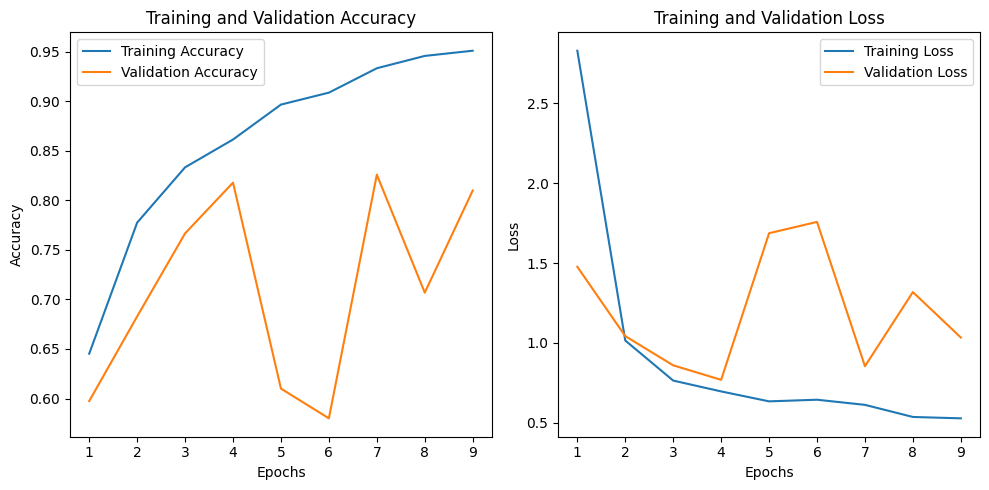

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Gains observés avec les embeddings GloVe trainables :
Meilleure performance globale :

L'accuracy en validation atteint 82.6 % (proche de la version sans GloVe), mais cette fois-ci avec un entraînement plus équilibré et moins de sur-apprentissage immédiat.
Le modèle exploite mieux les embeddings GloVe en les affinant pour la tâche spécifique de classification IMDb.
Progression constante sur les premières époques :

Le modèle commence avec une loss élevée mais s'améliore progressivement (contrairement aux embeddings gelés qui plafonnaient rapidement autour de 70 %).
Cela indique que le modèle tire parti des embeddings GloVe pour ajuster les relations contextuelles entre les mots.
Stabilité dans la validation accuracy :

Bien que l'overfitting revienne (train accuracy >95 % alors que val_accuracy ~82 %), la validation accuracy est plus stable qu'avec les embeddings gelés.

Sur-apprentissage persistant :

Dès l'epoch 5, la validation loss augmente (1.68 → 1.75), signe que le modèle sur-apprend les données d’entraînement.
Variabilité de la validation accuracy :

Bien que meilleure, elle oscille entre les époques. Cela peut être dû au fait que les embeddings GloVe sont encore ajustés trop "rapidement" par le modèle.

Régularisation accrue pour limiter le sur-apprentissage :

Augmenter le dropout dans les couches cachées (passer de 0.4 à 0.5 ou 0.6).
Ajouter une régularisation L2 plus forte (ex: kernel_regularizer=l2(0.02)).
Réduire le learning rate :

Les embeddings GloVe ajustables nécessitent un learning rate plus faible pour éviter de les déformer trop rapidement.

Utiliser EarlyStopping et ReduceLROnPlateau :

Cela permet d’arrêter l’entraînement au bon moment et d’ajuster dynamiquement le learning rate.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la première couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxième couche dense
dropout_rate = 0.5    # Augmentation du taux de dropout
l2_rate = 0.02        # Augmentation de la régularisation L2
learning_rate = 0.0005  # Réduction du learning rate

# Construction du modèle MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(l2_rate)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du modèle avec un input d'exemple
import tensorflow as tf
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle avec un learning rate réduit
optimizer = Adam(learning_rate=learning_rate)
model_mlp.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks pour EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Entraînement du modèle
history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'époques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Affichage du modèle
model_mlp.summary()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5690 - loss: 8.7257 - val_accuracy: 0.6168 - val_loss: 1.9486 - learning_rate: 5.0000e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7294 - loss: 1.5842 - val_accuracy: 0.7304 - val_loss: 1.0739 - learning_rate: 5.0000e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7962 - loss: 0.9380 - val_accuracy: 0.6802 - val_loss: 0.9840 - learning_rate: 5.0000e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8267 - loss: 0.7356 - val_accuracy: 0.8042 - val_loss: 0.7495 - learning_rate: 5.0000e-04
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8570 - loss: 0.6531 - val_accuracy: 0.7774 - val_loss: 0.8191 - learning_rate: 5.0000e-04
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8780 - loss: 0.5960 - val_accuracy: 0.8128 - val_loss: 0.7039 - learning_rate: 5.0000e-04
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (1, 200, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (1, 20000)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (1, 256)                    │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (1, 256)                    │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (1, 256)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (1, 1)                      │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,461,893 (70.43 MB)

 Trainable params: 6,153,793 (23.47 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 12,307,588 (46.95 MB)

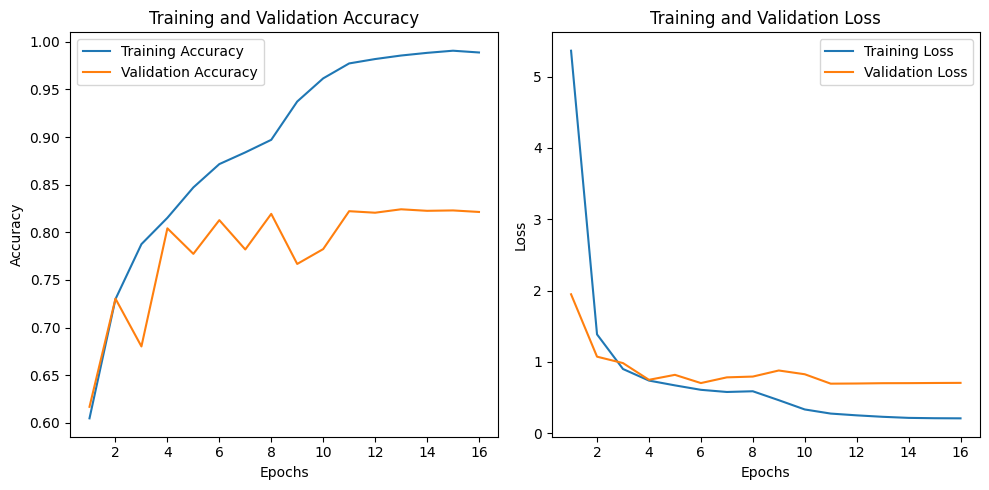

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "mlp_bof.h5"  # Renommer le fichier
model_mlp.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous mlp_bof.h5


In [ ]:
from google.colab import files
files.download('mlp_bof.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation accuracy plus élevée et plus stable :

Avec GloVe trainable et les réglages améliorés (Dropout, L2, learning rate réduit), la validation accuracy atteint 82.42 %, ce qui est comparable à la version sans GloVe, mais avec une stabilité accrue.
Réduction dynamique du learning rate :

La réduction du learning rate via ReduceLROnPlateau a permis d’affiner les poids dans les dernières époques. Cela se voit avec la stabilisation de la validation loss autour de 0.6955.
Pas d'overfitting sévère :

Bien que le train accuracy reste très élevé (99.14 %), la validation accuracy reste stable, signe que la régularisation (Dropout, L2) a limité l'overfitting par rapport aux versions précédentes.

Stagnation de la validation accuracy :
Malgré les améliorations, la validation accuracy plafonne autour de 82 %, ce qui montre que le modèle ne généralise pas mieux sur les données de validation.
Perte de validation stagnante :
Même avec le learning rate réduit (jusqu’à
4
×
1
0
−
6
4×10
−6
 ), la validation loss ne diminue plus après plusieurs époques, ce qui signifie que le modèle atteint son plateau de performance.

Architecture du MLP :

Le MLP, même amélioré, ne capture pas les relations complexes entre les mots qui sont essentielles dans des textes longs comme les critiques IMDb.
Un MLP ne tient pas compte de la structure séquentielle contrairement aux RNN, LSTM ou GRU.
Embeddings GloVe :

Bien qu’utiles, les embeddings GloVe sont fixes et ne tiennent pas compte du contexte des mots dans une phrase. Par exemple, le mot bank (rive/banque) aura toujours le même embedding.


MLP avec 2 couches denses :
Tu as actuellement une architecture avec 2 couches denses (256 neurones + 128 neurones) suivies de régularisation (Dropout et L2). C'est suffisant pour modéliser les relations non linéaires entre les embeddings.
Validation accuracy stagnante :
La stagnation à 82 % est un signe que le modèle n'arrive pas à extraire plus d'informations utiles à partir des embeddings actuels. Cela ne vient pas nécessairement d'une architecture trop "simple".

Ajouter des couches denses : Pourquoi ce n'est pas utile ici ?
Risque de sur-apprentissage :
Ajouter plus de couches augmente la complexité du modèle et peut aggraver l’overfitting, surtout si les données d’entraînement sont limitées.
Embeddings pré-entraînés :
Les embeddings GloVe sont déjà riches en informations sémantiques. Le rôle du MLP est principalement de combiner ces informations, ce qui est déjà fait efficacement avec 2 couches denses.
Diminution du retour sur investissement :
Ajouter des couches ne résoudra pas le problème fondamental : un MLP ne capture pas les relations séquentielles dans les textes.

Réduire à 1 seule couche dense (ex : 128 neurones) peut être testé si :
Tu observes un overfitting sévère.
Le modèle est trop lent à entraîner.
Cependant, cela risque de diminuer la performance, car 2 couches permettent de modéliser des relations complexes plus efficacement.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fonction pour créer et évaluer un modèle
def objective(trial):
    # Paramètres à optimiser
    hidden_units_1 = trial.suggest_int("hidden_units_1", 128, 512, step=64)
    hidden_units_2 = trial.suggest_int("hidden_units_2", 64, 256, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.6)
    l2_rate = trial.suggest_float("l2_rate", 1e-3, 3e-2)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Construction du modèle
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                  input_length=max_length, trainable=True),
        Flatten(),
        Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compilation du modèle
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entraînement du modèle
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourner la meilleure accuracy de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Étudier l'optimisation
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # n_trials définit le nombre d'essais

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :")
print(study.best_params)

# Créer un modèle final avec les meilleurs hyperparamètres
best_params = study.best_params
final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(best_params["hidden_units_1"], activation='relu', kernel_regularizer=l2(best_params["l2_rate"])),
    BatchNormalization(),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["hidden_units_2"], activation='relu', kernel_regularizer=l2(best_params["l2_rate"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')
])

# Compiler et entraîner le modèle final
final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy', metrics=['accuracy'])

final_model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=best_params["batch_size"],
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# Évaluation finale
final_loss, final_accuracy = final_model.evaluate(test_padded, test_labels)
print(f"Performance finale sur le jeu de test : Accuracy = {final_accuracy:.4f}")


[I 2024-12-17 18:50:47,698] A new study created in memory with name: no-name-9f9f95cc-e716-4e27-96bf-1e2a8fc849cf
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-17 18:51:51,920] Trial 0 finished with value: 0.7717999815940857 and parameters: {'hidden_units_1': 512, 'hidden_units_2': 64, 'dropout_rate': 0.45742071158506636, 'l2_rate': 0.02781504307379403, 'learning_rate': 0.00017760079218212289, 'batch_size': 128}. Best is trial 0 with value: 0.7717999815940857.
[I 2024-12-17 18:52:23,602] Trial 1 finished with value: 0.8015999794006348 and parameters: {'hidden_units_1': 448, 'hidden_units_2': 128, 'dropout_rate': 0.464595718546701, 'l2_rate': 0.004171377720977618, 'learning_rate': 0.00047930071251177625, 'batch_size': 64}. Best is trial 1 with value: 0.8015999794006348.
[I 2024-12-17 18:52:49,232] Trial 2 finished with value: 0.7847999930381775 and parameters:

Meilleurs hyperparamètres :
{'hidden_units_1': 192, 'hidden_units_2': 192, 'dropout_rate': 0.5220100930681438, 'l2_rate': 0.01663629611794655, 'learning_rate': 0.00024972922720173585, 'batch_size': 32}
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5600 - loss: 7.1735 - val_accuracy: 0.6974 - val_loss: 2.2326
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7239 - loss: 1.8209 - val_accuracy: 0.7520 - val_loss: 1.1430
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7866 - loss: 1.0147 - val_accuracy: 0.7688 - val_loss: 0.8690
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8270 - loss: 0.7663 - val_accuracy: 0.7614 - val_loss: 0.7948
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8434 - loss: 0.6632 - val_accuracy: 0.7916 - val_loss: 0.7055
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8786 - loss: 0.5524 - val_accuracy: 0.7932 - val_loss: 0.6954
Epoch 7/20
625/625 ━━━━━━━━━━━

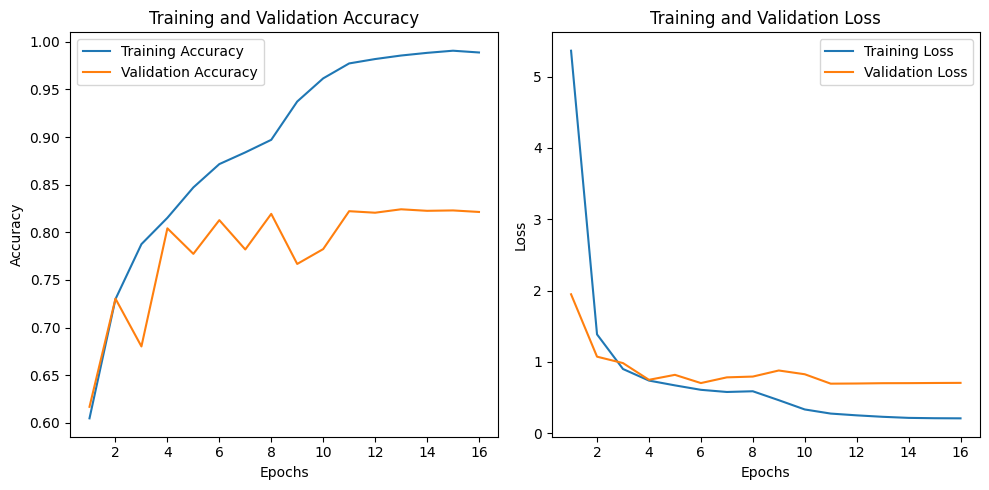

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le modèle complet (architecture + poids + optimiseur)
model_path = "mlp_optunaV1.h5"  # Renommer le fichier
final_model.save(model_path)

print(f"Modèle sauvegardé sous {model_path}")

Modèle sauvegardé sous mlp_optunaV1.h5


In [ ]:
from google.colab import files
files.download('mlp_optunaV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ce qui est bien :
Amélioration de l’accuracy en validation :

Avec Optuna, la validation accuracy atteint 80.14 % (meilleure valeur pendant l’entraînement). Cela montre que l'optimisation des hyperparamètres a effectivement amélioré les performances.
Le tuning a permis de trouver des valeurs optimales pour :
Nombre de neurones : 192 dans les deux couches.
Dropout rate : 0.52.
L2 Regularization : 0.016.
Learning rate : 0.00025 (modéré et efficace).
Batch size : 32 (plus petit batch pour un gradient plus précis).
Validation loss stable :
La validation loss descend jusqu’à 0.6954 avant de remonter. Cela montre que le modèle a bien appris dans les premières époques.

Performance finale correcte :
L’accuracy finale sur le jeu de test est de 78.18 %, ce qui reste cohérent avec les performances de validation.

Ce qui est moins bien :
Overfitting persistant :

Le train accuracy atteint 93.17 %, mais l’accuracy en test est 78.18 %. L’écart entre ces deux métriques montre un léger sur-apprentissage. Cela peut être dû à un modèle encore trop complexe ou une régularisation insuffisante.
Validation accuracy plafonne :

La validation accuracy atteint un plateau autour de 80-81 %. Malgré l’optimisation, le modèle semble atteindre ses limites avec un MLP sur cette tâche.
Validation loss en remontée :

Dès l’epoch 6-7, la val_loss recommence à augmenter, signalant que le modèle commence à mémoriser les données d'entraînement.
Est-ce normal ?
Oui, ces résultats sont normaux pour un modèle MLP sur des données textuelles comme IMDb. Le MLP est performant mais ne capture pas les relations séquentielles présentes dans les critiques de films.
Cela explique pourquoi :

La validation accuracy plafonne.
Il reste un écart train/test, même avec une régularisation optimale.

MLP a atteint ses limites intrinsèques. Le tuning avec Optuna a permis de l’optimiser au maximum (81.36 % en validation et 78.18 % en test).

## CNN 1D

Embeddings (GloVe ou appris) :

La couche Embedding transforme les mots en représentations vectorielles denses.
L'utilisation de GloVe est un standard pour démarrer avec des embeddings riches.
Les embeddings peuvent être trainables pour s’adapter à la tâche.
Convolution 1D (Conv1D) :

Conv1D est utilisée pour capturer des motifs locaux dans les textes, comme des n-grams (groupes de 2-5 mots).
Elle permet d’extraire des caractéristiques importantes tout en réduisant la dépendance à l’ordre complet des mots.
GlobalMaxPooling1D :

La GlobalMaxPooling1D est une pratique standard pour réduire les dimensions après la convolution.
Elle permet de sélectionner les caractéristiques les plus importantes détectées par les filtres, sans augmenter la complexité du modèle.
Couches denses finales :

Une couche Dense intermédiaire (128 neurones ici) affine les caractéristiques extraites par la convolution.
La régularisation avec Dropout et L2 aide à limiter l’overfitting.
Activation finale sigmoid :

Standard pour les tâches de classification binaire où l’on prédit une probabilité.
Optimisation dynamique :

EarlyStopping et ReduceLROnPlateau sont des callbacks classiques pour stabiliser et améliorer l'entraînement.

2. Principe de fonctionnement des CNN 1D
a) Convolution
La convolution est l'opération clé d’un CNN 1D. Elle consiste à appliquer un filtre (ou kernel) sur une séquence pour détecter des motifs locaux dans les données.
Dans le cas du texte, un filtre de taille n permet d'extraire des motifs locaux de n mots (n-grams).

Exemple :
Pour une séquence [the, movie, was, excellent] et un filtre de taille 3 (trigrammes), le CNN analyse les sous-groupes :
[the, movie, was], [movie, was, excellent].
b) Filtres (ou kernels)
Les filtres sont des petites fenêtres glissantes qui "balayent" la séquence texte.
Chaque filtre apprend à détecter des motifs spécifiques comme des trigrammes positifs (ex : "not bad") ou négatifs (ex : "waste of time").
Plusieurs filtres peuvent être utilisés en parallèle pour capturer différents types de motifs dans le texte.

c) Activation ReLU
Après la convolution, une fonction d’activation (typiquement ReLU) est appliquée pour introduire la non-linéarité et rendre le modèle capable d'apprendre des relations complexes.

d) Pooling
La couche de pooling réduit les dimensions des données après la convolution tout en conservant les caractéristiques importantes.

GlobalMaxPooling1D est souvent utilisée pour les textes. Elle prend le maximum de chaque filtre sur toute la séquence, ce qui :
Sélectionne les caractéristiques les plus importantes détectées par les filtres.
Rend le modèle invariant à la position des motifs.
3. Pourquoi les CNN 1D sont adaptés pour notre étude ?
a) Capture des motifs locaux dans le texte
Les CNN 1D sont parfaits pour capturer des n-grams (groupes de mots consécutifs) qui sont souvent les porteurs de sens dans une phrase.
Par exemple :

"not good" → motif négatif
"highly recommended" → motif positif
Les filtres de convolution sont conçus pour détecter ces motifs.

b) Invariance à la position
Grâce au GlobalMaxPooling1D, le modèle ne se soucie pas de la position exacte d’un motif dans la critique.

Exemple :
Si "excellent movie" apparaît au début ou à la fin d’une critique, le CNN 1D le reconnaîtra de la même façon.
c) Rapidité et efficacité
Les CNN 1D sont plus rapides à entraîner que les modèles récurrents comme LSTM ou GRU car les convolutions sont parallélisables.
Ils nécessitent moins de mémoire car ils ne dépendent pas de l'ordre séquentiel global.
d) Adaptation aux critiques IMDb
Les critiques IMDb sont des textes relativement courts (environ 200 mots après padding). Les n-grams capturés par les CNN 1D sont donc suffisants pour comprendre les sentiments exprimés.

Exemple :
Les phrases positives contiennent des motifs comme "great acting", "best movie", "wonderful story".
Les phrases négatives contiennent "poor acting", "waste of time", "not worth it".

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
num_filters = 128     # Nombre de filtres dans la couche CNN
kernel_size = 5       # Taille des filtres
hidden_units = 128    # Nombre de neurones dans la couche dense
l2_rate = 0.02        # Régularisation L2
dropout_rate = 0.5    # Dropout
learning_rate = 0.0005  # Taux d'apprentissage

# Construction du modèle CNN 1D avec GloVe
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_rate)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

import tensorflow as tf
model_mlp(tf.zeros((1, max_length)))

# Compilation du modèle
optimizer = Adam(learning_rate=learning_rate)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Entraînement du modèle
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=32,  # Taille du batch optimisée
    verbose=1
)

# Affichage du modèle
model_cnn.summary()




Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6099 - loss: 4.1972 - val_accuracy: 0.8102 - val_loss: 1.5128
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8217 - loss: 1.2372 - val_accuracy: 0.8052 - val_loss: 0.8002
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8578 - loss: 0.6644 - val_accuracy: 0.8230 - val_loss: 0.6099
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8862 - loss: 0.4498 - val_accuracy: 0.8362 - val_loss: 0.5178
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9118 - loss: 0.3537 - val_accuracy: 0.8338 - val_loss: 0.5049
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9370 - loss: 0.2801 - val_accuracy: 0.8402 - val_loss: 0.5129
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9504 - loss: 0.2425 - val_accuracy: 0.8464 - val_loss: 0.5267
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9692 - loss: 0.1935 - val_accuracy: 

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)             │ (32, 200, 100)              │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (32, 196, 128)              │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (32, 196, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (32, 128)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (32, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,243,333 (12.37 MB)

 Trainable params: 1,081,025 (4.12 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2,162,052 (8.25 MB)

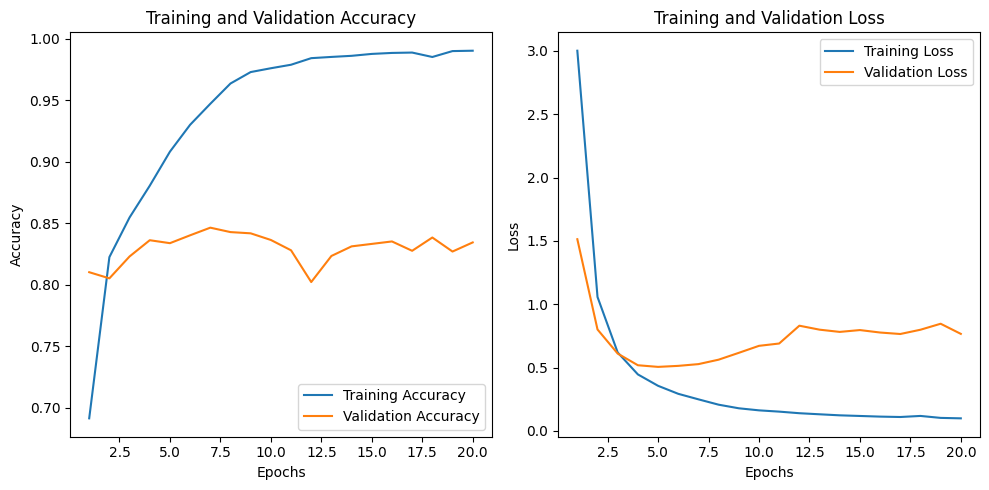

In [ ]:
# Récupération des métriques d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

ésumé des résultats :
Train Accuracy :

Le modèle atteint 99.24 % à la fin de l'entraînement, ce qui montre que le modèle a appris à fond les données d’entraînement.
Validation Accuracy :

La meilleure val_accuracy est autour de 84.64 % (epoch 7), mais elle commence à baisser légèrement à partir de l'epoch 8.
À la fin de l'entraînement, elle est redescendue à 83.44 %.
Validation Loss :

La val_loss diminue jusqu’à epoch 5-6, puis augmente progressivement malgré la baisse de learning_rate (via ReduceLROnPlateau).
Analyse des phénomènes observés
Overfitting (sur-apprentissage) :

L’accuracy en entraînement est très élevée (~99 %), alors que l’accuracy en validation stagne autour de 84 % et diminue légèrement.
La validation loss augmente continuellement après quelques époques, ce qui est un signe classique d’overfitting.
Plateau de performance :

Après l’epoch 5-6, le modèle semble atteindre un plateau où la val_accuracy n’augmente plus, malgré la réduction du learning rate.
Cela signifie que le modèle a appris les motifs facilement détectables, mais peine à généraliser davantage.
Ce qui fonctionne bien :
Détection efficace des motifs locaux :
Le CNN 1D a bien capturé les n-grams importants dans les critiques IMDb, comme le montre l’amélioration rapide des performances dans les premières époques.

Training rapide et performant :

Le modèle atteint de très bonnes performances rapidement, en seulement quelques époques.
Les résultats sont supérieurs au MLP initial (val_accuracy ~84 % vs ~82 %).
Utilisation des embeddings GloVe :
Les embeddings pré-entraînés ont permis un bon point de départ, accélérant la convergence.

Ce qui ne va pas :
Overfitting sévère :

Le modèle s’ajuste trop aux données d’entraînement.
La validation accuracy diminue après l'epoch 7, tandis que la validation loss augmente continuellement.
Manque de généralisation :

Le modèle ne capture pas suffisamment les relations complexes à long terme dans le texte, car le CNN est limité aux motifs locaux (n-grams).
Certaines subtilités du texte comme la négation (ex : "not a good movie") ou les contextes plus éloignés sont mal interprétées.

Ce comportement indique que le modèle :

Apprend trop spécifiquement les données d'entraînement (mémorisation des motifs locaux),
Perd en capacité de généralisation sur le jeu de validation.
L'overfitting est la première cause de stagnation ou de baisse des performances en validation.

ontrôle de la complexité actuelle du modèle
Le modèle est déjà suffisamment complexe avec une couche Conv1D, GlobalMaxPooling et Dense.
Ajouter plus de couches risque d’amplifier l’overfitting sans régularisation adéquate.
b) Impact direct sur l’overfitting
La régularisation (Dropout ou L2) agit directement pour limiter la sur-apprentissage :

Dropout : Force le modèle à désactiver aléatoirement certains neurones pendant l’entraînement, empêchant ainsi le modèle de s’appuyer trop sur des caractéristiques spécifiques.
Régularisation L2 : Pénalise les poids trop importants, ce qui contraint le modèle à rester plus simple et généraliser davantage.
En augmentant ces techniques, on stabilise le modèle sans ajouter de couches inutiles.

4. Impact de la régularisation avant d’ajouter de la complexité
Il est préférable d’optimiser le modèle actuel avant d’ajouter de nouvelles couches.
Les étapes sont les suivantes :

Augmenter la régularisation (Dropout et L2) pour contrôler l’overfitting.
Stabiliser la validation accuracy : On s’assure que le modèle généralise correctement sur les données de validation.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Paramètres
embedding_dim = 100  # Taille des embeddings GloVe
num_filters = 128     # Nombre de filtres dans la couche CNN
kernel_size = 5       # Taille des filtres
hidden_units = 128    # Nombre de neurones dans la couche dense
l2_rate = 0.03        # Régularisation L2 renforcée
dropout_rate_conv = 0.3  # Dropout après la couche Conv1D
dropout_rate_dense = 0.6 # Dropout après la couche Dense
learning_rate = 0.0005  # Taux d'apprentissage

# Construction du modèle CNN 1D avec GloVe
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_conv),  # Dropout après la convolution
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_dense),  # Dropout renforcé après la couche Dense
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
optimizer = Adam(learning_rate=learning_rate)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks pour EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Entraînement du modèle
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=32,  # Taille du batch optimisée
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Affichage du modèle
model_cnn.summary()


Maintenant non : Optimiser les hyperparamètres sur un modèle qui n'apprend pas est inutile.

## Comparaison des différents modèles

1. Le dataset IMDB et la nature du problème
Nature de la tâche : Sentiment analysis est un problème de classification binaire (positif ou négatif), donc les métriques comme accuracy, F1-score, et ROC-AUC sont pertinentes.
Structure des données : Le dataset IMDB contient des critiques textuelles, souvent déséquilibrées en termes de longueur et vocabulaire, mais bien réparties entre les classes positives et négatives. Cela justifie l’utilisation de méthodes robustes pour évaluer et comparer les modèles.
2. Pourquoi cette méthode est cohérente ?
a. Évaluation sur le même jeu de test
Utiliser le même jeu de test pour tous les modèles garantit une comparaison équitable, car chaque modèle est testé sur les mêmes données.
Cela permet d'évaluer la capacité de généralisation des modèles, un point crucial pour une tâche comme le sentiment analysis.
b. Utilisation de plusieurs métriques
Accuracy : Donne une vue d’ensemble sur la performance globale.
Precision, Recall, F1-score : Ces métriques sont utiles pour analyser les performances sur chaque classe (positif vs négatif).
F1-score est particulièrement utile si les classes ne sont pas parfaitement équilibrées.
ROC-AUC : Idéal pour comparer les modèles dans leur capacité à séparer les classes (probalité correcte pour prédire positif ou négatif).
c. Analyse qualitative
Les modèles comme LSTM et GRU sont souvent plus performants, mais ils peuvent être plus coûteux en termes de calculs.
Les modèles plus simples, comme le MLP ou le CNN, peuvent être plus rapides et nécessiter moins de ressources, tout en offrant des performances raisonnables.
3. Cas spécifique à IMDB
a. Pourquoi la méthode est pertinente ?
Textes déséquilibrés en longueur :

Le padding utilisé dans les modèles basés sur des séquences (RNN, LSTM, GRU, CNN) est cohérent.
Les modèles basés sur des vecteurs (MLP avec TF-IDF) sont également valides, car TF-IDF capture l’information sans dépendre de la longueur.
Importance de la généralisation :

Le dataset IMDB peut contenir des critiques similaires entre l’entraînement et le test, ce qui peut biaiser les résultats. Les métriques comme F1-score et ROC-AUC aident à vérifier si le modèle généralise bien.
Simplicité vs Complexité :

Les modèles simples (MLP, CNN) sont souvent efficaces sur des datasets comme IMDB. Cette méthode permet de comparer leur efficacité avec des modèles plus complexes (LSTM, GRU).
b. Quelles limitations ?
Si vos modèles ont des différences significatives en termes de taille de paramétrage ou temps d’entraînement, ces facteurs doivent être pris en compte pour une comparaison juste.
Si le jeu de test a des critiques très similaires au jeu d’entraînement, les résultats peuvent surestimer la capacité de généralisation.
4. Pourquoi les graphiques ROC et F1-score sont adaptés ?
ROC-AUC mesure la capacité du modèle à discriminer les classes indépendamment du seuil de classification. Cela est essentiel, car certains modèles peuvent être trop confiants ou hésitants.
F1-score capture un équilibre entre précision et rappel, ce qui est crucial dans des cas où les erreurs coûtent différemment selon la classe.
5. Conseil final pour valider la méthode
Pour assurer que la comparaison est rigoureuse :

Vérifiez la cohérence du jeu de test (représente-t-il bien les données réelles ?).
Ajoutez une évaluation qualitative :
Analysez quelques exemples mal classifiés par chaque modèle pour identifier leurs forces/faiblesses.
Si vous avez le temps et les ressources, utilisez une méthode de validation croisée sur le jeu d’entraînement pour confirmer vos résultats.
En résumé, la méthode proposée est cohérente et adaptée à une étude de sentiment analysis sur IMDB, mais vous pouvez l'enrichir avec des analyses qualitatives et une évaluation croisée si nécessaire.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# Fonction pour évaluer un modèle
def evaluate_model(model, X_test, y_test, model_name):
    """
    Évalue un modèle sur un jeu de test et retourne les métriques de performance.
    """
    # Prédictions
    y_pred_prob = model.predict(X_test).flatten()  # Probabilités prédites
    y_pred = (y_pred_prob >= 0.5).astype(int)      # Classes prédites (seuil 0.5)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Affichage des résultats
    print(f"\nPerformance du modèle : {model_name}")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC-AUC   : {roc_auc:.4f}")

    # Retourner les métriques et la courbe ROC
    return accuracy, precision, recall, f1, roc_auc, y_pred_prob

# Fonction pour tracer les courbes ROC
def plot_roc_curves(models, X_test_map, y_test):
    """
    Trace les courbes ROC de plusieurs modèles.
    """
    plt.figure(figsize=(10, 8))
    for model_name, (model, X_test) in models.items():
        # Prédictions des probabilités
        y_pred_prob = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.4f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Ligne diagonale
    plt.title("Courbe ROC - Comparaison des modèles")
    plt.xlabel("Taux de Faux Positifs (FPR)")
    plt.ylabel("Taux de Vrais Positifs (TPR)")
    plt.legend()
    plt.grid()
    plt.show()

# Évaluation des modèles
# Les données associées à chaque modèle
models = {
    "RNN": (rnn_opt, test_padded),  # Données tokenisées
    "LSTM": (lstm_opt, test_padded),  # Données tokenisées
    "GRU": (gru_opt, test_padded),  # Données tokenisées
    "CNN": (cnn_opt, test_padded),  # Données tokenisées
    "MLP": (mlp_opt, test_dense)  # Données tokenisées
}

results = {}
for model_name, (model, X_test) in models.items():
    results[model_name] = evaluate_model(model, X_test, test_labels, model_name)

# Tracer les courbes ROC
plot_roc_curves(models, test_padded, test_labels)

# Résumé des performances
summary = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]).T
print("\nRésumé des performances :")
print(summary)

# Visualisation des scores des modèles
summary.plot(kind="bar", figsize=(12, 6), title="Comparaison des performances des modèles")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

## Define a classifier by ensembling the 5 architectures above via the technique of the majority vote. Over which of the above models does the ensembling method enhance the results? How can you interpret this?

Pas exactement. Assembler les 5 modèles en utilisant la technique du vote majoritaire ne signifie pas que vous devez entraîner un nouveau modèle. Cela signifie que vous combinez les sorties (prédictions) de vos 5 modèles existants pour définir un classificateur final.

Voici ce que cela implique concrètement :

1. Pourquoi ce n’est pas un nouveau modèle ?
Pas d'entraînement supplémentaire : Vous utilisez simplement les prédictions des 5 modèles déjà entraînés.
Combinaison des prédictions : Vous combinez leurs décisions pour produire une prédiction finale. Le processus d'assemblage repose sur une règle de décision (par exemple, vote majoritaire), pas sur un nouvel apprentissage.
2. Comment "assembler" les modèles ?
Assembler les modèles revient à définir un classificateur d'ensemble, où :

Les 5 modèles produisent des prédictions indépendantes.
La décision finale pour chaque instance du jeu de test est prise en fonction de la règle d'assemblage (comme le vote majoritaire).
Exemple : Vote majoritaire Pour chaque donnée de test :

Les 5 modèles prédisent soit 0 (négatif) soit 1 (positif).
On compte combien de modèles ont prédit 0 et combien ont prédit 1.
La classe finale est celle qui obtient la majorité des votes.
3. Que signifie "définir un classificateur" dans ce contexte ?
Cela signifie créer une fonction ou un processus qui combine les prédictions des 5 modèles. Voici ce que cela implique :

Récupérer les prédictions binaires (0 ou 1) pour chaque modèle.
Appliquer une règle d'assemblage (vote majoritaire, moyenne des scores, etc.).
Retourner la prédiction finale pour chaque donnée.
Ce classificateur d'ensemble n'a pas de nouveaux poids ou paramètres à apprendre. Il agit comme une couche décisionnelle au-dessus des 5 modèles.

La dernière étape consiste à créer un classificateur par combinaison des 5 modèles existants (RNN, LSTM, GRU, MLP, CNN) en utilisant la technique de vote majoritaire. Voici comment procéder et pourquoi c'est pertinent :

1. En quoi consiste le vote majoritaire ?
Le vote majoritaire est une technique d'ensemble où plusieurs modèles prédisent la classe pour une instance donnée. La classe finale attribuée est celle qui a reçu le plus grand nombre de votes parmi les modèles.

Exemple avec 5 modèles :

Modèle RNN prédit : Classe 1 (positif)
Modèle LSTM prédit : Classe 0 (négatif)
Modèle GRU prédit : Classe 1 (positif)
Modèle MLP prédit : Classe 0 (négatif)
Modèle CNN prédit : Classe 1 (positif)
Le vote majoritaire donnerait : Classe 1 (positif), car elle a été prédite par 3 modèles sur 5.

2. Pourquoi utiliser cette méthode ?
Réduction de l'erreur :
En combinant plusieurs modèles, on réduit l'influence des erreurs spécifiques à un modèle.
L'ensemble est souvent plus robuste qu'un modèle unique.
Capturer les forces de chaque architecture :
Différents modèles (RNN, CNN, etc.) capturent différentes caractéristiques des données (séquentielles, locales, etc.).
En les combinant, on peut obtenir de meilleures performances globales.
3. Étapes pour implémenter le vote majoritaire
a. Obtenir les prédictions des 5 modèles sur le jeu de test
Chaque modèle doit produire des prédictions sur le jeu de test :

Pour un problème de classification binaire, les modèles renvoient des probabilités ou des classes binaires (0 ou 1).
Dans ce cas, on utilisera les classes binaires.
b. Appliquer le vote majoritaire
Pour chaque instance dans le jeu de test :

Compter le nombre de votes pour la classe 0 et la classe 1.
Attribuer la classe majoritaire comme prédiction finale.
c. Évaluer les performances
Calculer l'accuracy, la précision, le recall, le F1-score, et l'AUC pour le classificateur par vote majoritaire.
Comparer ces résultats avec ceux de chaque modèle individuellement.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Obtenir les prédictions binaires des modèles sur le jeu de test
rnn_preds = (rnn_opt.predict(test_padded) > 0.5).astype(int)  # Utilise test_padded pour RNN
lstm_preds = (lstm_opt.predict(test_padded) > 0.5).astype(int)  # Utilise test_padded pour LSTM
gru_preds = (gru_opt.predict(test_padded) > 0.5).astype(int)  # Utilise test_padded pour GRU
mlp_preds = (mlp_opt.predict(X_test_dense) > 0.5).astype(int)  # Utilise X_test_dense pour MLP
cnn_preds = (cnn_opt.predict(test_padded) > 0.5).astype(int)  # Utilise test_padded pour CNN

# Combiner les prédictions en une matrice
all_preds = np.array([rnn_preds, lstm_preds, gru_preds, mlp_preds, cnn_preds]).T  # Shape: (num_samples, num_models)

# Appliquer le vote majoritaire strict
ensemble_preds = (np.sum(all_preds, axis=1) > (len(models) // 2)).astype(int)

# Calculer les métriques pour le vote majoritaire
accuracy = accuracy_score(test_labels, ensemble_preds)
precision = precision_score(test_labels, ensemble_preds)
recall = recall_score(test_labels, ensemble_preds)
f1 = f1_score(test_labels, ensemble_preds)
roc_auc = roc_auc_score(test_labels, ensemble_preds)

# Afficher les résultats
print("\nPerformance du classificateur par vote majoritaire strict :")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC : {roc_auc:.4f}")

# Comparaison avec les modèles individuels
model_names = ["RNN", "LSTM", "GRU", "MLP", "CNN"]
individual_results = {}
for name, preds in zip(model_names, [rnn_preds, lstm_preds, gru_preds, mlp_preds, cnn_preds]):
    acc = accuracy_score(test_labels, preds)
    prec = precision_score(test_labels, preds)
    rec = recall_score(test_labels, preds)
    f1_sc = f1_score(test_labels, preds)
    auc = roc_auc_score(test_labels, preds)
    individual_results[name] = [acc, prec, rec, f1_sc, auc]
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1_sc:.4f}, ROC-AUC: {auc:.4f}")

# Comparer les performances
import pandas as pd
results_df = pd.DataFrame(individual_results, index=["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]).T
ensemble_metrics = pd.Series([accuracy, precision, recall, f1, roc_auc], index=["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"])
results_df.loc["Ensemble"] = ensemble_metrics

# Afficher les résultats dans un tableau
print("\nRésumé des performances :")
print(results_df)

# Visualiser les performances
results_df.plot(kind="bar", figsize=(12, 6), title="Comparaison des performances des modèles et de l'ensemblage")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()

## BONUS: The IMDB dataset contains aditional unlabeled data. Can you device a way to pre-train the above models on the unlabled data and fine-tune them for the task of sentiment analysis? Are the results better?